In [82]:
# General Imports
import numpy as np
import pandas as pd
import csv
import time
import os
from datetime import datetime as dtime
import re


# Plotting
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import Normalize
# TeX Label Config
import matplotlib as mpl
mpl.rcParams.update({
    'text.usetex': False,
    'font.family': 'serif',
    'font.serif': 'cmr10',
    'mathtext.fontset': 'cm',
    'font.family': 'STIXGeneral',
    'font.size': 14,
    'axes.unicode_minus': True,
    'figure.autolayout': True,
    'legend.fontsize': 'large'
    })

# Pytorch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

# Sklearn, scipy
from scipy.stats import unitary_group
from scipy.optimize import curve_fit

# tqdm for progress bar
from tqdm import trange, tqdm

# ipython config
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

## Global definitions

In [137]:
# Number of qubits in considered system
# Dimension of Hilbert space is 2 ** NQ
# Total independent parameters in state density matrix is 4**NQ -1

NQ = 2
state_gen_method = 'random_uniform_vector'

assert state_gen_method in ['unitary_column', 'random_uniform_vector']

In [3]:
# State Visualization

def plot_dm(astate, title='', save_path=False, fixed_scale=False):

    # Make square matrix
    if len(astate.shape) == 1:
        dim = int(np.sqrt(len(astate)))
        astate = astate.reshape(dim, dim)
    else:
        dim = len(astate)

    # Init arrays
    dz = astate.ravel()
    xpos, ypos = np.meshgrid(np.arange(dim), np.arange(dim))
    xpos = xpos.ravel()
    ypos = ypos.ravel()


    fig = plt.figure(dpi=80)

    # Optionally setting scale
    if fixed_scale:
        vmin, vmax = fixed_scale
    else:
        vmin=min(dz)
        vmax=max(dz)

    # Init colorbar
    cmap = cm.get_cmap('plasma')
    norm = Normalize(vmin=vmin, vmax=vmax)
    colors = cmap(norm(dz))

    # 2D color plot
    ax = fig.add_subplot(5,7,(12,28))
    ax.imshow(astate, vmin=vmin, vmax=vmax, cmap=cmap)
    a=ax.set_xticks(xpos)
    a=ax.set_yticks(ypos)
    a=sc = cm.ScalarMappable(cmap=cmap,norm=norm)
    a=sc.set_array([])
    a=plt.colorbar(sc)


    # Classical 3D density matrix plot
    ax = fig.add_subplot(5,7,(1,32), projection='3d')
    a=ax.bar3d(x=xpos-.25, y=ypos-.25, z=0, dx=0.5, dy=0.5, dz=dz, color=colors)
    a=ax.set_xticks(xpos)
    a=ax.set_yticks(ypos)
    a=ax.set_zticks([])
    a=ax.set_zlim(-max(dz), max(dz))
    a=ax.grid(False)
    #Plot grid on z=0
    for i in range(dim):
        a=ax.plot(i*np.ones(dim), np.arange(dim), 0, color='k', lw=.5)
        a=ax.plot(np.arange(dim), i*np.ones(dim), 0, color='k', lw=.5)

    if title != '':
        fig.suptitle(title)

    if save_path: plt.savefig(save_path, dpi=120)

    plt.show()

# State Generator

## Pure states

In [4]:
if state_gen_method == 'unitary_column':
    # Adapted for vector from unitary group
    def create_pure_rho(nqubits):
        dim = 2**nqubits
        psi = unitary_group.rvs(dim)[0]
        # psi =   np.random.uniform(low=-1, high=1, size=dim) + 1j * np.random.uniform(low=-1, high=1, size=dim) 
        rho = np.outer(psi, psi.T.conjugate())
        
        #Positive-definiteness given due to outer product above
        # Trace condition
        rho /= np.trace(rho)
        
        return rho

if state_gen_method == 'random_uniform_vector':
    ### Random number states
    def create_pure_rho(nqubits):
        dim = 2**nqubits
        psi =   np.random.uniform(low=-1, high=1, size=dim) +\
                1j * np.random.uniform(low=-1, high=1, size=dim) 
        rho = np.outer(psi, psi.T.conjugate())

        # Trace condition
        rho /= np.trace(rho)

        # Positive semi-definiteness condition
        if not np.all(np.linalg.eigvals(rho) >= -1e-10):
            # print('recursive')
            return create_pure_rho(nqubits)
        return rho

In [5]:
# Test Trace nqubits = NQ
n = 100
print('Traces of 100 test 1qubit states squared = 1?')
traces = np.array([create_pure_rho(nqubits=NQ) for _ in range(n)])
traces = np.array([np.trace(np.real(rho.dot(rho))) for rho in traces])
np.all( (traces-1) < 1e-10 )

Traces of 100 test 1qubit states squared = 1?


True

## Mixed States

### Partial trace method

In [6]:
def partial_trace(rho):
    dim = 2**NQ
    reduced = np.zeros((dim,dim), dtype=np.complex128)
    for bvec in np.eye(dim):
        bra = np.kron(np.eye(dim), bvec)
        reduced += bra.dot(rho.dot(bra.T))
    return reduced

# Wrapper function
def random_rho(pure):
    if pure:
        return create_pure_rho(nqubits=NQ)
    else:
        return partial_trace(create_pure_rho(nqubits=NQ*2))

(1+0j)

(0.58+0j)

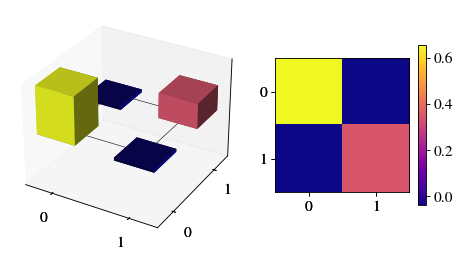

In [7]:
#Test
astate = random_rho(pure=False)
# Tr(rho)
np.round(np.trace(astate),2)
# Tr(rho^2)
np.round(np.trace(astate.dot(astate)),2)
plot_dm(np.real(astate))

### Bloch vector method

In [8]:
# # Pauli matrices
# s1 = np.array([[0,1],[1,0]])
# s2 = np.array([[0,-1j],[1j,0]])
# s3 = np.array([[1,0],[0,-1]])

# pauli_matrices = np.array([s1, s2, s3])

# def random_bloch(pure):
#     if pure:
#         r = 1
#     else:
#         r = np.random.uniform(low=0, high=1)
#     phi, theta = np.random.uniform(low=0, high=1, size=2)
#     phi *= 2*np.pi
#     theta *= np.pi
#     return r * np.array([   np.cos(phi)*np.sin(theta),
#                             np.sin(phi)*np.sin(theta),
#                             np.cos(theta)
#                         ])

# def bloch2mat(vec):
#     assert vec.shape[0] == 3
#     r_sig = vec[0] * s1 + vec[1] * s2 + vec[2] * s3
#     return np.array((np.eye(2) + r_sig) /2)

# def mat2bloch(rho):
#     x = np.trace(rho.dot(s1))
#     y = np.trace(rho.dot(s2))
#     z = np.trace(rho.dot(s3))
#     return np.real(np.array([x, y, z]))


# # Testing
# print("Pure state")
# test_1q = random_bloch(pure=True)
# test_1q
# np.linalg.norm(test_1q)
# plot_dm(np.real(bloch2mat(test_1q)))

# print("Mixed state")
# test_1q = random_bloch(pure=False)
# test_1q
# np.linalg.norm(test_1q)
# plot_dm(np.real(bloch2mat(test_1q)))

# print('bloch2mat2bloch')
# test_1q
# mat2bloch(bloch2mat(test_1q))

## Trace Distributions

### Mixed states from partial trace

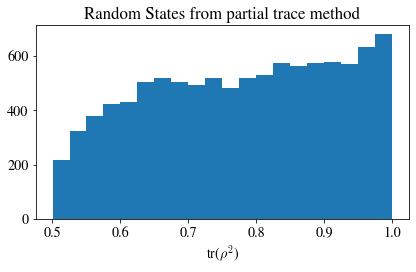

In [9]:
n = 10000
traces = np.array([random_rho(pure=False) for _ in range(n)])
traces = np.array([np.trace(rho.dot(rho)) for rho in traces])
a=plt.hist(np.real(traces), bins=20)
a=plt.xlabel('tr($\\rho^2$)')
a=plt.title('Random States from partial trace method')

# if NQ == 1:
#     n = 10000
#     traces = np.array([bloch2mat(random_bloch(pure=False)) for _ in range(n)])
#     traces = np.array([np.trace(rho.dot(rho)) for rho in traces])
#     a=plt.hist(np.real(traces), bins=20)
#     a=plt.xlabel('tr($\\rho^2$)')
#     a=plt.title('Random States from bloch vector method')

In [10]:
# Retrieve independent values from density matrix

## Treat complex numbers as 2 independent floating numbers for processing in network
## Processing complex units is not yet implemented to pytorch

def rho2torch(rho):
    dim = 2**NQ
    rho = rho.reshape(dim, dim)
    diags = np.array([np.real(rho[i,i]) for i in range(dim-1)])
    ur = np.array([])
    for i in range(dim-1):
        ur = np.hstack((ur, rho[i][i+1:dim]))
    ur = np.hstack((np.real(ur), np.imag(ur)))
    return np.hstack((diags, ur))

def torch2rho(tensor):
    dim = 2**NQ
    diag_coeff = np.array(tensor[:dim-1])
    norm_coeff = 1 - np.sum(diag_coeff)
    diags = np.hstack((diag_coeff, norm_coeff))
    diags = np.diag(diags)

    num_ur_entries = np.sum(np.arange(dim))
    ur_real = tensor[dim-1:dim-1+num_ur_entries]
    ur_imag = tensor[dim-1+num_ur_entries:]

    ur = np.zeros((dim,dim), dtype='complex64')
    for i in range(num_ur_entries):
        for j in range(i+1, dim):
            ur[i,j] = ur_real[0] + 1.j* ur_imag[0]
            ur_real = np.delete(ur_real, 0)
            ur_imag = np.delete(ur_imag, 0)
    return diags + ur + ur.T.conjugate()

# Test
astate = np.round(random_rho(pure=False), NQ)
bstate = torch2rho(rho2torch(astate))

print("Do rho and rho2torch2rho coincide?")
np.all((astate - bstate) < 1e10)

Do rho and rho2torch2rho coincide?


True

# Measurement
using random states generated by partial trace method

## Create random set of observables

Goal: overcomplete measurements that allow full determination of rho from random observables

In [11]:
def create_random_obs(pure, n=100):
    return np.array([random_rho(pure=pure) for _ in range(n)])

def perform_measurements(rho, observables):
    return np.real( np.trace(observables.dot(rho), axis1=1, axis2=2) )

mean = 0.4989916580219917
std = 0.11748673020163139


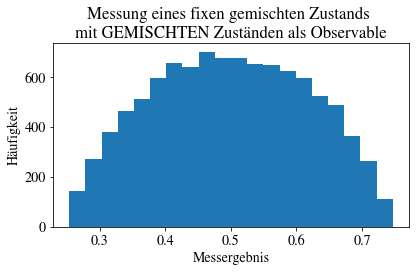

In [12]:
base_state = random_rho(pure=False)
observables = create_random_obs(pure=False, n=10000)

meas = perform_measurements(base_state, observables)
print('mean =', meas.mean())
print('std =', meas.std())

a=plt.hist(meas, bins=20)
a=plt.title('Messung eines fixen gemischten Zustands \nmit GEMISCHTEN Zuständen als Observable')
a=plt.xlabel('Messergebnis')
a=plt.ylabel('Häufigkeit')
#a=plt.xlim(0,1)

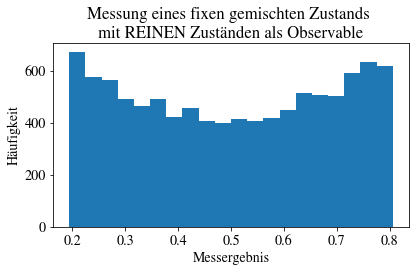

In [13]:
base_state = random_rho(pure=False)
observables = create_random_obs(pure=True, n=10000)

meas = perform_measurements(base_state, observables)


a=plt.hist(meas, bins=20)
a=plt.title('Messung eines fixen gemischten Zustands \nmit REINEN Zuständen als Observable')
a=plt.xlabel('Messergebnis')
a=plt.ylabel('Häufigkeit')

## Create Dataset

with same observables!

In [149]:
# Set parameters for new dataset
n_states = int(5e4)
exp_title = 'tomoAE2Q'
obs_arr = [30]

In [150]:
# Generate folders
experiment_name = exp_title + f'_{NQ}qubit_'+ state_gen_method
if not os.path.isdir('./data/' + experiment_name):
    os.mkdir('./data/' + experiment_name)

for nobs in tqdm(obs_arr):
  for _ in range(10):
    n_observables = nobs
    observables = create_random_obs(pure=True, n=n_observables)
    states = np.array([random_rho(pure=False) for _ in range(n_states)])
    states_freeparams = np.array([rho2torch(rho) for rho in states])    # Reduce rho to free parameters


    # Write out dataset

    timestamp = dtime.now().strftime("%Y%m%d_%H%M%S")
    PARENTPATH = f"./data/"+ experiment_name + f'/states{n_states}_obs{n_observables}/'
    DATAPATH = PARENTPATH+f"run_{timestamp}/"
    if not os.path.isdir(PARENTPATH):
      os.mkdir(PARENTPATH)
    os.mkdir(DATAPATH)

    # Write out states
    with open(DATAPATH + 'states_freeparams.csv', 'w') as f:
      writer = csv.writer(f)
      for state in tqdm(states_freeparams):
        a=writer.writerow(state)
        
    # Write out observables
    with open(DATAPATH + 'observables.csv', 'w') as f:
      writer = csv.writer(f)
      for obs in tqdm(observables):
        a=writer.writerow(obs.reshape(4**(NQ)))

    # Write out measurements 
    with open(DATAPATH + 'measurements.csv', 'w') as f:
      writer = csv.writer(f)
      for state in tqdm(states):
        a=writer.writerow(perform_measurements(state, observables))

    # Wait a sec so the next dataset gets a new name
    time.sleep(1)



100%|██████████| 1/1 [02:41<00:00, 161.91s/it]


# FFN Tomography

### Prepare dataset

In [16]:
class QuantumMeasurementDataset(Dataset):
    def __init__(self, root_dir):
        self.measurements_frame = pd.read_csv(root_dir + 'measurements.csv', header=None)
        self.states_frame = pd.read_csv(root_dir + 'states_freeparams.csv', header=None)

    def __len__(self):
        return len(self.states_frame)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        measurement = self.measurements_frame.iloc[idx]
        measurement = np.array(measurement).astype('float')
        measurement = torch.Tensor(measurement)

        state = self.states_frame.iloc[idx]
        state = np.array(state).astype('float')
        state = torch.Tensor(state)

        return measurement, state


In [17]:
def load_dataset(datadir, nstat, BATCH_SIZE = 64, splits = np.array([0.8, 0.1, 0.1])):
    # Train_valid_treasure split
    assert np.sum(splits) == 1

    tomography_dataset = QuantumMeasurementDataset(root_dir=datadir)
    tomography_train_dataset, tomography_valid_dataset, tomography_treasure_dataset = torch.utils.data.random_split(\
        tomography_dataset, (nstat*splits).astype(int), generator=torch.Generator().manual_seed(42))

    # Create data loaders from the datasets for the current task
    # Setting drop_last=True does not consider the last batch in which there are less than BATCH_SIZE examples
    tomography_train_dataloader = DataLoader(tomography_train_dataset, batch_size=BATCH_SIZE, shuffle=False, drop_last=True)
    tomography_valid_dataloader = DataLoader(tomography_valid_dataset, batch_size=BATCH_SIZE, shuffle=False, drop_last=True)
    tomography_treasure_dataloader = DataLoader(tomography_treasure_dataset, batch_size=BATCH_SIZE, shuffle=False, drop_last=True)
    return tomography_train_dataloader, tomography_valid_dataloader, tomography_treasure_dataloader 

## Feed Forward Network

Measurement outcomes --> bloch representation of state

In [18]:
# Check if the GPU is available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [19]:
class FeedForwardNet(nn.Module):

  def __init__(self, n_obs):
    super().__init__()

    self.dof = 4**NQ - 1
    self.layer_sizes = [n_obs, 64, 32]
    
    self.layers = nn.Sequential(
    nn.Linear(self.layer_sizes[0], self.layer_sizes[1]),
    nn.ReLU(),
    nn.Linear(self.layer_sizes[1], self.layer_sizes[2]),
    nn.ReLU(),
    nn.Linear(self.layer_sizes[2], self.dof),
    )

  def forward(self, x):
    return self.layers(x)

## Training

In [20]:
def evaluate_mse_ffn(net, dataloader, criterion, device):
    batch_loss = np.array([])
    for batch in dataloader:
        measurements, target = batch[0].to(device), batch[1].to(device)
        outputs = net(measurements)
        loss = criterion(outputs, target).clone().detach().cpu().numpy()
        batch_loss = np.append(batch_loss, loss)
    return np.mean(batch_loss)

In [21]:
# Function for training the network
def train(net, train_epochs, train_dataloader, valid_dataloader, optimizer, criterion):

    train_losses = np.array([])
    valid_losses = np.array([])

    for epoch in trange(train_epochs):
        net.train()
        for batch_idx, samples in enumerate(train_dataloader):
            data, target = samples[0].to(device), samples[1].to(device)
            # Optimize parameters
            net.zero_grad()
            outputs = net(data)
            loss = criterion(outputs, target)
            loss.backward()
            optimizer.step()
            train_losses = np.append(train_losses, loss.clone().detach().cpu().numpy())

            # Check loss on validation set
            valid_losses = np.append(valid_losses, evaluate_mse_ffn(net, valid_dataloader, criterion, device))
    return train_losses, valid_losses

In [22]:
def plot_train_stats(train_losses, valid_losses, it_per_epoch, path):
    a=plt.figure(figsize=(10,4))
    a=plt.plot(train_losses, lw=2, label='Training Loss on current batch')
    a=plt.xlabel('Iterations')
    a=plt.ylabel('Loss')
    a=plt.yscale('log')
    a=plt.legend()
    a=plt.title(f'Loss on training set \t (MSE, 1 epoch = {it_per_epoch} iterations)')
    a=plt.savefig(path + '/train_losses.png', dpi=150)
    plt.show()

    a=plt.figure(figsize=(10,4))
    a=plt.plot(valid_losses, lw=2, label='Validation Loss on full validation set')
    a=plt.xlabel('Iterations')
    a=plt.ylabel('Loss')
    a=plt.yscale('log')
    a=plt.legend()
    a=plt.title(f'Loss on Validation set  \t (MSE, 1 epoch = {it_per_epoch} iterations)')
    a=plt.savefig(path + '/valid_losses.png', dpi=150)
    plt.show()

In [23]:
def ffn_wrapper(data_dir, model_title, nstat, nobs, nepochs, learning_rate, batch_size, splits = np.array([0.8, 0.1, 0.1])):
    run_name = re.search('([^\/]+$)', data_dir[:-1]).group(0)
    tomography_train_dataloader, tomography_valid_dataloader, _ = load_dataset(data_dir, nstat, batch_size, splits)

    # Create the network on the CPU/GPU
    net = FeedForwardNet(n_obs=nobs).to(device)
    print(net)

    # Loss function and optimizer
    criterion = nn.MSELoss()
    optimizer = optim.Adam(net.parameters(), lr=learning_rate)

    # Perform Training
    train_losses, valid_losses = train(net, nepochs, tomography_train_dataloader, tomography_valid_dataloader, optimizer, criterion)

    # Save Model
    path = f'./models/FFN_states{int(nstat)}_obs{nobs}_epochs{nepochs}_lr{learning_rate}_{model_title}_{run_name}'
    if not os.path.isdir(path): os.mkdir(path)
    torch.save(net.state_dict(), path + '/model.model')

    # Plot training statistics
    plot_train_stats(train_losses, valid_losses, it_per_epoch = len(tomography_train_dataloader), path=path)


In [24]:
def train_multiple_runs(dataexp_path, model_title, nstat, obs_arr, bs, lr, nepochs):
    hyperparameter_dir = [f'states{int(nstat)}_obs{n_obs}' for n_obs in obs_arr]
    for nobs, hdir in zip(obs_arr, hyperparameter_dir):
        hpath = dataexp_path + '/' + hdir
        run_directories = [f for f in os.listdir(hpath) if os.path.isdir(os.path.join(hpath, f))]
        for rdir in run_directories:
            run_path = hpath + '/' + rdir + '/'
            ffn_wrapper(data_dir = run_path,
                        model_title=model_title,
                        nstat=nstat,
                        nobs=nobs,
                        nepochs=nepochs,
                        learning_rate=lr, 
                        batch_size=bs, 
                        splits = np.array([0.8, 0.1, 0.1]))

In [25]:
# 2 Qubits Test

# ffn_wrapper(data_dir='./data/tomo0607_2qubit_random_uniform_vector/states50000_obs15/run_20220609_123504/',
#             model_title='2qubit_ConstLatentDim',
#             nstat=5e4,
#             nobs=15,
#             nepochs=10,
#             learning_rate=1e-2,
#             batch_size=128,
#             splits=np.array([0.8, 0.1, 0.1]))

In [26]:
# train_multiple_runs(dataexp_path='./data/tomo0607_2qubit_random_uniform_vector',
#                     model_title='ConstLatentDimension',
#                     nstat=int(1e4), 
#                     obs_arr=np.array([12, 15, 20]), 
#                     bs=64,
#                     lr=1e-3,
#                     nepochs=15)

## Evaluation

performance on unseen data (treasure set)

comparison between untrained and trained net

### Single Model


In [27]:
nstat = int(1e4)
nobs = 3
model_path = './models/FFN_states10000_obs3_epochs1_lr0.001_ConstLatentDimension_run_20220604_092932'
data_path = './data/tomo0604_1qubit_random_uniform_vector/states10000_obs3/run_20220604_092923'

In [28]:
load_net = FeedForwardNet(n_obs=nobs).to(device)
load_net.load_state_dict(torch.load(model_path+'/model.model'))
_, _, tomography_treasure_dataloader = load_dataset(datadir=data_path+'/', nstat=nstat)

print('Mean Square Error of on unseen data')
untrained_net = FeedForwardNet(n_obs=nobs).to(device)
print('Untrained Net: ', evaluate_mse_ffn(
    untrained_net, tomography_treasure_dataloader,nn.MSELoss(),device))
print('Trained Net: ', evaluate_mse_ffn(
    load_net, tomography_treasure_dataloader, nn.MSELoss(), device))

FileNotFoundError: [Errno 2] No such file or directory: './models/FFN_states10000_obs3_epochs1_lr0.001_ConstLatentDimension_run_20220604_092932/model.model'

### Evaluate Multiple
Load trained models for different numbers of observables and evaluate their error on the ```tomography_treasure_dataloader```

model_performance -> run performance -> performances

In [29]:
def treasure_evaluation(nobservables, model_path, dataloader):
    load_net = FeedForwardNet(n_obs=nobservables).to(device)
    load_net.load_state_dict(torch.load(model_path+'/model.model'))

    return evaluate_mse_ffn(load_net, dataloader, nn.MSELoss(), device)

def evaluate_multiple(dataexp_path, model_title, nstat, obs_arr, num_runs, return_run_names=False):

    performances = np.zeros((0, num_runs))
    run_names = np.array([])
    all_model_names = [f for f in os.listdir('./models') if model_title in f]
    for nobs in obs_arr:
        run_perf = np.array([])
        obs_model_names = [f for f in all_model_names if (f'obs{nobs}_' in f)]
        for mn in obs_model_names:
            model_path = './models/' + mn
            run_name = re.search('([^(run)]+$)', model_path).group(0)
            run_names = np.append(run_names, 'run'+run_name)
            data_path = dataexp_path + f'/states{int(nstat)}_obs{nobs}/run{run_name}/'
            try:
                _,_,treasure_dataloader = load_dataset(datadir=data_path, nstat=nstat)
                model_perf = treasure_evaluation(nobs, model_path, treasure_dataloader)
                run_perf = np.append(run_perf, model_perf)
            except:
                None
        performances = np.vstack((performances, run_perf))

    if return_run_names:
        return performances, run_names
    return performances

In [30]:
# Test
evaluate_multiple(dataexp_path='./data/tomo0604_1qubit_random_uniform_vector',
                    model_title='ConstLatentDimension',
                    nstat=1e4, 
                    obs_arr=[3,25],
                    num_runs=10)

## reproducible with single evaluation?
load_net = FeedForwardNet(n_obs=25).to(device)
modelpath = './models/FFN_states10000_obs25_epochs15_lr0.001_ConstLatentDimension_run_20220604_092917/model.model'
load_net.load_state_dict(torch.load(modelpath))

datapath = '/Users/canrager/thesis/data/tomo0604_1qubit_random_uniform_vector/states10000_obs25/run_20220604_092917/'
_,_,tomography_treasure_dataloader = load_dataset(datadir=datapath, nstat=10000)

print('Trained Net: ', evaluate_mse_ffn(
    load_net, tomography_treasure_dataloader, nn.MSELoss(), device))

#OK

array([[1.38710470e-06, 1.09156212e-06, 2.73608124e-06, 1.24967878e-06,
        6.80751524e-06, 9.94751633e-03, 9.94973695e-06, 5.90379693e-07,
        4.90688762e-03, 9.63037598e-07],
       [1.91951681e-07, 9.52913903e-08, 2.70337826e-08, 5.56419909e-07,
        1.25396463e-07, 6.34967190e-07, 1.30610597e-07, 6.82767016e-08,
        1.57280345e-07, 1.10199762e-07]])

<All keys matched successfully>

Trained Net:  1.919516805060084e-07


In [31]:
# obs_arr = [3, 25, 50, 75, 100]

# performances = evaluate_multiple(dataexp_path='./data/tomo0604_1qubit_random_uniform_vector',
#                     model_title='ConstLatentDimension',
#                     nstat=1e4, 
#                     obs_arr=obs_arr,
#                     num_runs=10)
# performances
# perf_means = np.mean(performances, axis=1)
# perf_merr = np.std(performances, axis=1)/np.sqrt(10)

# plt.errorbar(obs_arr, perf_means, yerr=perf_merr)
# plt.xlabel('Number of PVMs')
# plt.ylabel('Mean squared error')
# plt.yscale('log')
# plt.grid()

### Evaluation for custom Projectors

In [32]:
def custom_obs_dataset(dataexp_title, n_states, observables, n_runs):
    for _ in range(n_runs):
        experiment_name = dataexp_title + f'_{NQ}qubit_'+ state_gen_method
        if not os.path.isdir('./data/' + experiment_name):
            os.mkdir('./data/' + experiment_name)
        states = np.array([random_rho(pure=False) for _ in range(n_states)])
        states_freeparams = np.array([rho2torch(rho) for rho in states])    # Reduce rho to free parameters

        # Write out dataset

        timestamp = dtime.now().strftime("%Y%m%d_%H%M%S")
        PARENTPATH = f"./data/"+ experiment_name + f'/states{n_states}_obs{len(observables)}/'
        DATAPATH = PARENTPATH+f"run_{timestamp}/"
        if not os.path.isdir(PARENTPATH):
            os.mkdir(PARENTPATH)
        os.mkdir(DATAPATH)

        # Write out states
        with open(DATAPATH + 'states_freeparams.csv', 'w') as f:
            writer = csv.writer(f)
            for state in tqdm(states_freeparams):
                a=writer.writerow(state)
            
        # Write out observables
        with open(DATAPATH + 'observables.csv', 'w') as f:
            writer = csv.writer(f)
            for obs in tqdm(observables):
                a=writer.writerow(obs.reshape(4**(NQ)))

        # Write out measurements 
        with open(DATAPATH + 'measurements.csv', 'w') as f:
            writer = csv.writer(f)
            for state in tqdm(states):
                a=writer.writerow(perform_measurements(state, observables))

        # Wait a sec so the next dataset gets a new name
        time.sleep(1)


In [33]:
# Pauli matrices
s1 = np.array([[0,1],[1,0]])
s2 = np.array([[0,-1j],[1j,0]])
s3 = np.array([[1,0],[0,-1]])

n_states = int(1e4)
observables = (np.eye(2) + np.array([s1,s2,s3]))/2
observables

array([[[0.5+0.j , 0.5+0.j ],
        [0.5+0.j , 0.5+0.j ]],

       [[0.5+0.j , 0. -0.5j],
        [0. +0.5j, 0.5+0.j ]],

       [[1. +0.j , 0. +0.j ],
        [0. +0.j , 0. +0.j ]]])

In [34]:
# obs_arr=[3]

# custom_obs_dataset( dataexp_title='tomo_PAULI_projectors',
#                     n_states=n_states,
#                     observables=observables,
#                     n_runs=10)

# train_multiple_runs(dataexp_path='./data/tomo_PAULI_projectors_1qubit_random_uniform_vector',
#                     model_title='PAULI_projectors',
#                     nstat=int(1e4), 
#                     obs_arr=obs_arr, 
#                     bs=64,
#                     lr=1e-3,
#                     nepochs=15)

In [35]:
arr = np.array([[7.98335289e-06, 6.53353397e-06, 5.29218610e-06, 6.94540422e-06,
        6.46792390e-06, 8.35120563e-06, 6.64965549e-06, 8.96846310e-06,
        6.51081403e-06, 1.02456272e-05]])

np.mean(arr)
np.std(arr)/np.sqrt(len(arr))

7.394816653e-06

1.3937442126118205e-06

In [36]:
performances = evaluate_multiple(dataexp_path='./data/tomo_PAULI_projectors_1qubit_random_uniform_vector',
                    model_title='PAULI_projectors',
                    nstat=1e4, 
                    obs_arr=[3],
                    num_runs=10)
performances
perf_means = np.mean(performances, axis=1)
perf_merr = np.std(performances, axis=1)/np.sqrt(10)

perf_means
perf_merr

array([[5.92338360e-07, 6.69251851e-07, 7.66845380e-07, 1.95457137e-06,
        2.90368794e-06, 3.38669370e-06, 1.23387836e-06, 1.40325354e-06,
        1.02425044e-06, 1.20175386e-06]])

array([1.51365248e-06])

array([2.86036729e-07])

### Comparison Plot

In [37]:
obs_arr = [3, 25, 50, 75, 100] + [1, 2, 4, 5, 7, 10, 15, 20, 30, 40, 60, 70, 80, 90]
len(obs_arr)

performances = evaluate_multiple(dataexp_path='./data/tomo0604_1qubit_random_uniform_vector',
                    model_title='ConstLatentDimension',
                    nstat=1e4, 
                    obs_arr=obs_arr,
                    num_runs=10)            
perf_means = np.mean(performances, axis=1)
perf_merr = np.std(performances, axis=1)/np.sqrt(10)

pauli_performances = evaluate_multiple(dataexp_path='./data/tomo_PAULI_projectors_1qubit_random_uniform_vector',
                    model_title='PAULI_projectors',
                    nstat=1e4, 
                    obs_arr=[3],
                    num_runs=10)
pauli_performances
pauli_mean = np.mean(pauli_performances) * np.ones(len(obs_arr))
pauli_merr = np.std(pauli_performances) / len(pauli_performances)

19

array([[5.92338360e-07, 6.69251851e-07, 7.66845380e-07, 1.95457137e-06,
        2.90368794e-06, 3.38669370e-06, 1.23387836e-06, 1.40325354e-06,
        1.02425044e-06, 1.20175386e-06]])

<Figure size 900x600 with 0 Axes>

<ErrorbarContainer object of 3 artists>

Text(0.5, 0, 'Anzahl PVMs')

Text(0, 0.5, 'Mittlerer quadratischer Fehler')

/var/folders/tn/nyh0947d6sngjfvtp7hbb0jr0000gn/T/ipykernel_5515/1995615041.py:10: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  plt.xlim(0,120)


(0.7871199821209824, 120)

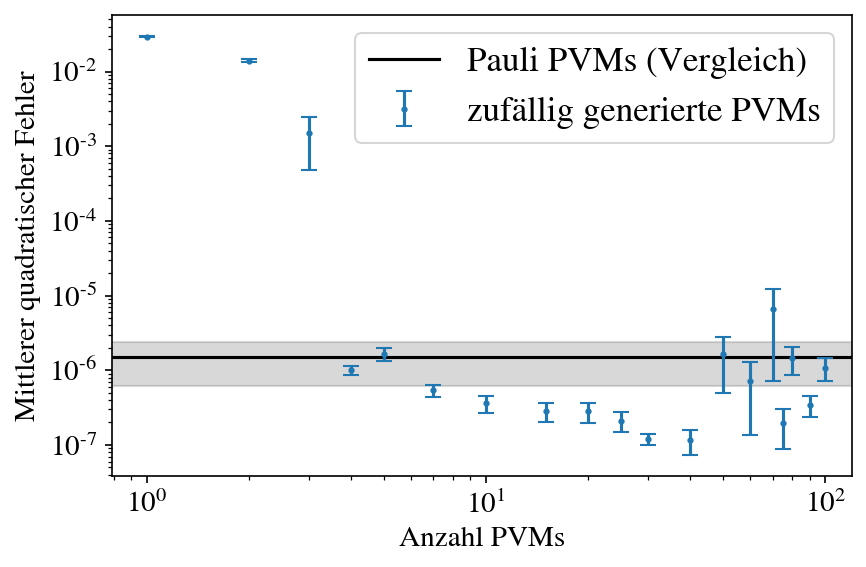

In [38]:
plt.figure(dpi=150)
plt.errorbar(obs_arr, perf_means, yerr=perf_merr, fmt = 'o', markersize = 2, capsize = 4,\
    label='zufällig generierte PVMs', zorder = 10)
plt.plot(np.linspace(0,120,len(obs_arr)), pauli_mean, c='k', label='Pauli PVMs (Vergleich)')
plt.fill_between(np.linspace(0,120,len(obs_arr)), pauli_mean-pauli_merr, pauli_mean + pauli_merr, color='grey', alpha=.3)
plt.xlabel('Anzahl PVMs')
plt.ylabel('Mittlerer quadratischer Fehler')
plt.yscale('log')
plt.xscale('log')
plt.xlim(0,120)

plt.legend()#loc='center left', bbox_to_anchor=(1,0.5))

<Figure size 900x600 with 0 Axes>

Text(0.5, 0, 'Messung Nr.')

Text(0, 0.5, 'Mittlerer quadratischer Fehler')

(0.75, 10.25)

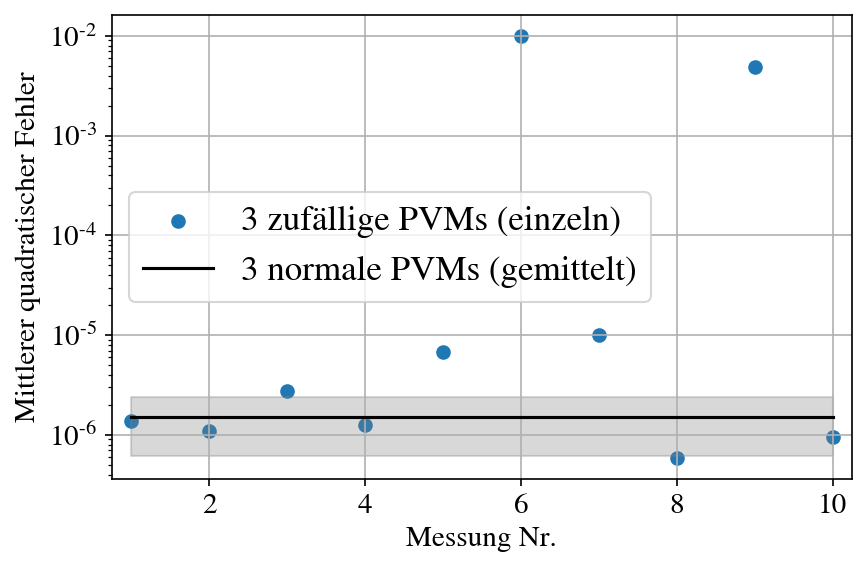

In [39]:
xspace = np.arange(1,len(performances[0])+1)
pauli_mean = np.mean(pauli_performances) * np.ones(len(performances[0]))

plt.figure(dpi=150)
plt.scatter(xspace, performances[0], label='3 zufällige PVMs (einzeln)')
plt.plot(xspace, pauli_mean, c='k', label='3 normale PVMs (gemittelt)')
plt.fill_between(xspace, pauli_mean-pauli_merr, pauli_mean + pauli_merr, color='grey', alpha=.3)
plt.xlabel('Messung Nr.')
plt.ylabel('Mittlerer quadratischer Fehler')
plt.yscale('log')
plt.legend(loc='center left')
plt.xlim(.75, 10.25)
plt.grid()

0.0

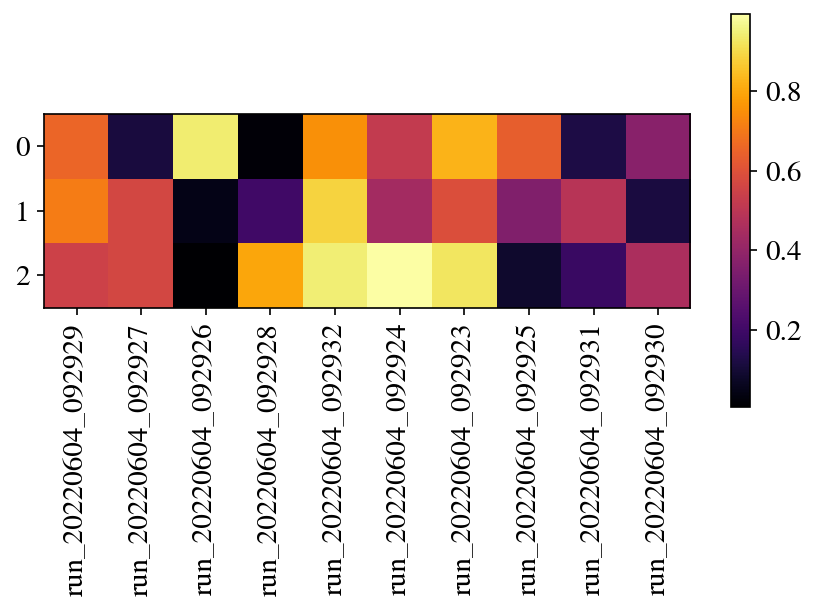

array([['1.3871047030988848e-06', 'run_20220604_092929'],
       ['1.0915621184418948e-06', 'run_20220604_092927'],
       ['2.736081235828654e-06', 'run_20220604_092926'],
       ['1.249678780368413e-06', 'run_20220604_092928'],
       ['6.807515243660116e-06', 'run_20220604_092932'],
       ['0.00994751633455356', 'run_20220604_092924'],
       ['9.949736947116132e-06', 'run_20220604_092923'],
       ['5.90379693221621e-07', 'run_20220604_092925'],
       ['0.004906887623171012', 'run_20220604_092931'],
       ['9.630375984670537e-07', 'run_20220604_092930']], dtype='<U32')

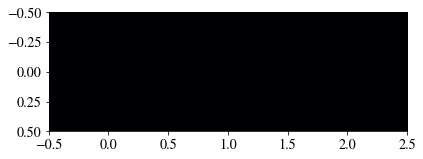

In [40]:
# Printe observablen der nPVM = 3 messungen

performances, run_names = evaluate_multiple(dataexp_path='./data/tomo0604_1qubit_random_uniform_vector',
                    model_title='ConstLatentDimension',
                    nstat=1e4, 
                    obs_arr=[3],
                    num_runs=10,
                    return_run_names=True) 

def retrieve_observables(data_path, run_directories):
    observables = np.empty((0,3,2,2))
    for rdir in run_directories:
        run_path = data_path + '/' + rdir + '/'
        dim = 2**NQ
        data_obs = np.zeros((0,dim,dim))
        with open(run_path+'/observables.csv', 'r') as f:
            reader = csv.reader(f)
            for line in reader:
                data_obs = np.vstack((data_obs, np.array([np.array(line).reshape(dim,dim).astype('complex128')])))
        observables = np.vstack((observables, [data_obs]))
    return observables, run_directories



observables, run_directories =retrieve_observables('/Users/canrager/thesis/data/tomo0604_1qubit_random_uniform_vector/states10000_obs3',
    run_names)
fidelities = np.array([np.array([np.trace(a.dot(b)), np.trace(c.dot(b)), np.trace(a.dot(c))]) for a,b,c in observables])
np.sum(np.imag(fidelities))
fidelities = np.real(fidelities)

#Colorbar
fig, ax = plt.subplots(dpi=150)
cmap = cm.get_cmap('inferno')
norm = Normalize(vmin=np.min(fidelities), vmax=np.max(fidelities))
colors = cmap(norm(1))
a=sc = cm.ScalarMappable(cmap=cmap,norm=norm)
a=sc.set_array([])
a=plt.colorbar(sc)

ax.imshow(fidelities.T,cmap=cmap)
ax.set_xticks(np.arange(10), run_directories, rotation='vertical')
plt.show()

np.vstack((performances.flatten(),run_names)).T

pauli_fidelities = np.real(np.array([[np.trace(s1.dot(s2)), np.trace(s1.dot(s3)), np.trace(s2.dot(s3))]]))

plt.imshow(pauli_fidelities, cmap=cmap)

In [41]:
a,b,c = observables[0]
np.trace(a.dot(b.dot(c)))
c


(0.45673096515319794+0.21531036005094847j)

array([[0.56389221+0.j        , 0.49432582+0.03949387j],
       [0.49432582-0.03949387j, 0.43610779+0.j        ]])

#### 2 Qubit

In [42]:
performances = evaluate_multiple(dataexp_path='./data/tomo0607_2qubit_random_uniform_vector',
                    model_title='ConstLatentDimension',
                    nstat=1e4, 
                    obs_arr=[12,15,20],
                    num_runs=10)
performances

perf_means = np.mean(performances, axis=1)
perf_merr = np.std(performances, axis=1)/np.sqrt(10)

perf_means
perf_merr

perf15 = performances[1]


ValueError: all the input array dimensions for the concatenation axis must match exactly, but along dimension 1, the array at index 0 has size 10 and the array at index 1 has size 0

In [43]:
pauli1q = np.array([np.eye(2), s1, s2, s3])
pauli2q = np.zeros((0, 4, 4))
for a in pauli1q:
    for b in pauli1q:
        pauli2q = np.vstack((pauli2q, [np.kron(a,b)]))

pauli2q_projectors = (np.eye(4) + pauli2q[1:])/2
n_states=10000


In [46]:
# custom_obs_dataset( dataexp_title='tomo_2qubit_PAULI2_projectors',
#                     n_states=n_states,
#                     observables=pauli2q_projectors,
#                     n_runs=10)

In [47]:
# train_multiple_runs(dataexp_path='./data/tomo_2qubit_PAULI2_projectors_2qubit_random_uniform_vector',
#                     model_title='2qubit_PAULI2_projectors',
#                     nstat=n_states, 
#                     obs_arr=[15], 
#                     bs=64,
#                     lr=1e-3,
#                     nepochs=15)

In [49]:
# pauli_performances = evaluate_multiple(dataexp_path='./data/tomo_PAULI_projectors_1qubit_random_uniform_vector',
#                     model_title='2qubit_PAULI2_projectors',
#                     nstat=1e4, 
#                     obs_arr=[3],
#                     num_runs=10)
# pauli_performances
# pauli_mean = np.mean(pauli_performances) * np.ones(len(obs_arr))
# pauli_merr = np.std(pauli_performances) / len(pauli_performances)

## Inference

In [50]:
nobs = 3
model_path = './models/FFN_states10000_obs3_epochs15_lr0.001_ConstLatentDimension_run_20220604_092923'
data_path = './data/tomo0604_1qubit_random_uniform_vector/states10000_obs3/run_20220604_092923'

In [51]:
# Load Model
load_net = FeedForwardNet(n_obs=nobs).to(device)
load_net.load_state_dict(torch.load(model_path+'/model.model'))

# Import Observables
dim = 2**NQ
data_obs = np.zeros((0,dim,dim))
with open(data_path+'/observables.csv', 'r') as f:
  reader = csv.reader(f)
  for line in tqdm(reader):
    data_obs = np.vstack((data_obs, np.array([np.array(line).reshape(dim,dim).astype('complex128')])))

<All keys matched successfully>

3it [00:00, 2557.50it/s]


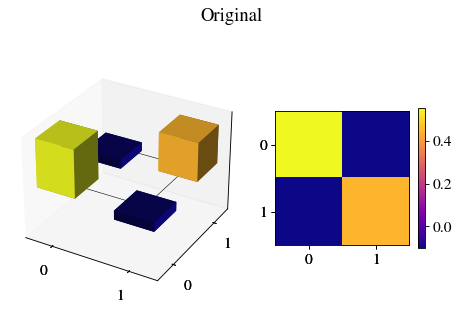

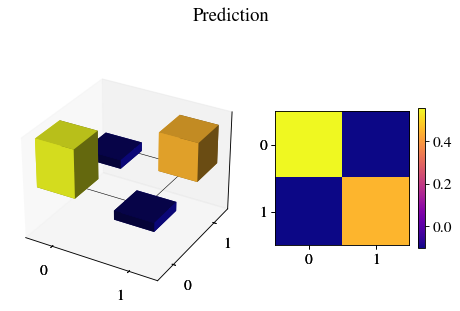

In [52]:
rho_infer = random_rho(pure=False)
m_infer = torch.Tensor(perform_measurements(rho_infer, data_obs))
freeparam_pred = load_net.forward(m_infer.to(device)).detach().cpu().numpy()
rho_pred = torch2rho(freeparam_pred)

plot_dm(np.real(rho_infer), title='Original')
plot_dm(np.real(rho_pred), title='Prediction')

# AE Compact State Representations

## Autoencoder

In [53]:
class AutoencoderNet(nn.Module):

  def __init__(self, latent_dim, measurement_dim):
    super().__init__()

    self.layer1_size = 64
    self.layer2_size = 32

    self.encoder = nn.Sequential(
    nn.Linear(measurement_dim, self.layer1_size),
    nn.ReLU(),
    nn.Linear(self.layer1_size, self.layer2_size),
    nn.ReLU(),
    nn.Linear(self.layer2_size, latent_dim),
    )

    self.decoder = nn.Sequential(
    nn.Linear(latent_dim, self.layer2_size),
    nn.ReLU(),
    nn.Linear(self.layer2_size, self.layer1_size),
    nn.ReLU(),
    nn.Linear(self.layer1_size, measurement_dim),
    )

  def forward(self, x):
    minrep = self.encoder(x)
    output = self.decoder(minrep)
    return output
  
  def encode(self, x):
    return self.encoder(x)

## Training

In [54]:
def evaluate_mse_ae(net, dataloader, criterion, device):
    batch_loss = np.array([])
    for batch in dataloader:
        measurements = batch[0].to(device)
        outputs = net(measurements)
        loss = criterion(outputs, measurements).clone().detach().cpu().numpy()
        batch_loss = np.append(batch_loss, loss)
    return np.mean(batch_loss)

In [55]:
# Function for training the network
def ae_train(net, train_epochs, train_dataloader, valid_dataloader, optimizer, criterion):

    train_losses = np.array([])
    valid_losses = np.array([])

    for epoch in trange(train_epochs):
        net.train()
        for batch_idx, samples in enumerate(train_dataloader):
            data, target = samples[0].to(device), samples[1].to(device)
            # Optimize parameters
            net.zero_grad()
            outputs = net(data)

            loss = criterion(outputs, data)
            

            loss.backward()
            optimizer.step()
            train_losses = np.append(train_losses, loss.clone().detach().cpu().numpy())

            # Check loss on validation set
            valid_losses = np.append(valid_losses, evaluate_mse_ae(net, valid_dataloader, criterion, device))

    return train_losses, valid_losses

In [56]:
def ae_train_eval(data_dir,
                  model_title,
                  nstat,
                  nobs,
                  latent_size, 
                  learning_rate, 
                  nepochs):

    print(data_dir,
                  model_title,
                  nstat,
                  nobs,
                  latent_size, 
                  learning_rate, 
                  nepochs)

    run_name = re.search('([^\/]+$)', data_dir[:-1]).group(0)
    train_dataloader, valid_dataloader, treasure_dataloader = load_dataset(data_dir+'/', nstat)

    # Create the network on the CPU/GPU
    ae_net = AutoencoderNet(measurement_dim=nobs, latent_dim=latent_size).to(device)
    print(ae_net)

    # Loss function and optimizer
    criterion = nn.MSELoss()
    optimizer = optim.Adam(ae_net.parameters(), lr=learning_rate)

    #Do training
    train_losses, valid_losses = ae_train(  ae_net, 
                                            nepochs, 
                                            train_dataloader, 
                                            valid_dataloader, 
                                            optimizer, 
                                            criterion)


    print(train_losses)
    # Log the loss on the unseen set                  
    treasure_loss = evaluate_mse_ae(ae_net, treasure_dataloader, criterion, device)

    # Save Model
    path = f'./models/AE_states{int(nstat)}_obs{nobs}_latentdim{latent_size}_epochs{nepochs}_lr{learning_rate}_{model_title}_{run_name}'
    if not os.path.isdir(path): os.mkdir(path)
    torch.save(ae_net.state_dict(), path + '/model.model')

    # Plot training statistics
    plot_train_stats(train_losses, valid_losses, it_per_epoch = len(train_dataloader), path=path)

    return treasure_loss


In [57]:
def ae_train_multiple_runs(data_path, model_title, latent_dims, nstat, nobs, lr, nepochs):
    performances = np.array([])

    run_directories = [f for f in os.listdir(data_path) if os.path.isdir(os.path.join(data_path, f))]
    for rdir in run_directories:
        run_path = data_path + '/' + rdir + '/'
        run_perf = np.array([])
        for ldim in latent_dims:
            perf = ae_train_eval(data_dir=run_path,
                            model_title=model_title,
                            nstat=nstat,
                            nobs=nobs,
                            latent_size=ldim, 
                            learning_rate=lr, 
                            nepochs=nepochs)
            print(perf)
            run_perf = np.append(run_perf, perf)
        performances = np.append(performances, run_perf)
    return performances

In [138]:
def ae_treasure_evaluation(nobservables, latent_size, model_path, dataloader):
    load_net = AutoencoderNet(measurement_dim=nobservables, latent_dim=latent_size).to(device)
    load_net.load_state_dict(torch.load(model_path+'/model.model'))

    return evaluate_mse_ae(load_net, dataloader, nn.MSELoss(), device)

In [143]:
dataexp_path='./data/tomo0607_2qubit_random_uniform_vector/states10000_obs100'
model_title='2qubit_FindMinDim'
latent_dims = [1, 5, 10, 12, 14, 15, 16, 18, 20, 25, 30]
performances = np.zeros((0, 10))


all_model_names = [f for f in os.listdir('./models') if model_title in f]
for ldim in tqdm(latent_dims):
    run_perf = np.array([])
    ldim_model_names = [f for f in all_model_names if f'_latentdim{ldim}_' in f]
    for mn in ldim_model_names:
        model_path = './models/' + mn
        run_name = re.search('([^(run)]+$)', model_path).group(0)
        run_names = np.append(run_names, 'run'+run_name)
        data_path = dataexp_path + f'/run{run_name}/'
        _,_,treasure_dataloader = load_dataset(datadir=data_path, nstat=nstat)
        model_perf = ae_treasure_evaluation(nobservables=100, latent_size=ldim, model_path = model_path, dataloader=treasure_dataloader)
        run_perf = np.append(run_perf, model_perf)
    performances = np.vstack((performances, run_perf))

performances

100%|██████████| 11/11 [00:30<00:00,  2.77s/it]


array([[0.00886221, 0.00907297, 0.00915554, 0.00859254, 0.00890918,
        0.00897835, 0.00907228, 0.00885096, 0.00875796, 0.00886317],
       [0.00482279, 0.00470919, 0.00485214, 0.00513662, 0.00495134,
        0.00498706, 0.00493493, 0.00480997, 0.00509261, 0.00443048],
       [0.00216485, 0.00220859, 0.00255596, 0.00247516, 0.00269533,
        0.00268427, 0.0033918 , 0.00322727, 0.00183808, 0.00260271],
       [0.0021672 , 0.00154351, 0.00147743, 0.00235613, 0.00118105,
        0.00212594, 0.00200985, 0.00208807, 0.00262802, 0.00267458],
       [0.00175894, 0.00150918, 0.00149782, 0.00162227, 0.00082837,
        0.00209386, 0.00215737, 0.00160523, 0.00218047, 0.00153244],
       [0.00228587, 0.00107573, 0.00149881, 0.00146094, 0.00270438,
        0.00250805, 0.00214659, 0.00144578, 0.00141753, 0.00207931],
       [0.00127092, 0.00225457, 0.00104895, 0.00149115, 0.00201406,
        0.00205598, 0.00099397, 0.00208241, 0.00098587, 0.00160958],
       [0.00172704, 0.00082577, 0.0009843

NameError: name 'perf_merrs' is not defined

<ErrorbarContainer object of 3 artists>

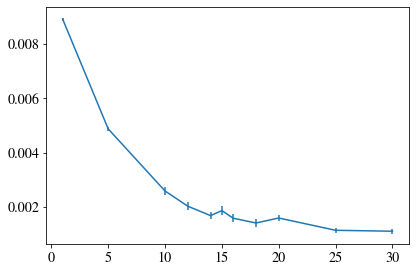

In [144]:
perf_means = np.mean(performances, axis=1)
perf_merrs = np.std(performances, axis=1)/np.sqrt(10)

plt.errorbar(latent_dims, perf_means, yerr=perf_merrs)

In [ ]:
for nobs in obs_arr:
        run_perf = np.array([])
        obs_model_names = [f for f in all_model_names if (f'obs{nobs}_' in f)]
        for mn in obs_model_names:
            model_path = './models/' + mn
            run_name = re.search('([^(run)]+$)', model_path).group(0)
            run_names = np.append(run_names, 'run'+run_name)
            data_path = dataexp_path + f'/states{int(nstat)}_obs{nobs}/run{run_name}/'
            try:
                _,_,treasure_dataloader = load_dataset(datadir=data_path, nstat=nstat)
                model_perf = treasure_evaluation(nobs, model_path, treasure_dataloader)
                run_perf = np.append(run_perf, model_perf)
            except:
                None
        performances = np.vstack((performances, run_perf))

In [58]:
# ae_perf = ae_train_multiple_runs(data_path='./data/tomo0604_1qubit_random_uniform_vector/states10000_obs100',
#                                     model_title='FindMinDim', 
#                                     latent_dims=[1, 5, 10, 12, 14, 15, 16, 18, 20, 25, 30], 
#                                     nstat=1e4, 
#                                     nobs=100, 
#                                     lr=1e-3, 
#                                     nepochs=20)

### 2 Qubit training

In [59]:
1500/125

12.0

./data/tomo0607_2qubit_random_uniform_vector/states10000_obs100/run_20220609_120754/ AE2Q_kleiner 10000.0 100 1 0.05 12
AutoencoderNet(
  (encoder): Sequential(
    (0): Linear(in_features=100, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=1, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=1, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=100, bias=True)
  )
)


100%|██████████| 12/12 [01:23<00:00,  6.99s/it]
/var/folders/tn/nyh0947d6sngjfvtp7hbb0jr0000gn/T/ipykernel_5515/863207960.py:9: UserWarning: Glyph 9 (	) missing from current font.
  a=plt.savefig(path + '/train_losses.png', dpi=150)


[0.08749638 0.10391272 0.02217809 ... 0.01143443 0.01032011 0.01179848]


/Users/canrager/.pyenv/versions/3.9.11/envs/thenv/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


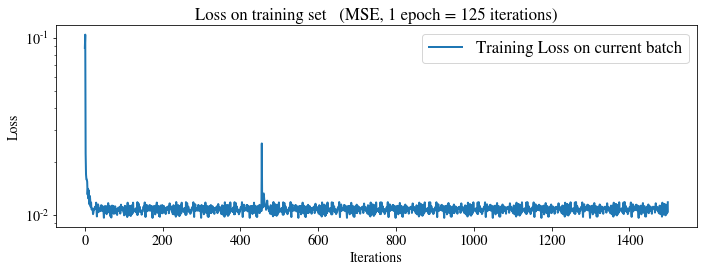

/var/folders/tn/nyh0947d6sngjfvtp7hbb0jr0000gn/T/ipykernel_5515/863207960.py:19: UserWarning: Glyph 9 (	) missing from current font.
  a=plt.savefig(path + '/valid_losses.png', dpi=150)
/Users/canrager/.pyenv/versions/3.9.11/envs/thenv/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


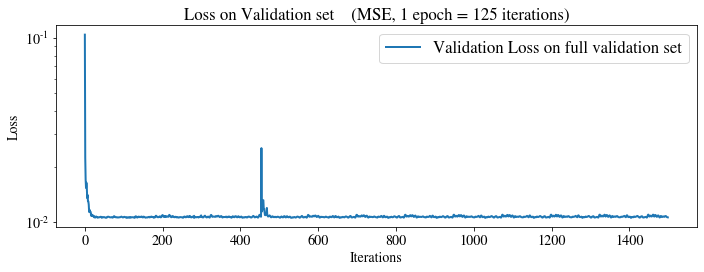

0.010451503035922845
./data/tomo0607_2qubit_random_uniform_vector/states10000_obs100/run_20220609_120754/ AE2Q_kleiner 10000.0 100 5 0.05 12
AutoencoderNet(
  (encoder): Sequential(
    (0): Linear(in_features=100, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=5, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=5, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=100, bias=True)
  )
)


100%|██████████| 12/12 [01:23<00:00,  6.94s/it]
/var/folders/tn/nyh0947d6sngjfvtp7hbb0jr0000gn/T/ipykernel_5515/863207960.py:9: UserWarning: Glyph 9 (	) missing from current font.
  a=plt.savefig(path + '/train_losses.png', dpi=150)


[0.08074485 0.46861419 0.04471111 ... 0.01142959 0.01028976 0.01175302]


/Users/canrager/.pyenv/versions/3.9.11/envs/thenv/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


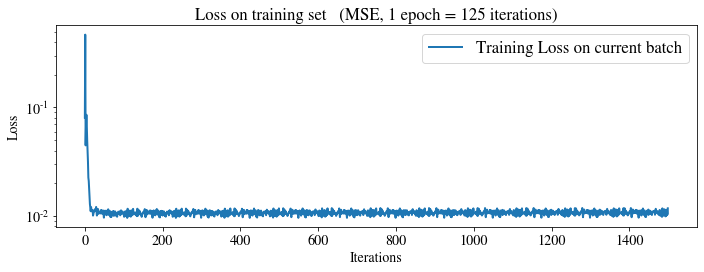

/var/folders/tn/nyh0947d6sngjfvtp7hbb0jr0000gn/T/ipykernel_5515/863207960.py:19: UserWarning: Glyph 9 (	) missing from current font.
  a=plt.savefig(path + '/valid_losses.png', dpi=150)
/Users/canrager/.pyenv/versions/3.9.11/envs/thenv/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


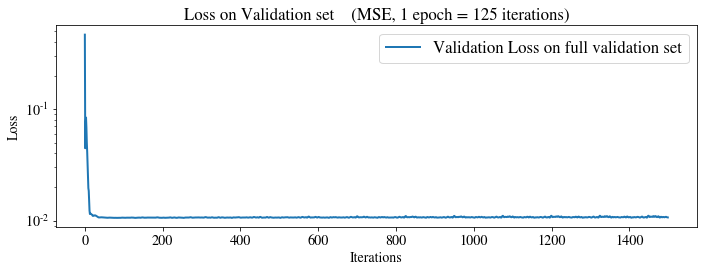

0.010438293963670731
./data/tomo0607_2qubit_random_uniform_vector/states10000_obs100/run_20220609_120754/ AE2Q_kleiner 10000.0 100 10 0.05 12
AutoencoderNet(
  (encoder): Sequential(
    (0): Linear(in_features=100, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=10, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=10, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=100, bias=True)
  )
)


100%|██████████| 12/12 [01:23<00:00,  6.93s/it]
/var/folders/tn/nyh0947d6sngjfvtp7hbb0jr0000gn/T/ipykernel_5515/863207960.py:9: UserWarning: Glyph 9 (	) missing from current font.
  a=plt.savefig(path + '/train_losses.png', dpi=150)


[0.08351736 0.0599355  0.02296783 ... 0.01143365 0.01033062 0.01180847]


/Users/canrager/.pyenv/versions/3.9.11/envs/thenv/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


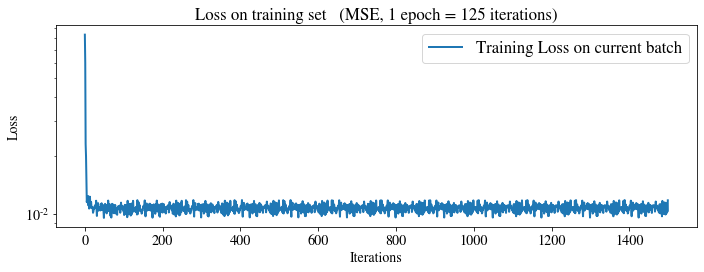

/var/folders/tn/nyh0947d6sngjfvtp7hbb0jr0000gn/T/ipykernel_5515/863207960.py:19: UserWarning: Glyph 9 (	) missing from current font.
  a=plt.savefig(path + '/valid_losses.png', dpi=150)
/Users/canrager/.pyenv/versions/3.9.11/envs/thenv/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


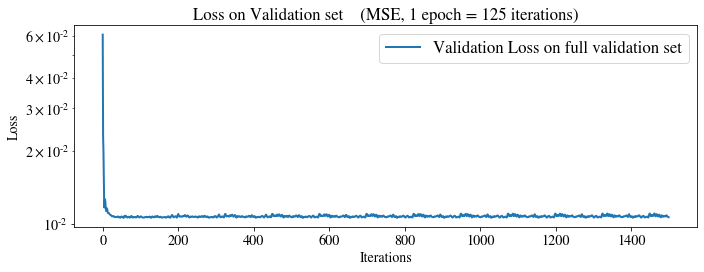

0.010456718504428864
./data/tomo0607_2qubit_random_uniform_vector/states10000_obs100/run_20220609_120754/ AE2Q_kleiner 10000.0 100 12 0.05 12
AutoencoderNet(
  (encoder): Sequential(
    (0): Linear(in_features=100, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=12, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=12, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=100, bias=True)
  )
)


100%|██████████| 12/12 [01:23<00:00,  6.92s/it]


[0.07438323 0.30995372 0.0397369  ... 0.011417   0.0103051  0.01177576]


/var/folders/tn/nyh0947d6sngjfvtp7hbb0jr0000gn/T/ipykernel_5515/863207960.py:9: UserWarning: Glyph 9 (	) missing from current font.
  a=plt.savefig(path + '/train_losses.png', dpi=150)
/Users/canrager/.pyenv/versions/3.9.11/envs/thenv/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


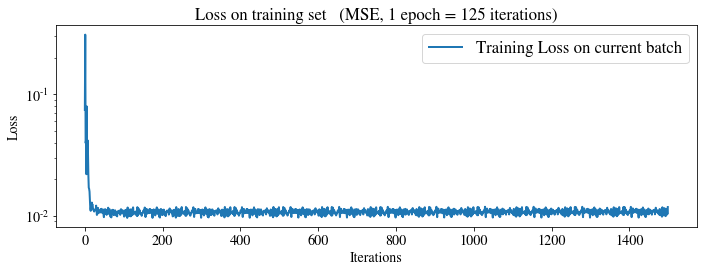

/var/folders/tn/nyh0947d6sngjfvtp7hbb0jr0000gn/T/ipykernel_5515/863207960.py:19: UserWarning: Glyph 9 (	) missing from current font.
  a=plt.savefig(path + '/valid_losses.png', dpi=150)
/Users/canrager/.pyenv/versions/3.9.11/envs/thenv/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


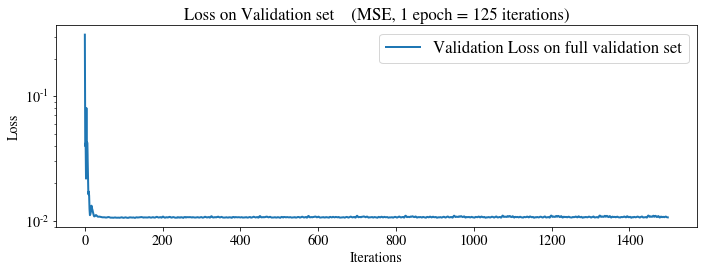

0.010444315833350022
./data/tomo0607_2qubit_random_uniform_vector/states10000_obs100/run_20220609_120754/ AE2Q_kleiner 10000.0 100 14 0.05 12
AutoencoderNet(
  (encoder): Sequential(
    (0): Linear(in_features=100, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=14, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=14, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=100, bias=True)
  )
)


100%|██████████| 12/12 [01:23<00:00,  6.92s/it]
/var/folders/tn/nyh0947d6sngjfvtp7hbb0jr0000gn/T/ipykernel_5515/863207960.py:9: UserWarning: Glyph 9 (	) missing from current font.
  a=plt.savefig(path + '/train_losses.png', dpi=150)


[0.07733639 0.03651204 0.02211896 ... 0.01143294 0.01033457 0.0118145 ]


/Users/canrager/.pyenv/versions/3.9.11/envs/thenv/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


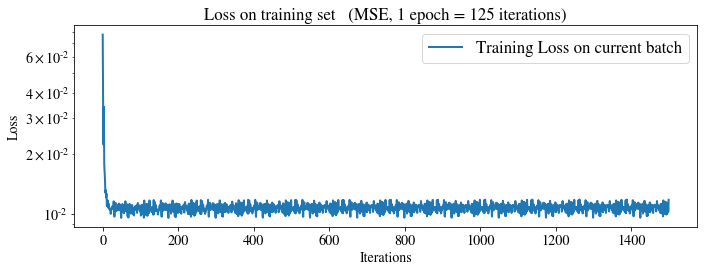

/var/folders/tn/nyh0947d6sngjfvtp7hbb0jr0000gn/T/ipykernel_5515/863207960.py:19: UserWarning: Glyph 9 (	) missing from current font.
  a=plt.savefig(path + '/valid_losses.png', dpi=150)
/Users/canrager/.pyenv/versions/3.9.11/envs/thenv/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


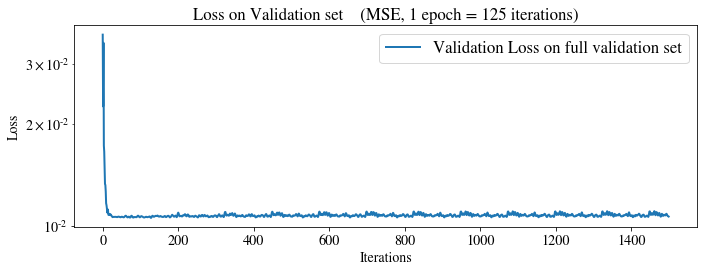

0.010455443648000558
./data/tomo0607_2qubit_random_uniform_vector/states10000_obs100/run_20220609_120754/ AE2Q_kleiner 10000.0 100 15 0.05 12
AutoencoderNet(
  (encoder): Sequential(
    (0): Linear(in_features=100, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=15, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=15, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=100, bias=True)
  )
)


100%|██████████| 12/12 [01:23<00:00,  6.92s/it]
/var/folders/tn/nyh0947d6sngjfvtp7hbb0jr0000gn/T/ipykernel_5515/863207960.py:9: UserWarning: Glyph 9 (	) missing from current font.
  a=plt.savefig(path + '/train_losses.png', dpi=150)


[0.08576263 0.09756016 0.03064846 ... 0.01142928 0.01032877 0.01179882]


/Users/canrager/.pyenv/versions/3.9.11/envs/thenv/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


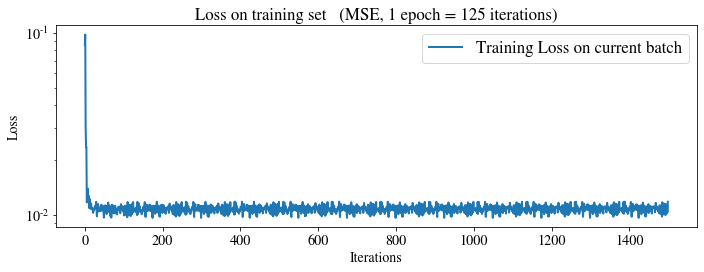

/var/folders/tn/nyh0947d6sngjfvtp7hbb0jr0000gn/T/ipykernel_5515/863207960.py:19: UserWarning: Glyph 9 (	) missing from current font.
  a=plt.savefig(path + '/valid_losses.png', dpi=150)
/Users/canrager/.pyenv/versions/3.9.11/envs/thenv/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


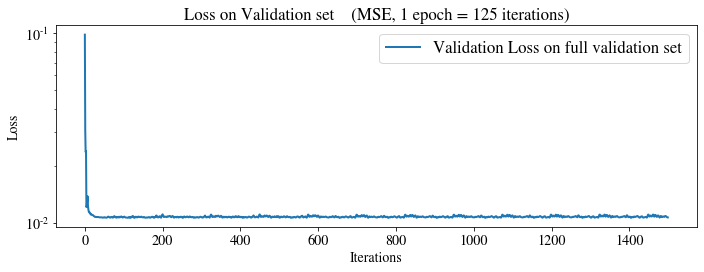

0.010452621926863989
./data/tomo0607_2qubit_random_uniform_vector/states10000_obs100/run_20220609_120754/ AE2Q_kleiner 10000.0 100 16 0.05 12
AutoencoderNet(
  (encoder): Sequential(
    (0): Linear(in_features=100, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=16, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=16, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=100, bias=True)
  )
)


100%|██████████| 12/12 [01:23<00:00,  6.96s/it]
/var/folders/tn/nyh0947d6sngjfvtp7hbb0jr0000gn/T/ipykernel_5515/863207960.py:9: UserWarning: Glyph 9 (	) missing from current font.
  a=plt.savefig(path + '/train_losses.png', dpi=150)


[0.081385   0.15459721 0.0380692  ... 0.0114235  0.01030851 0.0117998 ]


/Users/canrager/.pyenv/versions/3.9.11/envs/thenv/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


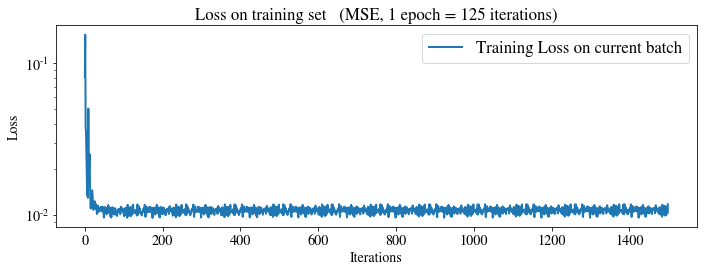

/var/folders/tn/nyh0947d6sngjfvtp7hbb0jr0000gn/T/ipykernel_5515/863207960.py:19: UserWarning: Glyph 9 (	) missing from current font.
  a=plt.savefig(path + '/valid_losses.png', dpi=150)
/Users/canrager/.pyenv/versions/3.9.11/envs/thenv/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


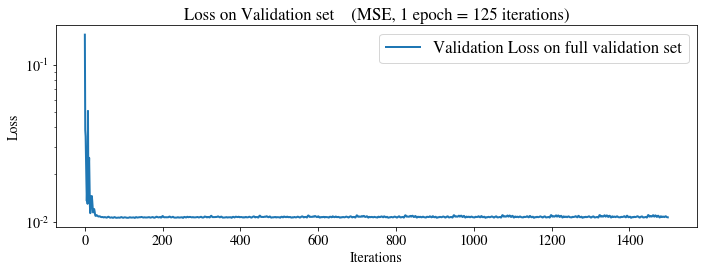

0.010449735882381598
./data/tomo0607_2qubit_random_uniform_vector/states10000_obs100/run_20220609_120754/ AE2Q_kleiner 10000.0 100 18 0.05 12
AutoencoderNet(
  (encoder): Sequential(
    (0): Linear(in_features=100, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=18, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=18, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=100, bias=True)
  )
)


100%|██████████| 12/12 [01:23<00:00,  6.93s/it]
/var/folders/tn/nyh0947d6sngjfvtp7hbb0jr0000gn/T/ipykernel_5515/863207960.py:9: UserWarning: Glyph 9 (	) missing from current font.
  a=plt.savefig(path + '/train_losses.png', dpi=150)


[0.08358898 0.04941208 0.02509249 ... 0.01142514 0.0103068  0.01180053]


/Users/canrager/.pyenv/versions/3.9.11/envs/thenv/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


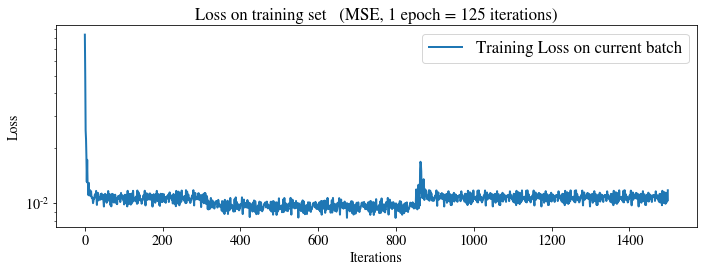

/var/folders/tn/nyh0947d6sngjfvtp7hbb0jr0000gn/T/ipykernel_5515/863207960.py:19: UserWarning: Glyph 9 (	) missing from current font.
  a=plt.savefig(path + '/valid_losses.png', dpi=150)
/Users/canrager/.pyenv/versions/3.9.11/envs/thenv/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


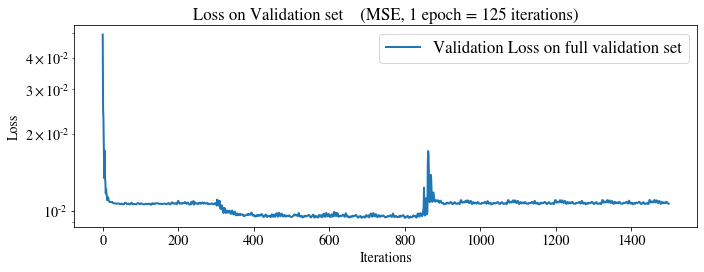

0.01045264843851328
./data/tomo0607_2qubit_random_uniform_vector/states10000_obs100/run_20220609_120754/ AE2Q_kleiner 10000.0 100 20 0.05 12
AutoencoderNet(
  (encoder): Sequential(
    (0): Linear(in_features=100, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=20, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=20, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=100, bias=True)
  )
)


100%|██████████| 12/12 [01:23<00:00,  6.93s/it]
/var/folders/tn/nyh0947d6sngjfvtp7hbb0jr0000gn/T/ipykernel_5515/863207960.py:9: UserWarning: Glyph 9 (	) missing from current font.
  a=plt.savefig(path + '/train_losses.png', dpi=150)


[0.0771585  0.35934943 0.04266783 ... 0.01141878 0.01030148 0.01177339]


/Users/canrager/.pyenv/versions/3.9.11/envs/thenv/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


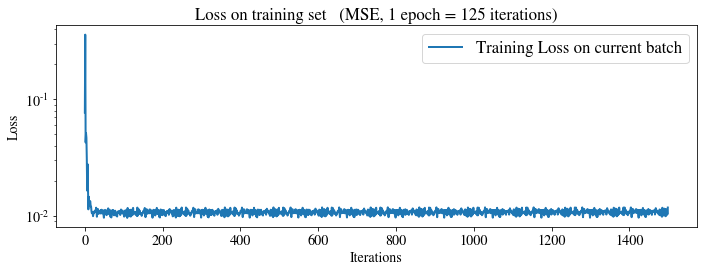

/var/folders/tn/nyh0947d6sngjfvtp7hbb0jr0000gn/T/ipykernel_5515/863207960.py:19: UserWarning: Glyph 9 (	) missing from current font.
  a=plt.savefig(path + '/valid_losses.png', dpi=150)
/Users/canrager/.pyenv/versions/3.9.11/envs/thenv/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


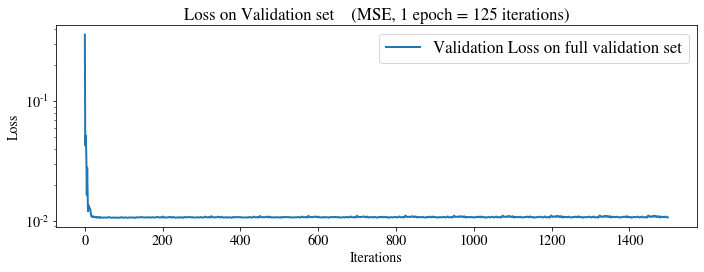

0.010441433514157931
./data/tomo0607_2qubit_random_uniform_vector/states10000_obs100/run_20220609_120754/ AE2Q_kleiner 10000.0 100 25 0.05 12
AutoencoderNet(
  (encoder): Sequential(
    (0): Linear(in_features=100, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=25, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=25, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=100, bias=True)
  )
)


100%|██████████| 12/12 [01:22<00:00,  6.91s/it]
/var/folders/tn/nyh0947d6sngjfvtp7hbb0jr0000gn/T/ipykernel_5515/863207960.py:9: UserWarning: Glyph 9 (	) missing from current font.
  a=plt.savefig(path + '/train_losses.png', dpi=150)


[0.0821431  0.76200885 0.03381466 ... 0.01143583 0.01033409 0.01177811]


/Users/canrager/.pyenv/versions/3.9.11/envs/thenv/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


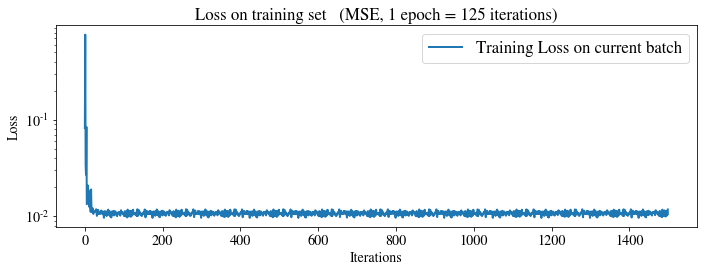

/var/folders/tn/nyh0947d6sngjfvtp7hbb0jr0000gn/T/ipykernel_5515/863207960.py:19: UserWarning: Glyph 9 (	) missing from current font.
  a=plt.savefig(path + '/valid_losses.png', dpi=150)
/Users/canrager/.pyenv/versions/3.9.11/envs/thenv/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


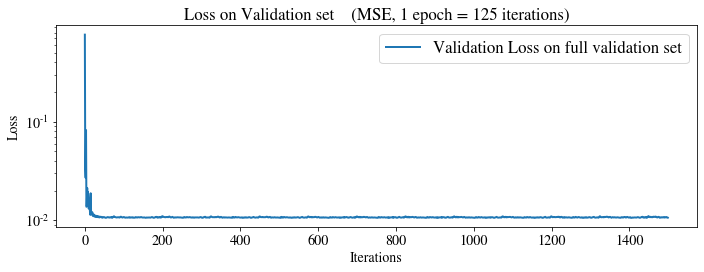

0.01042232761780421
./data/tomo0607_2qubit_random_uniform_vector/states10000_obs100/run_20220609_120754/ AE2Q_kleiner 10000.0 100 30 0.05 12
AutoencoderNet(
  (encoder): Sequential(
    (0): Linear(in_features=100, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=30, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=30, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=100, bias=True)
  )
)


100%|██████████| 12/12 [01:24<00:00,  7.06s/it]
/var/folders/tn/nyh0947d6sngjfvtp7hbb0jr0000gn/T/ipykernel_5515/863207960.py:9: UserWarning: Glyph 9 (	) missing from current font.
  a=plt.savefig(path + '/train_losses.png', dpi=150)


[0.07355044 0.06241303 0.02052487 ... 0.01143193 0.01029815 0.01177765]


/Users/canrager/.pyenv/versions/3.9.11/envs/thenv/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


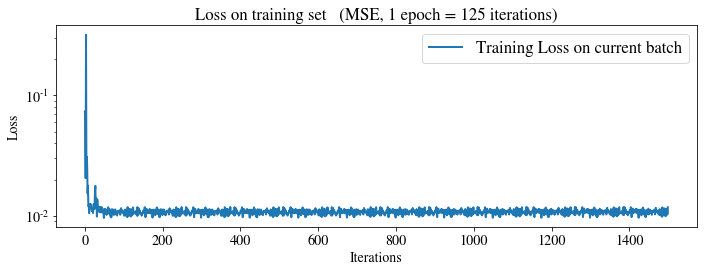

/var/folders/tn/nyh0947d6sngjfvtp7hbb0jr0000gn/T/ipykernel_5515/863207960.py:19: UserWarning: Glyph 9 (	) missing from current font.
  a=plt.savefig(path + '/valid_losses.png', dpi=150)
/Users/canrager/.pyenv/versions/3.9.11/envs/thenv/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


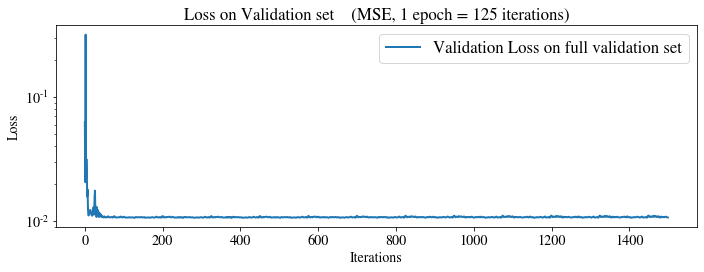

0.010443703581889471
./data/tomo0607_2qubit_random_uniform_vector/states10000_obs100/run_20220609_120819/ AE2Q_kleiner 10000.0 100 1 0.05 12
AutoencoderNet(
  (encoder): Sequential(
    (0): Linear(in_features=100, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=1, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=1, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=100, bias=True)
  )
)


100%|██████████| 12/12 [01:22<00:00,  6.92s/it]
/var/folders/tn/nyh0947d6sngjfvtp7hbb0jr0000gn/T/ipykernel_5515/863207960.py:9: UserWarning: Glyph 9 (	) missing from current font.
  a=plt.savefig(path + '/train_losses.png', dpi=150)


[0.08191374 0.10093569 0.02317575 ... 0.00948248 0.01005282 0.008954  ]


/Users/canrager/.pyenv/versions/3.9.11/envs/thenv/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


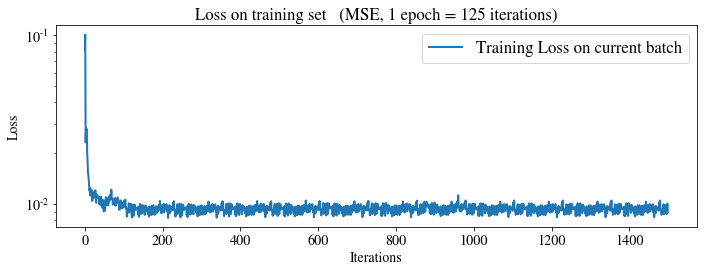

/var/folders/tn/nyh0947d6sngjfvtp7hbb0jr0000gn/T/ipykernel_5515/863207960.py:19: UserWarning: Glyph 9 (	) missing from current font.
  a=plt.savefig(path + '/valid_losses.png', dpi=150)
/Users/canrager/.pyenv/versions/3.9.11/envs/thenv/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


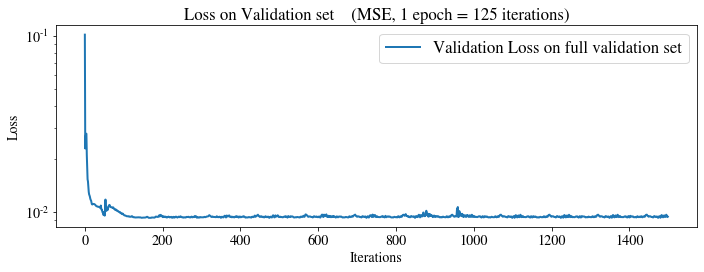

0.009184074650208155
./data/tomo0607_2qubit_random_uniform_vector/states10000_obs100/run_20220609_120819/ AE2Q_kleiner 10000.0 100 5 0.05 12
AutoencoderNet(
  (encoder): Sequential(
    (0): Linear(in_features=100, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=5, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=5, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=100, bias=True)
  )
)


100%|██████████| 12/12 [01:22<00:00,  6.91s/it]
/var/folders/tn/nyh0947d6sngjfvtp7hbb0jr0000gn/T/ipykernel_5515/863207960.py:9: UserWarning: Glyph 9 (	) missing from current font.
  a=plt.savefig(path + '/train_losses.png', dpi=150)


[0.07561246 0.3896687  0.02894607 ... 0.01097425 0.0112783  0.0103849 ]


/Users/canrager/.pyenv/versions/3.9.11/envs/thenv/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


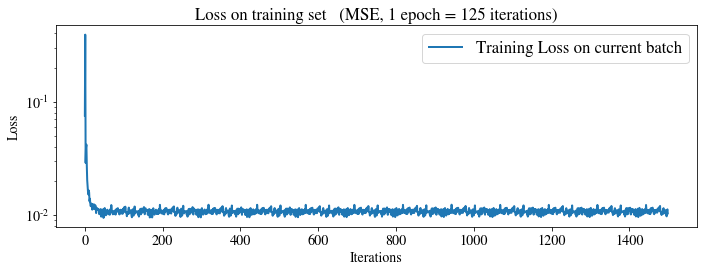

/var/folders/tn/nyh0947d6sngjfvtp7hbb0jr0000gn/T/ipykernel_5515/863207960.py:19: UserWarning: Glyph 9 (	) missing from current font.
  a=plt.savefig(path + '/valid_losses.png', dpi=150)
/Users/canrager/.pyenv/versions/3.9.11/envs/thenv/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


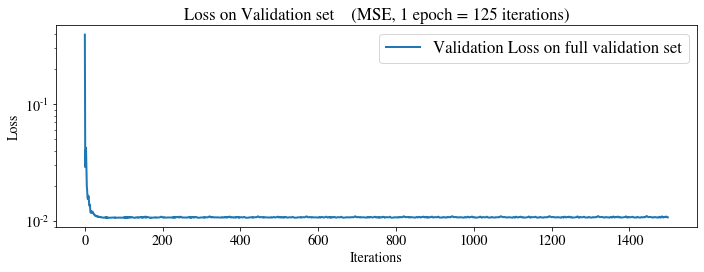

0.010499289197226366
./data/tomo0607_2qubit_random_uniform_vector/states10000_obs100/run_20220609_120819/ AE2Q_kleiner 10000.0 100 10 0.05 12
AutoencoderNet(
  (encoder): Sequential(
    (0): Linear(in_features=100, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=10, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=10, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=100, bias=True)
  )
)


100%|██████████| 12/12 [01:23<00:00,  6.93s/it]
/var/folders/tn/nyh0947d6sngjfvtp7hbb0jr0000gn/T/ipykernel_5515/863207960.py:9: UserWarning: Glyph 9 (	) missing from current font.
  a=plt.savefig(path + '/train_losses.png', dpi=150)


[0.08552841 0.25923857 0.04381271 ... 0.01099097 0.01128493 0.01039642]


/Users/canrager/.pyenv/versions/3.9.11/envs/thenv/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


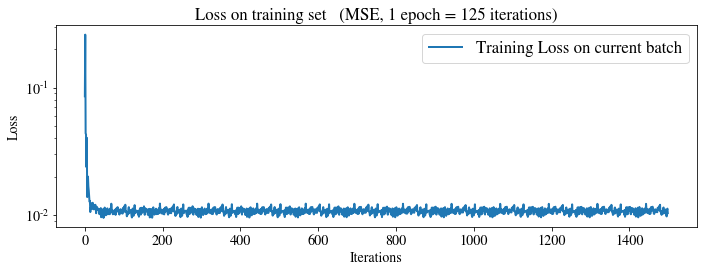

/var/folders/tn/nyh0947d6sngjfvtp7hbb0jr0000gn/T/ipykernel_5515/863207960.py:19: UserWarning: Glyph 9 (	) missing from current font.
  a=plt.savefig(path + '/valid_losses.png', dpi=150)
/Users/canrager/.pyenv/versions/3.9.11/envs/thenv/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


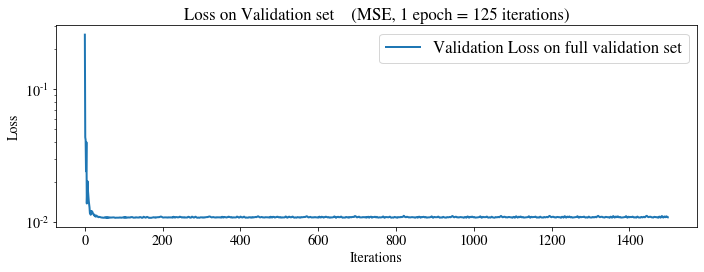

0.010507767523328463
./data/tomo0607_2qubit_random_uniform_vector/states10000_obs100/run_20220609_120819/ AE2Q_kleiner 10000.0 100 12 0.05 12
AutoencoderNet(
  (encoder): Sequential(
    (0): Linear(in_features=100, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=12, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=12, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=100, bias=True)
  )
)


100%|██████████| 12/12 [01:23<00:00,  6.95s/it]
/var/folders/tn/nyh0947d6sngjfvtp7hbb0jr0000gn/T/ipykernel_5515/863207960.py:9: UserWarning: Glyph 9 (	) missing from current font.
  a=plt.savefig(path + '/train_losses.png', dpi=150)


[0.08092961 0.0605864  0.02136148 ... 0.01101435 0.011301   0.01039972]


/Users/canrager/.pyenv/versions/3.9.11/envs/thenv/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


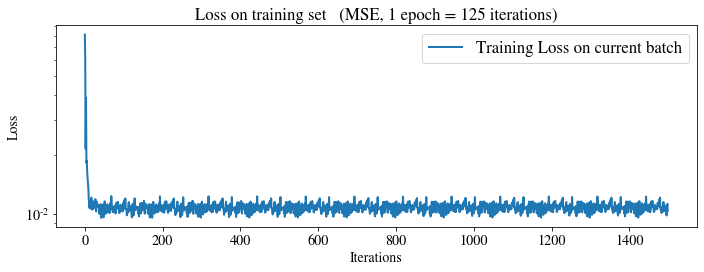

/var/folders/tn/nyh0947d6sngjfvtp7hbb0jr0000gn/T/ipykernel_5515/863207960.py:19: UserWarning: Glyph 9 (	) missing from current font.
  a=plt.savefig(path + '/valid_losses.png', dpi=150)
/Users/canrager/.pyenv/versions/3.9.11/envs/thenv/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


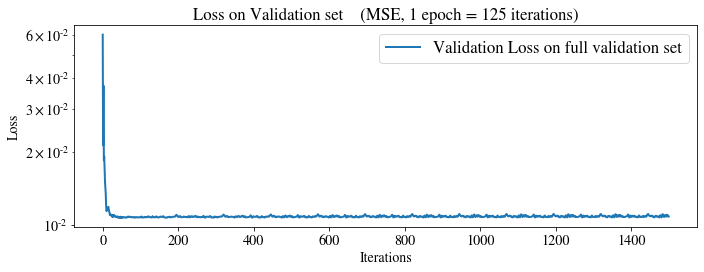

0.010543848387897015
./data/tomo0607_2qubit_random_uniform_vector/states10000_obs100/run_20220609_120819/ AE2Q_kleiner 10000.0 100 14 0.05 12
AutoencoderNet(
  (encoder): Sequential(
    (0): Linear(in_features=100, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=14, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=14, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=100, bias=True)
  )
)


100%|██████████| 12/12 [01:23<00:00,  6.94s/it]
/var/folders/tn/nyh0947d6sngjfvtp7hbb0jr0000gn/T/ipykernel_5515/863207960.py:9: UserWarning: Glyph 9 (	) missing from current font.
  a=plt.savefig(path + '/train_losses.png', dpi=150)


[0.07665791 0.23401888 0.02798434 ... 0.01646016 0.01230325 0.01052145]


/Users/canrager/.pyenv/versions/3.9.11/envs/thenv/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


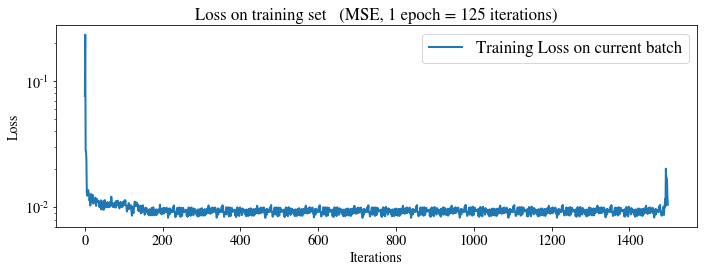

/var/folders/tn/nyh0947d6sngjfvtp7hbb0jr0000gn/T/ipykernel_5515/863207960.py:19: UserWarning: Glyph 9 (	) missing from current font.
  a=plt.savefig(path + '/valid_losses.png', dpi=150)
/Users/canrager/.pyenv/versions/3.9.11/envs/thenv/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


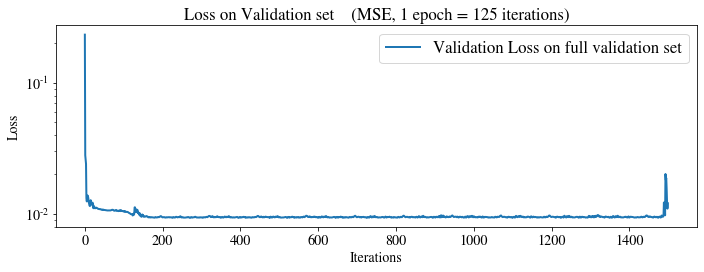

0.011873029296596845
./data/tomo0607_2qubit_random_uniform_vector/states10000_obs100/run_20220609_120819/ AE2Q_kleiner 10000.0 100 15 0.05 12
AutoencoderNet(
  (encoder): Sequential(
    (0): Linear(in_features=100, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=15, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=15, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=100, bias=True)
  )
)


100%|██████████| 12/12 [01:39<00:00,  8.27s/it]
/var/folders/tn/nyh0947d6sngjfvtp7hbb0jr0000gn/T/ipykernel_5515/863207960.py:9: UserWarning: Glyph 9 (	) missing from current font.
  a=plt.savefig(path + '/train_losses.png', dpi=150)


[0.07970451 0.03315258 0.02348353 ... 0.01101337 0.01130861 0.01039574]


/Users/canrager/.pyenv/versions/3.9.11/envs/thenv/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


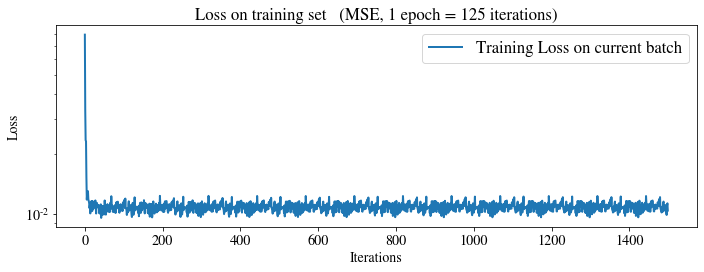

/var/folders/tn/nyh0947d6sngjfvtp7hbb0jr0000gn/T/ipykernel_5515/863207960.py:19: UserWarning: Glyph 9 (	) missing from current font.
  a=plt.savefig(path + '/valid_losses.png', dpi=150)
/Users/canrager/.pyenv/versions/3.9.11/envs/thenv/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


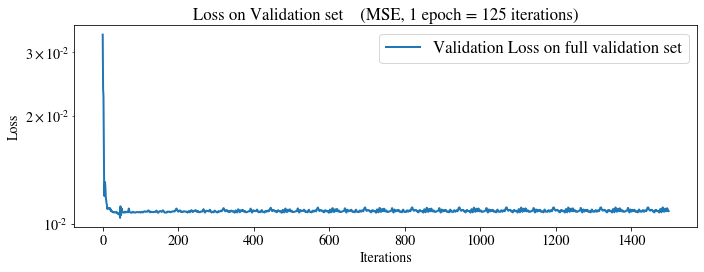

0.010545694455504417
./data/tomo0607_2qubit_random_uniform_vector/states10000_obs100/run_20220609_120819/ AE2Q_kleiner 10000.0 100 16 0.05 12
AutoencoderNet(
  (encoder): Sequential(
    (0): Linear(in_features=100, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=16, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=16, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=100, bias=True)
  )
)


100%|██████████| 12/12 [30:26<00:00, 152.22s/it]


[0.07213924 0.24268647 0.0353945  ... 0.01098658 0.01128022 0.01039405]


/var/folders/tn/nyh0947d6sngjfvtp7hbb0jr0000gn/T/ipykernel_5515/863207960.py:9: UserWarning: Glyph 9 (	) missing from current font.
  a=plt.savefig(path + '/train_losses.png', dpi=150)
/Users/canrager/.pyenv/versions/3.9.11/envs/thenv/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


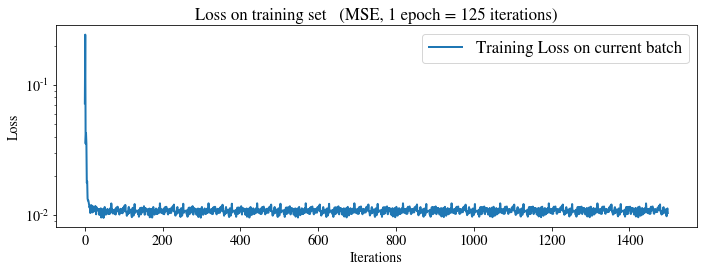

/var/folders/tn/nyh0947d6sngjfvtp7hbb0jr0000gn/T/ipykernel_5515/863207960.py:19: UserWarning: Glyph 9 (	) missing from current font.
  a=plt.savefig(path + '/valid_losses.png', dpi=150)
/Users/canrager/.pyenv/versions/3.9.11/envs/thenv/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


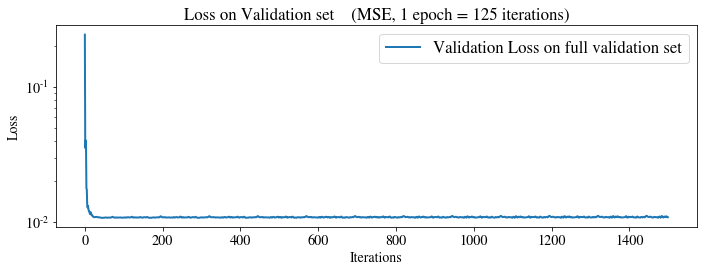

0.010520079359412193
./data/tomo0607_2qubit_random_uniform_vector/states10000_obs100/run_20220609_120819/ AE2Q_kleiner 10000.0 100 18 0.05 12
AutoencoderNet(
  (encoder): Sequential(
    (0): Linear(in_features=100, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=18, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=18, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=100, bias=True)
  )
)


100%|██████████| 12/12 [02:19<00:00, 11.61s/it]
/var/folders/tn/nyh0947d6sngjfvtp7hbb0jr0000gn/T/ipykernel_5515/863207960.py:9: UserWarning: Glyph 9 (	) missing from current font.
  a=plt.savefig(path + '/train_losses.png', dpi=150)


[0.07786871 1.06589234 0.04685224 ... 0.0094473  0.01011537 0.00902063]


/Users/canrager/.pyenv/versions/3.9.11/envs/thenv/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


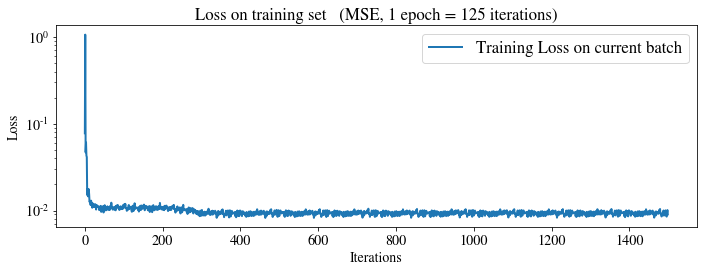

/var/folders/tn/nyh0947d6sngjfvtp7hbb0jr0000gn/T/ipykernel_5515/863207960.py:19: UserWarning: Glyph 9 (	) missing from current font.
  a=plt.savefig(path + '/valid_losses.png', dpi=150)
/Users/canrager/.pyenv/versions/3.9.11/envs/thenv/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


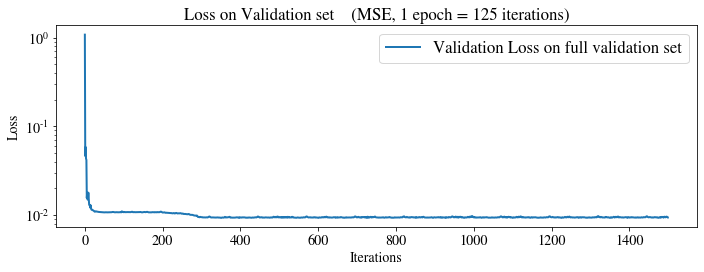

0.009134496500094732
./data/tomo0607_2qubit_random_uniform_vector/states10000_obs100/run_20220609_120819/ AE2Q_kleiner 10000.0 100 20 0.05 12
AutoencoderNet(
  (encoder): Sequential(
    (0): Linear(in_features=100, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=20, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=20, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=100, bias=True)
  )
)


100%|██████████| 12/12 [02:16<00:00, 11.34s/it]
/var/folders/tn/nyh0947d6sngjfvtp7hbb0jr0000gn/T/ipykernel_5515/863207960.py:9: UserWarning: Glyph 9 (	) missing from current font.
  a=plt.savefig(path + '/train_losses.png', dpi=150)


[0.07489942 0.08100814 0.01793118 ... 0.0110095  0.01130145 0.01038673]


/Users/canrager/.pyenv/versions/3.9.11/envs/thenv/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


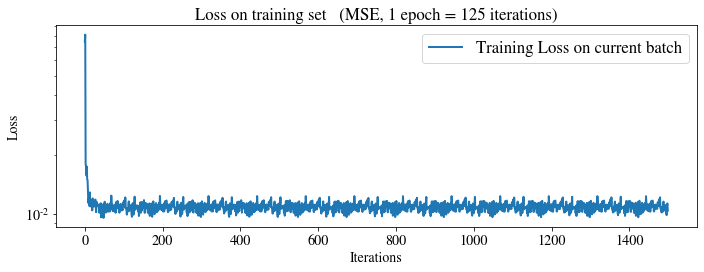

/var/folders/tn/nyh0947d6sngjfvtp7hbb0jr0000gn/T/ipykernel_5515/863207960.py:19: UserWarning: Glyph 9 (	) missing from current font.
  a=plt.savefig(path + '/valid_losses.png', dpi=150)
/Users/canrager/.pyenv/versions/3.9.11/envs/thenv/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


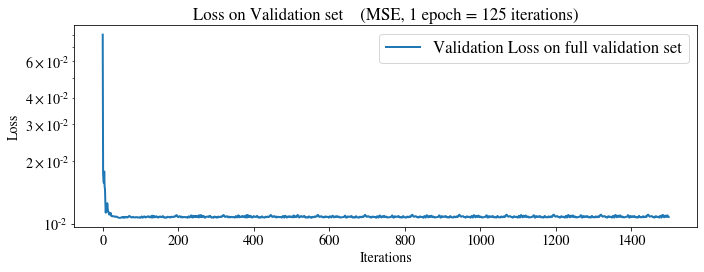

0.01053577767064174
./data/tomo0607_2qubit_random_uniform_vector/states10000_obs100/run_20220609_120819/ AE2Q_kleiner 10000.0 100 25 0.05 12
AutoencoderNet(
  (encoder): Sequential(
    (0): Linear(in_features=100, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=25, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=25, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=100, bias=True)
  )
)


100%|██████████| 12/12 [02:15<00:00, 11.28s/it]


[0.079003   0.63100976 0.05400034 ... 0.0109666  0.01128955 0.01041893]


/var/folders/tn/nyh0947d6sngjfvtp7hbb0jr0000gn/T/ipykernel_5515/863207960.py:9: UserWarning: Glyph 9 (	) missing from current font.
  a=plt.savefig(path + '/train_losses.png', dpi=150)
/Users/canrager/.pyenv/versions/3.9.11/envs/thenv/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


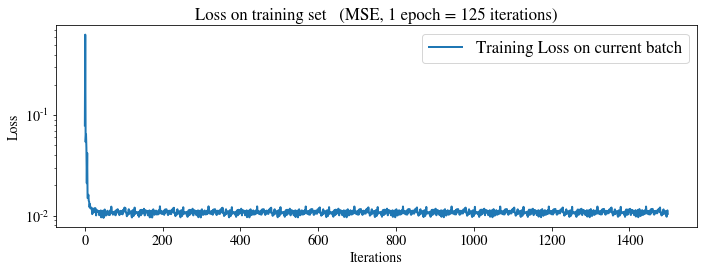

/var/folders/tn/nyh0947d6sngjfvtp7hbb0jr0000gn/T/ipykernel_5515/863207960.py:19: UserWarning: Glyph 9 (	) missing from current font.
  a=plt.savefig(path + '/valid_losses.png', dpi=150)
/Users/canrager/.pyenv/versions/3.9.11/envs/thenv/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


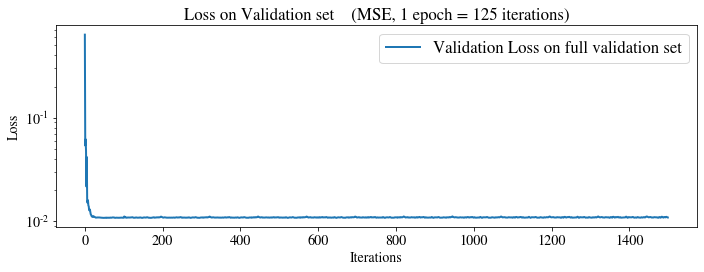

0.01049353505174319
./data/tomo0607_2qubit_random_uniform_vector/states10000_obs100/run_20220609_120819/ AE2Q_kleiner 10000.0 100 30 0.05 12
AutoencoderNet(
  (encoder): Sequential(
    (0): Linear(in_features=100, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=30, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=30, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=100, bias=True)
  )
)


100%|██████████| 12/12 [02:15<00:00, 11.26s/it]
/var/folders/tn/nyh0947d6sngjfvtp7hbb0jr0000gn/T/ipykernel_5515/863207960.py:9: UserWarning: Glyph 9 (	) missing from current font.
  a=plt.savefig(path + '/train_losses.png', dpi=150)


[0.07752336 0.02035873 0.03147289 ... 0.0110146  0.01130742 0.01039927]


/Users/canrager/.pyenv/versions/3.9.11/envs/thenv/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


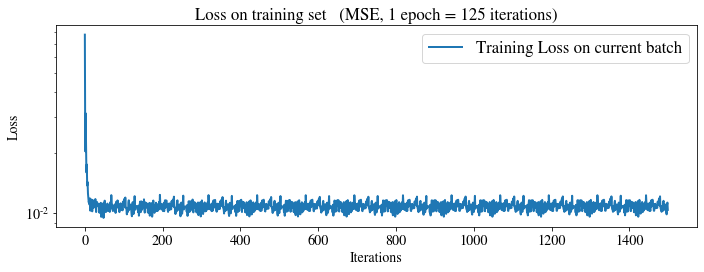

/var/folders/tn/nyh0947d6sngjfvtp7hbb0jr0000gn/T/ipykernel_5515/863207960.py:19: UserWarning: Glyph 9 (	) missing from current font.
  a=plt.savefig(path + '/valid_losses.png', dpi=150)
/Users/canrager/.pyenv/versions/3.9.11/envs/thenv/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


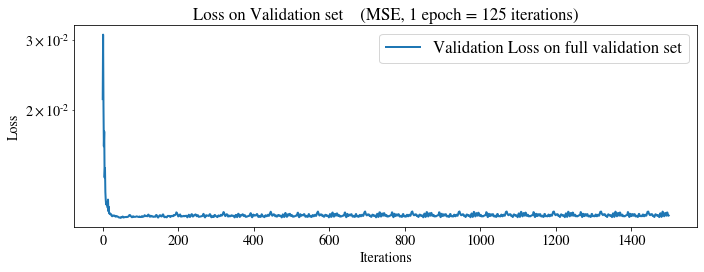

0.010547205867866675
./data/tomo0607_2qubit_random_uniform_vector/states10000_obs100/run_20220609_120829/ AE2Q_kleiner 10000.0 100 1 0.05 12
AutoencoderNet(
  (encoder): Sequential(
    (0): Linear(in_features=100, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=1, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=1, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=100, bias=True)
  )
)


100%|██████████| 12/12 [02:15<00:00, 11.30s/it]
/var/folders/tn/nyh0947d6sngjfvtp7hbb0jr0000gn/T/ipykernel_5515/863207960.py:9: UserWarning: Glyph 9 (	) missing from current font.
  a=plt.savefig(path + '/train_losses.png', dpi=150)


[0.09232156 1.70322359 0.04280575 ... 0.01038458 0.01027795 0.00993665]


/Users/canrager/.pyenv/versions/3.9.11/envs/thenv/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


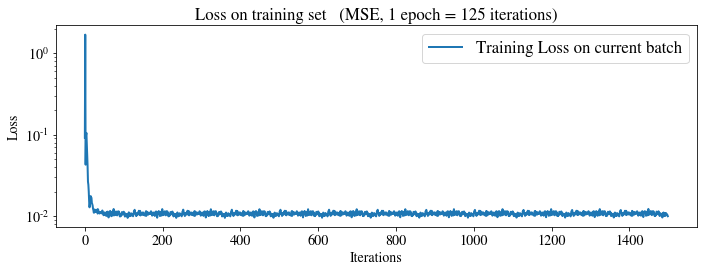

/var/folders/tn/nyh0947d6sngjfvtp7hbb0jr0000gn/T/ipykernel_5515/863207960.py:19: UserWarning: Glyph 9 (	) missing from current font.
  a=plt.savefig(path + '/valid_losses.png', dpi=150)
/Users/canrager/.pyenv/versions/3.9.11/envs/thenv/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


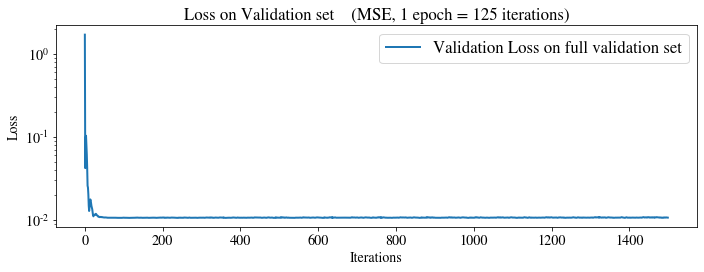

0.0107144587362806
./data/tomo0607_2qubit_random_uniform_vector/states10000_obs100/run_20220609_120829/ AE2Q_kleiner 10000.0 100 5 0.05 12
AutoencoderNet(
  (encoder): Sequential(
    (0): Linear(in_features=100, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=5, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=5, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=100, bias=True)
  )
)


100%|██████████| 12/12 [02:15<00:00, 11.31s/it]
/var/folders/tn/nyh0947d6sngjfvtp7hbb0jr0000gn/T/ipykernel_5515/863207960.py:9: UserWarning: Glyph 9 (	) missing from current font.
  a=plt.savefig(path + '/train_losses.png', dpi=150)


[0.08395664 0.29236755 0.03496418 ... 0.0092545  0.00890654 0.00878436]


/Users/canrager/.pyenv/versions/3.9.11/envs/thenv/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


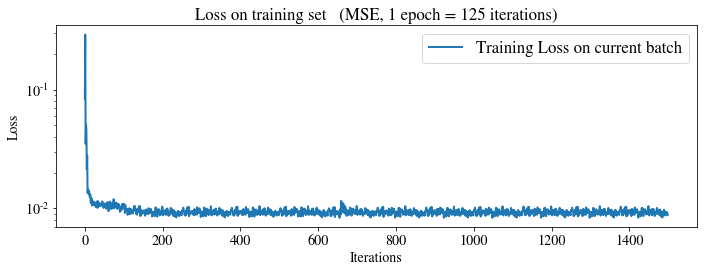

/var/folders/tn/nyh0947d6sngjfvtp7hbb0jr0000gn/T/ipykernel_5515/863207960.py:19: UserWarning: Glyph 9 (	) missing from current font.
  a=plt.savefig(path + '/valid_losses.png', dpi=150)
/Users/canrager/.pyenv/versions/3.9.11/envs/thenv/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


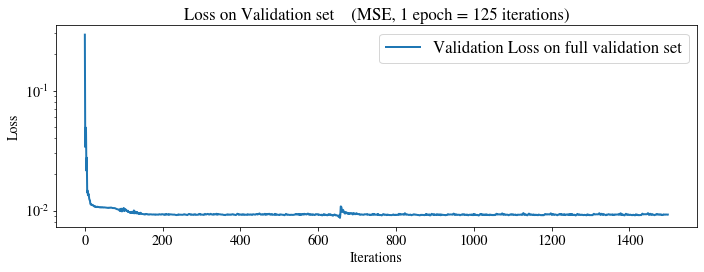

0.009181314210096995
./data/tomo0607_2qubit_random_uniform_vector/states10000_obs100/run_20220609_120829/ AE2Q_kleiner 10000.0 100 10 0.05 12
AutoencoderNet(
  (encoder): Sequential(
    (0): Linear(in_features=100, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=10, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=10, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=100, bias=True)
  )
)


100%|██████████| 12/12 [02:15<00:00, 11.31s/it]
/var/folders/tn/nyh0947d6sngjfvtp7hbb0jr0000gn/T/ipykernel_5515/863207960.py:9: UserWarning: Glyph 9 (	) missing from current font.
  a=plt.savefig(path + '/train_losses.png', dpi=150)


[0.08797667 0.06303344 0.0318929  ... 0.01039398 0.01036929 0.01003554]


/Users/canrager/.pyenv/versions/3.9.11/envs/thenv/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


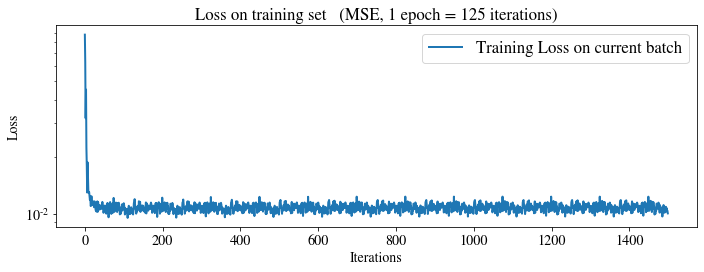

/var/folders/tn/nyh0947d6sngjfvtp7hbb0jr0000gn/T/ipykernel_5515/863207960.py:19: UserWarning: Glyph 9 (	) missing from current font.
  a=plt.savefig(path + '/valid_losses.png', dpi=150)
/Users/canrager/.pyenv/versions/3.9.11/envs/thenv/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


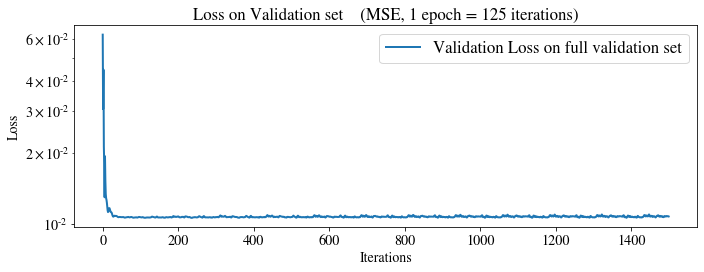

0.010818070856233437
./data/tomo0607_2qubit_random_uniform_vector/states10000_obs100/run_20220609_120829/ AE2Q_kleiner 10000.0 100 12 0.05 12
AutoencoderNet(
  (encoder): Sequential(
    (0): Linear(in_features=100, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=12, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=12, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=100, bias=True)
  )
)


100%|██████████| 12/12 [02:15<00:00, 11.28s/it]
/var/folders/tn/nyh0947d6sngjfvtp7hbb0jr0000gn/T/ipykernel_5515/863207960.py:9: UserWarning: Glyph 9 (	) missing from current font.
  a=plt.savefig(path + '/train_losses.png', dpi=150)


[0.08027482 0.06710865 0.01940998 ... 0.01039533 0.01037564 0.01002772]


/Users/canrager/.pyenv/versions/3.9.11/envs/thenv/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


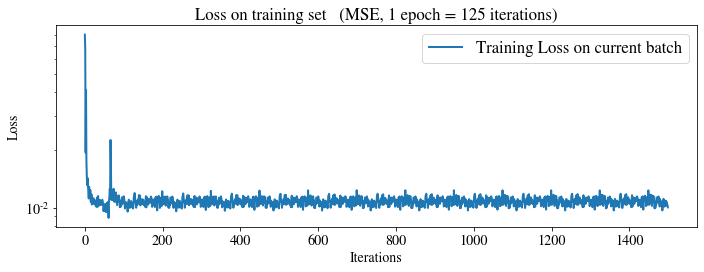

/var/folders/tn/nyh0947d6sngjfvtp7hbb0jr0000gn/T/ipykernel_5515/863207960.py:19: UserWarning: Glyph 9 (	) missing from current font.
  a=plt.savefig(path + '/valid_losses.png', dpi=150)
/Users/canrager/.pyenv/versions/3.9.11/envs/thenv/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


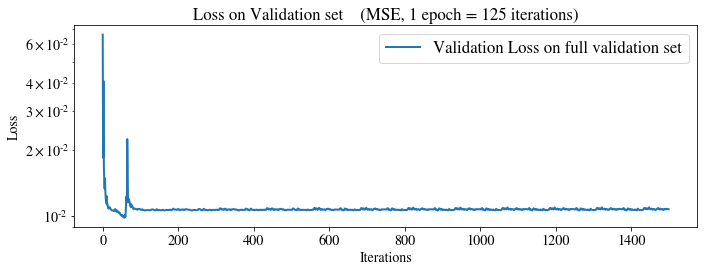

0.010811417984465757
./data/tomo0607_2qubit_random_uniform_vector/states10000_obs100/run_20220609_120829/ AE2Q_kleiner 10000.0 100 14 0.05 12
AutoencoderNet(
  (encoder): Sequential(
    (0): Linear(in_features=100, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=14, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=14, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=100, bias=True)
  )
)


100%|██████████| 12/12 [02:18<00:00, 11.51s/it]
/var/folders/tn/nyh0947d6sngjfvtp7hbb0jr0000gn/T/ipykernel_5515/863207960.py:9: UserWarning: Glyph 9 (	) missing from current font.
  a=plt.savefig(path + '/train_losses.png', dpi=150)


[0.07718327 1.34343064 0.05730976 ... 0.01035698 0.01027844 0.00989688]


/Users/canrager/.pyenv/versions/3.9.11/envs/thenv/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


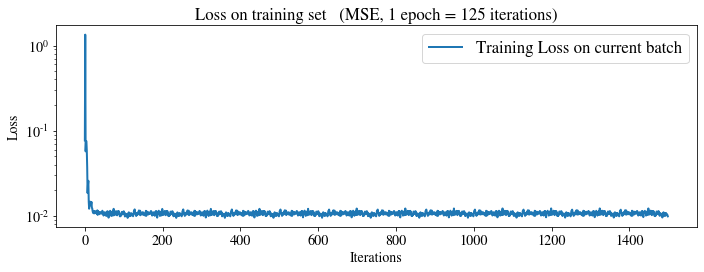

/var/folders/tn/nyh0947d6sngjfvtp7hbb0jr0000gn/T/ipykernel_5515/863207960.py:19: UserWarning: Glyph 9 (	) missing from current font.
  a=plt.savefig(path + '/valid_losses.png', dpi=150)
/Users/canrager/.pyenv/versions/3.9.11/envs/thenv/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


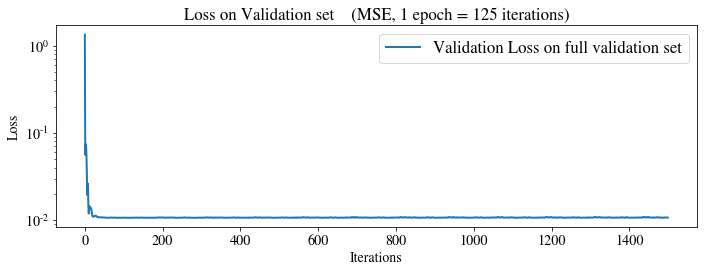

0.010716163429121177
./data/tomo0607_2qubit_random_uniform_vector/states10000_obs100/run_20220609_120829/ AE2Q_kleiner 10000.0 100 15 0.05 12
AutoencoderNet(
  (encoder): Sequential(
    (0): Linear(in_features=100, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=15, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=15, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=100, bias=True)
  )
)


100%|██████████| 12/12 [02:16<00:00, 11.36s/it]
/var/folders/tn/nyh0947d6sngjfvtp7hbb0jr0000gn/T/ipykernel_5515/863207960.py:9: UserWarning: Glyph 9 (	) missing from current font.
  a=plt.savefig(path + '/train_losses.png', dpi=150)


[0.08168332 0.04441081 0.01805679 ... 0.01036774 0.01034405 0.00995412]


/Users/canrager/.pyenv/versions/3.9.11/envs/thenv/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


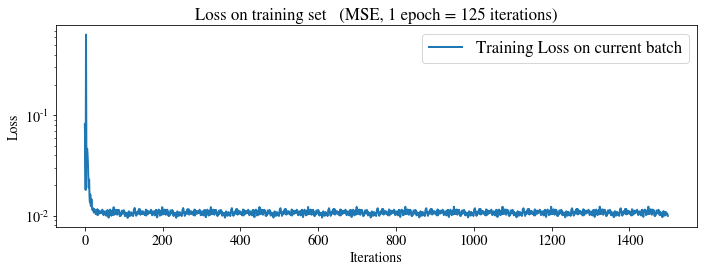

/var/folders/tn/nyh0947d6sngjfvtp7hbb0jr0000gn/T/ipykernel_5515/863207960.py:19: UserWarning: Glyph 9 (	) missing from current font.
  a=plt.savefig(path + '/valid_losses.png', dpi=150)
/Users/canrager/.pyenv/versions/3.9.11/envs/thenv/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


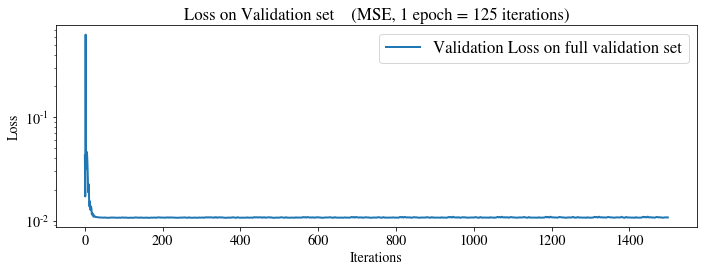

0.010759688292940458
./data/tomo0607_2qubit_random_uniform_vector/states10000_obs100/run_20220609_120829/ AE2Q_kleiner 10000.0 100 16 0.05 12
AutoencoderNet(
  (encoder): Sequential(
    (0): Linear(in_features=100, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=16, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=16, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=100, bias=True)
  )
)


100%|██████████| 12/12 [02:16<00:00, 11.35s/it]
/var/folders/tn/nyh0947d6sngjfvtp7hbb0jr0000gn/T/ipykernel_5515/863207960.py:9: UserWarning: Glyph 9 (	) missing from current font.
  a=plt.savefig(path + '/train_losses.png', dpi=150)


[0.07345814 0.18863632 0.04183464 ... 0.01032863 0.01029436 0.00991221]


/Users/canrager/.pyenv/versions/3.9.11/envs/thenv/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


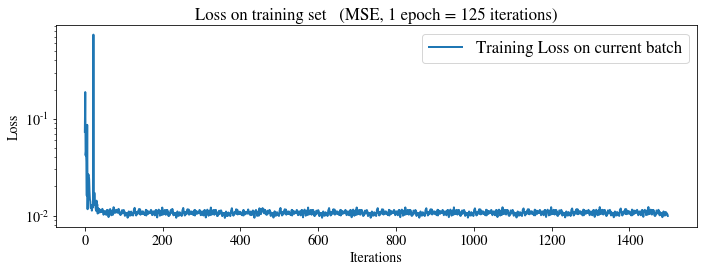

/var/folders/tn/nyh0947d6sngjfvtp7hbb0jr0000gn/T/ipykernel_5515/863207960.py:19: UserWarning: Glyph 9 (	) missing from current font.
  a=plt.savefig(path + '/valid_losses.png', dpi=150)
/Users/canrager/.pyenv/versions/3.9.11/envs/thenv/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


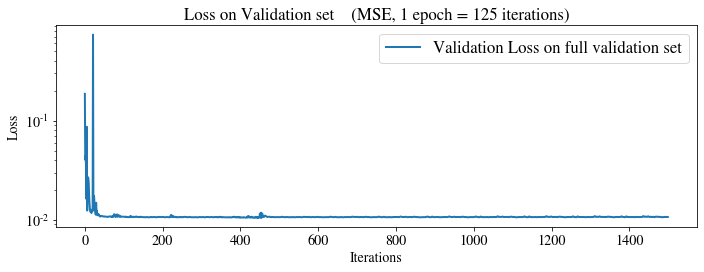

0.010733700916171074
./data/tomo0607_2qubit_random_uniform_vector/states10000_obs100/run_20220609_120829/ AE2Q_kleiner 10000.0 100 18 0.05 12
AutoencoderNet(
  (encoder): Sequential(
    (0): Linear(in_features=100, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=18, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=18, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=100, bias=True)
  )
)


100%|██████████| 12/12 [02:16<00:00, 11.37s/it]
/var/folders/tn/nyh0947d6sngjfvtp7hbb0jr0000gn/T/ipykernel_5515/863207960.py:9: UserWarning: Glyph 9 (	) missing from current font.
  a=plt.savefig(path + '/train_losses.png', dpi=150)


[0.07971308 0.04682841 0.01516066 ... 0.01040059 0.01036674 0.01002432]


/Users/canrager/.pyenv/versions/3.9.11/envs/thenv/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


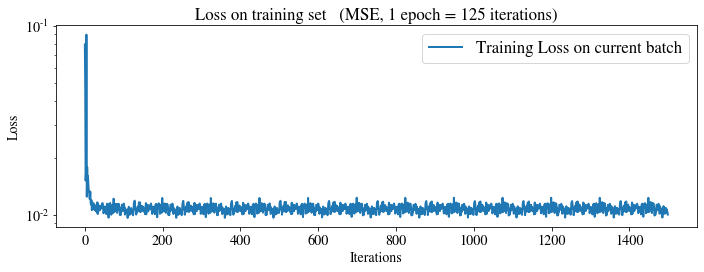

/var/folders/tn/nyh0947d6sngjfvtp7hbb0jr0000gn/T/ipykernel_5515/863207960.py:19: UserWarning: Glyph 9 (	) missing from current font.
  a=plt.savefig(path + '/valid_losses.png', dpi=150)
/Users/canrager/.pyenv/versions/3.9.11/envs/thenv/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


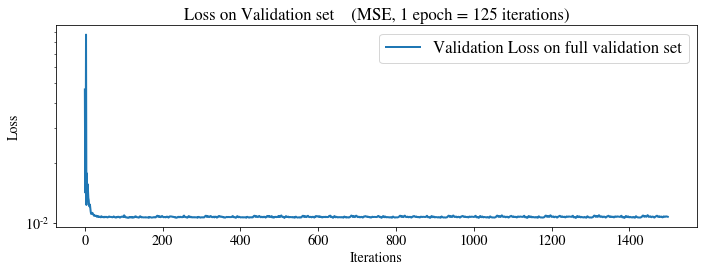

0.010807002149522304
./data/tomo0607_2qubit_random_uniform_vector/states10000_obs100/run_20220609_120829/ AE2Q_kleiner 10000.0 100 20 0.05 12
AutoencoderNet(
  (encoder): Sequential(
    (0): Linear(in_features=100, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=20, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=20, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=100, bias=True)
  )
)


100%|██████████| 12/12 [02:16<00:00, 11.36s/it]
/var/folders/tn/nyh0947d6sngjfvtp7hbb0jr0000gn/T/ipykernel_5515/863207960.py:9: UserWarning: Glyph 9 (	) missing from current font.
  a=plt.savefig(path + '/train_losses.png', dpi=150)


[0.07607727 0.15887375 0.0383606  ... 0.00924241 0.00889134 0.00878514]


/Users/canrager/.pyenv/versions/3.9.11/envs/thenv/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


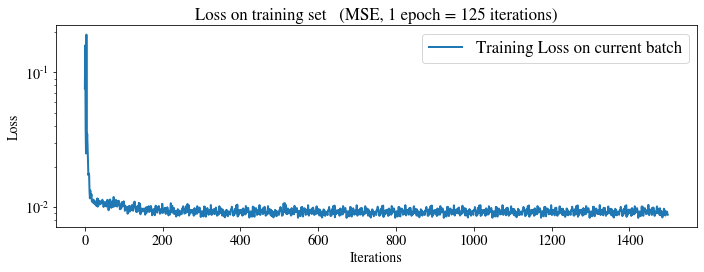

/var/folders/tn/nyh0947d6sngjfvtp7hbb0jr0000gn/T/ipykernel_5515/863207960.py:19: UserWarning: Glyph 9 (	) missing from current font.
  a=plt.savefig(path + '/valid_losses.png', dpi=150)
/Users/canrager/.pyenv/versions/3.9.11/envs/thenv/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


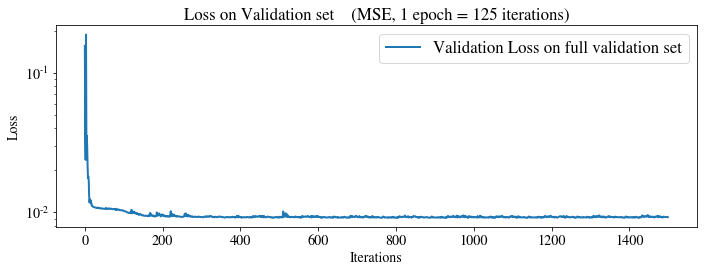

0.00915102685491244
./data/tomo0607_2qubit_random_uniform_vector/states10000_obs100/run_20220609_120829/ AE2Q_kleiner 10000.0 100 25 0.05 12
AutoencoderNet(
  (encoder): Sequential(
    (0): Linear(in_features=100, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=25, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=25, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=100, bias=True)
  )
)


100%|██████████| 12/12 [02:16<00:00, 11.37s/it]
/var/folders/tn/nyh0947d6sngjfvtp7hbb0jr0000gn/T/ipykernel_5515/863207960.py:9: UserWarning: Glyph 9 (	) missing from current font.
  a=plt.savefig(path + '/train_losses.png', dpi=150)


[0.0826882  0.39659986 0.04378777 ... 0.01034136 0.01034243 0.00993983]


/Users/canrager/.pyenv/versions/3.9.11/envs/thenv/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


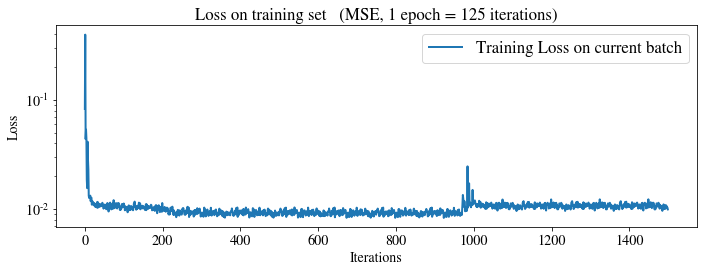

/var/folders/tn/nyh0947d6sngjfvtp7hbb0jr0000gn/T/ipykernel_5515/863207960.py:19: UserWarning: Glyph 9 (	) missing from current font.
  a=plt.savefig(path + '/valid_losses.png', dpi=150)
/Users/canrager/.pyenv/versions/3.9.11/envs/thenv/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


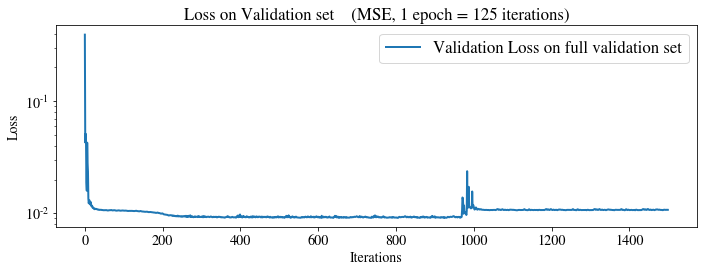

0.010762841068208217
./data/tomo0607_2qubit_random_uniform_vector/states10000_obs100/run_20220609_120829/ AE2Q_kleiner 10000.0 100 30 0.05 12
AutoencoderNet(
  (encoder): Sequential(
    (0): Linear(in_features=100, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=30, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=30, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=100, bias=True)
  )
)


100%|██████████| 12/12 [02:15<00:00, 11.33s/it]
/var/folders/tn/nyh0947d6sngjfvtp7hbb0jr0000gn/T/ipykernel_5515/863207960.py:9: UserWarning: Glyph 9 (	) missing from current font.
  a=plt.savefig(path + '/train_losses.png', dpi=150)


[0.0799066  0.05630341 0.02145946 ... 0.0104006  0.01037167 0.01005349]


/Users/canrager/.pyenv/versions/3.9.11/envs/thenv/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


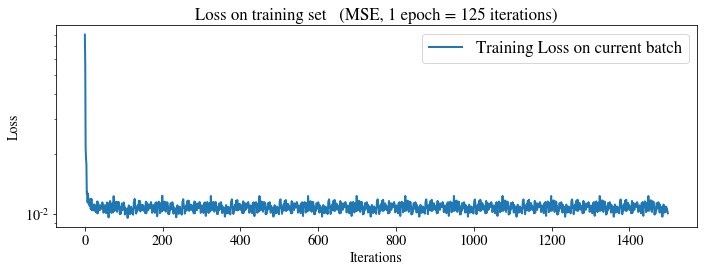

/var/folders/tn/nyh0947d6sngjfvtp7hbb0jr0000gn/T/ipykernel_5515/863207960.py:19: UserWarning: Glyph 9 (	) missing from current font.
  a=plt.savefig(path + '/valid_losses.png', dpi=150)
/Users/canrager/.pyenv/versions/3.9.11/envs/thenv/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


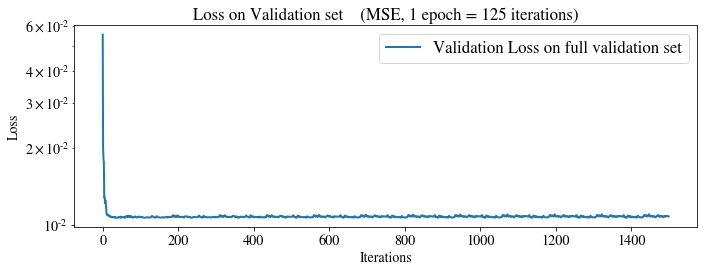

0.010823547405501207
./data/tomo0607_2qubit_random_uniform_vector/states10000_obs100/run_20220609_120804/ AE2Q_kleiner 10000.0 100 1 0.05 12
AutoencoderNet(
  (encoder): Sequential(
    (0): Linear(in_features=100, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=1, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=1, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=100, bias=True)
  )
)


100%|██████████| 12/12 [02:15<00:00, 11.27s/it]
/var/folders/tn/nyh0947d6sngjfvtp7hbb0jr0000gn/T/ipykernel_5515/863207960.py:9: UserWarning: Glyph 9 (	) missing from current font.
  a=plt.savefig(path + '/train_losses.png', dpi=150)


[0.07787099 0.56075257 0.02322714 ... 0.00930089 0.00878197 0.00946442]


/Users/canrager/.pyenv/versions/3.9.11/envs/thenv/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


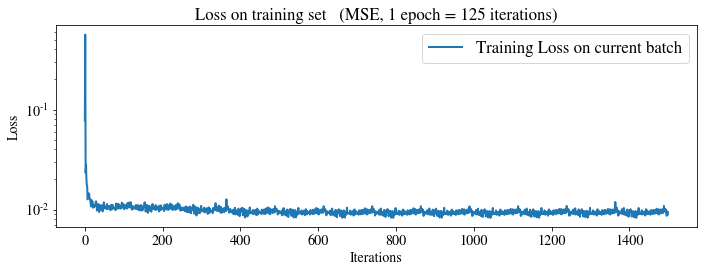

/var/folders/tn/nyh0947d6sngjfvtp7hbb0jr0000gn/T/ipykernel_5515/863207960.py:19: UserWarning: Glyph 9 (	) missing from current font.
  a=plt.savefig(path + '/valid_losses.png', dpi=150)
/Users/canrager/.pyenv/versions/3.9.11/envs/thenv/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


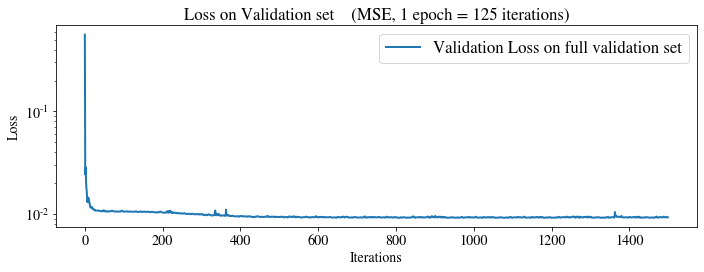

0.00944863564024369
./data/tomo0607_2qubit_random_uniform_vector/states10000_obs100/run_20220609_120804/ AE2Q_kleiner 10000.0 100 5 0.05 12
AutoencoderNet(
  (encoder): Sequential(
    (0): Linear(in_features=100, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=5, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=5, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=100, bias=True)
  )
)


100%|██████████| 12/12 [02:15<00:00, 11.31s/it]
/var/folders/tn/nyh0947d6sngjfvtp7hbb0jr0000gn/T/ipykernel_5515/863207960.py:9: UserWarning: Glyph 9 (	) missing from current font.
  a=plt.savefig(path + '/train_losses.png', dpi=150)


[0.07958639 0.6327278  0.03969409 ... 0.01082231 0.01097512 0.01094079]


/Users/canrager/.pyenv/versions/3.9.11/envs/thenv/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


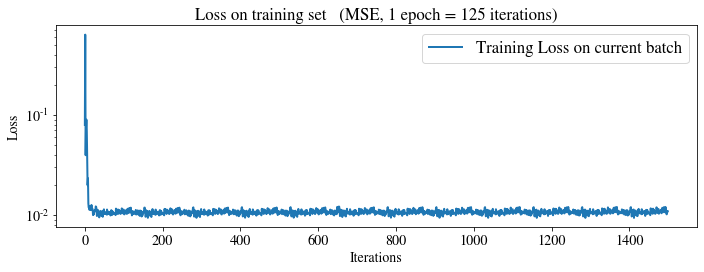

/var/folders/tn/nyh0947d6sngjfvtp7hbb0jr0000gn/T/ipykernel_5515/863207960.py:19: UserWarning: Glyph 9 (	) missing from current font.
  a=plt.savefig(path + '/valid_losses.png', dpi=150)
/Users/canrager/.pyenv/versions/3.9.11/envs/thenv/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


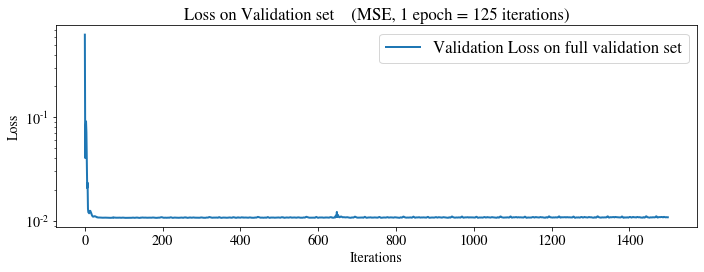

0.010918510643144448
./data/tomo0607_2qubit_random_uniform_vector/states10000_obs100/run_20220609_120804/ AE2Q_kleiner 10000.0 100 10 0.05 12
AutoencoderNet(
  (encoder): Sequential(
    (0): Linear(in_features=100, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=10, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=10, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=100, bias=True)
  )
)


100%|██████████| 12/12 [02:16<00:00, 11.34s/it]
/var/folders/tn/nyh0947d6sngjfvtp7hbb0jr0000gn/T/ipykernel_5515/863207960.py:9: UserWarning: Glyph 9 (	) missing from current font.
  a=plt.savefig(path + '/train_losses.png', dpi=150)


[0.07930724 0.02121753 0.01990683 ... 0.0109023  0.01092938 0.01102032]


/Users/canrager/.pyenv/versions/3.9.11/envs/thenv/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


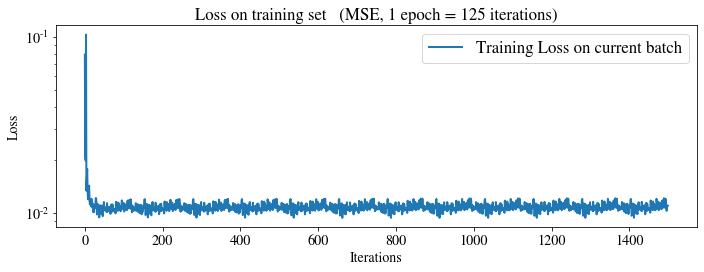

/var/folders/tn/nyh0947d6sngjfvtp7hbb0jr0000gn/T/ipykernel_5515/863207960.py:19: UserWarning: Glyph 9 (	) missing from current font.
  a=plt.savefig(path + '/valid_losses.png', dpi=150)
/Users/canrager/.pyenv/versions/3.9.11/envs/thenv/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


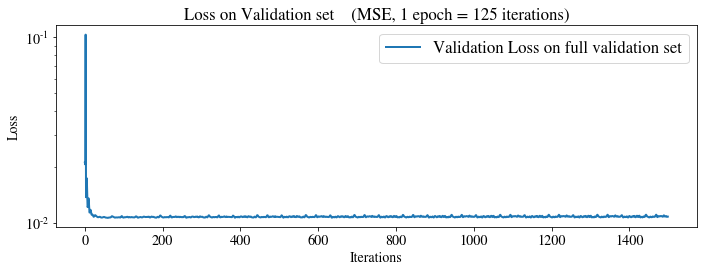

0.010926073230803014
./data/tomo0607_2qubit_random_uniform_vector/states10000_obs100/run_20220609_120804/ AE2Q_kleiner 10000.0 100 12 0.05 12
AutoencoderNet(
  (encoder): Sequential(
    (0): Linear(in_features=100, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=12, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=12, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=100, bias=True)
  )
)


100%|██████████| 12/12 [02:16<00:00, 11.33s/it]
/var/folders/tn/nyh0947d6sngjfvtp7hbb0jr0000gn/T/ipykernel_5515/863207960.py:9: UserWarning: Glyph 9 (	) missing from current font.
  a=plt.savefig(path + '/train_losses.png', dpi=150)


[0.07410629 1.15414    0.04585474 ... 0.01081304 0.01097755 0.01094259]


/Users/canrager/.pyenv/versions/3.9.11/envs/thenv/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


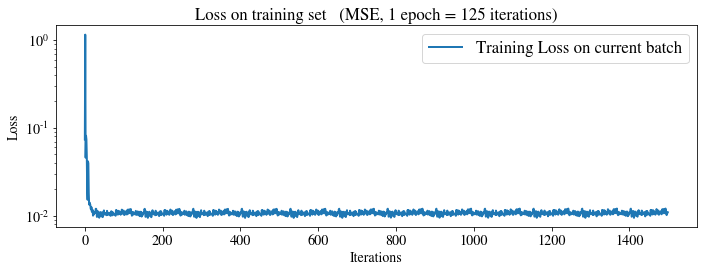

/var/folders/tn/nyh0947d6sngjfvtp7hbb0jr0000gn/T/ipykernel_5515/863207960.py:19: UserWarning: Glyph 9 (	) missing from current font.
  a=plt.savefig(path + '/valid_losses.png', dpi=150)
/Users/canrager/.pyenv/versions/3.9.11/envs/thenv/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


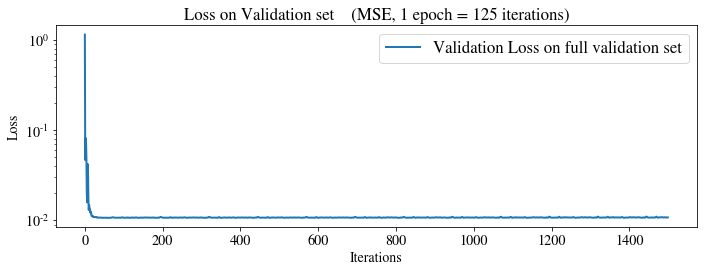

0.010910147925217946
./data/tomo0607_2qubit_random_uniform_vector/states10000_obs100/run_20220609_120804/ AE2Q_kleiner 10000.0 100 14 0.05 12
AutoencoderNet(
  (encoder): Sequential(
    (0): Linear(in_features=100, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=14, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=14, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=100, bias=True)
  )
)


100%|██████████| 12/12 [02:15<00:00, 11.33s/it]


[0.08685684 0.82890505 0.05279436 ... 0.01081037 0.01097376 0.01093106]


/var/folders/tn/nyh0947d6sngjfvtp7hbb0jr0000gn/T/ipykernel_5515/863207960.py:9: UserWarning: Glyph 9 (	) missing from current font.
  a=plt.savefig(path + '/train_losses.png', dpi=150)
/Users/canrager/.pyenv/versions/3.9.11/envs/thenv/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


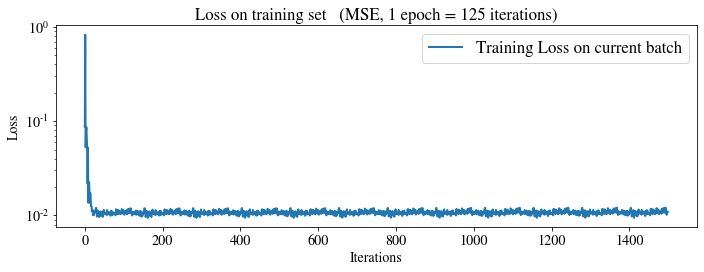

/var/folders/tn/nyh0947d6sngjfvtp7hbb0jr0000gn/T/ipykernel_5515/863207960.py:19: UserWarning: Glyph 9 (	) missing from current font.
  a=plt.savefig(path + '/valid_losses.png', dpi=150)
/Users/canrager/.pyenv/versions/3.9.11/envs/thenv/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


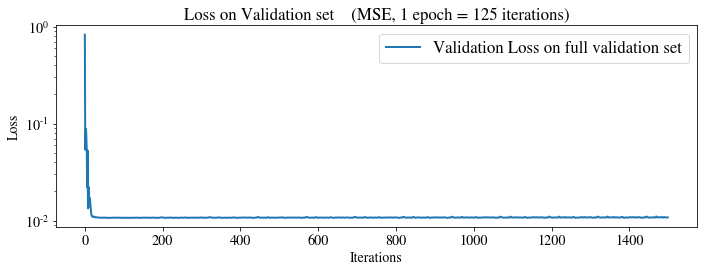

0.010889371670782567
./data/tomo0607_2qubit_random_uniform_vector/states10000_obs100/run_20220609_120804/ AE2Q_kleiner 10000.0 100 15 0.05 12
AutoencoderNet(
  (encoder): Sequential(
    (0): Linear(in_features=100, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=15, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=15, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=100, bias=True)
  )
)


100%|██████████| 12/12 [02:14<00:00, 11.23s/it]
/var/folders/tn/nyh0947d6sngjfvtp7hbb0jr0000gn/T/ipykernel_5515/863207960.py:9: UserWarning: Glyph 9 (	) missing from current font.
  a=plt.savefig(path + '/train_losses.png', dpi=150)


[0.08149253 0.03717452 0.02117462 ... 0.0109141  0.01092759 0.01102106]


/Users/canrager/.pyenv/versions/3.9.11/envs/thenv/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


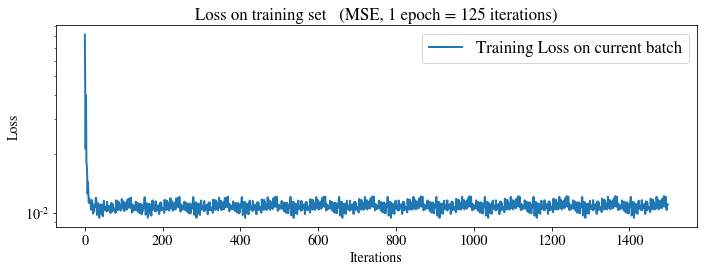

/var/folders/tn/nyh0947d6sngjfvtp7hbb0jr0000gn/T/ipykernel_5515/863207960.py:19: UserWarning: Glyph 9 (	) missing from current font.
  a=plt.savefig(path + '/valid_losses.png', dpi=150)
/Users/canrager/.pyenv/versions/3.9.11/envs/thenv/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


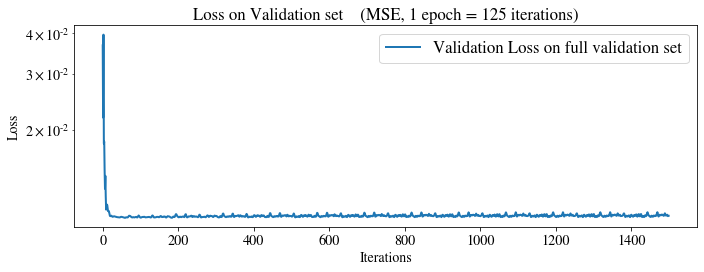

0.010921203469236692
./data/tomo0607_2qubit_random_uniform_vector/states10000_obs100/run_20220609_120804/ AE2Q_kleiner 10000.0 100 16 0.05 12
AutoencoderNet(
  (encoder): Sequential(
    (0): Linear(in_features=100, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=16, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=16, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=100, bias=True)
  )
)


100%|██████████| 12/12 [02:15<00:00, 11.32s/it]
/var/folders/tn/nyh0947d6sngjfvtp7hbb0jr0000gn/T/ipykernel_5515/863207960.py:9: UserWarning: Glyph 9 (	) missing from current font.
  a=plt.savefig(path + '/train_losses.png', dpi=150)


[0.07154769 0.04486618 0.01633137 ... 0.01090092 0.01093226 0.01101231]


/Users/canrager/.pyenv/versions/3.9.11/envs/thenv/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


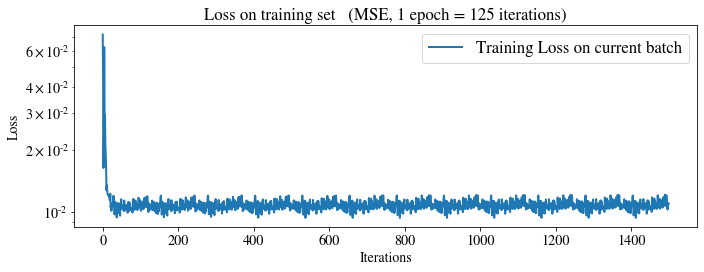

/var/folders/tn/nyh0947d6sngjfvtp7hbb0jr0000gn/T/ipykernel_5515/863207960.py:19: UserWarning: Glyph 9 (	) missing from current font.
  a=plt.savefig(path + '/valid_losses.png', dpi=150)
/Users/canrager/.pyenv/versions/3.9.11/envs/thenv/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


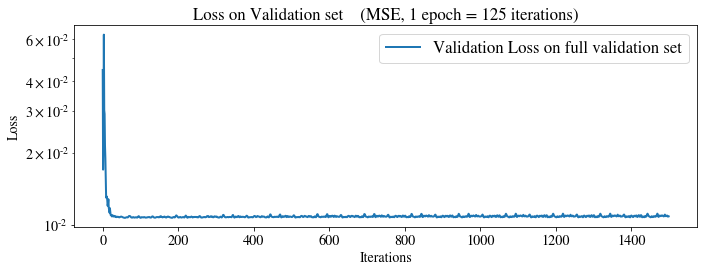

0.010917656620343526
./data/tomo0607_2qubit_random_uniform_vector/states10000_obs100/run_20220609_120804/ AE2Q_kleiner 10000.0 100 18 0.05 12
AutoencoderNet(
  (encoder): Sequential(
    (0): Linear(in_features=100, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=18, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=18, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=100, bias=True)
  )
)


100%|██████████| 12/12 [02:15<00:00, 11.26s/it]
/var/folders/tn/nyh0947d6sngjfvtp7hbb0jr0000gn/T/ipykernel_5515/863207960.py:9: UserWarning: Glyph 9 (	) missing from current font.
  a=plt.savefig(path + '/train_losses.png', dpi=150)


[0.07616165 0.10245106 0.02751522 ... 0.01089754 0.01092267 0.01100703]


/Users/canrager/.pyenv/versions/3.9.11/envs/thenv/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


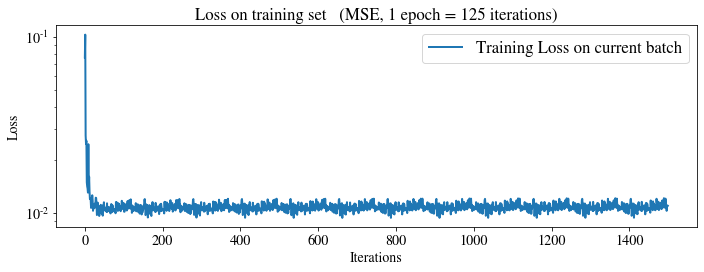

/var/folders/tn/nyh0947d6sngjfvtp7hbb0jr0000gn/T/ipykernel_5515/863207960.py:19: UserWarning: Glyph 9 (	) missing from current font.
  a=plt.savefig(path + '/valid_losses.png', dpi=150)
/Users/canrager/.pyenv/versions/3.9.11/envs/thenv/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


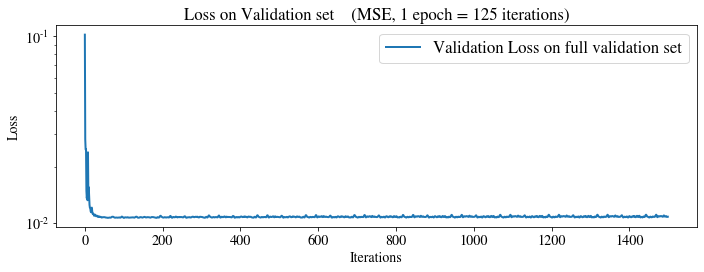

0.010920082094768684
./data/tomo0607_2qubit_random_uniform_vector/states10000_obs100/run_20220609_120804/ AE2Q_kleiner 10000.0 100 20 0.05 12
AutoencoderNet(
  (encoder): Sequential(
    (0): Linear(in_features=100, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=20, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=20, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=100, bias=True)
  )
)


100%|██████████| 12/12 [02:15<00:00, 11.29s/it]
/var/folders/tn/nyh0947d6sngjfvtp7hbb0jr0000gn/T/ipykernel_5515/863207960.py:9: UserWarning: Glyph 9 (	) missing from current font.
  a=plt.savefig(path + '/train_losses.png', dpi=150)


[0.07514957 0.45097652 0.03853763 ... 0.01082086 0.01097425 0.01094503]


/Users/canrager/.pyenv/versions/3.9.11/envs/thenv/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


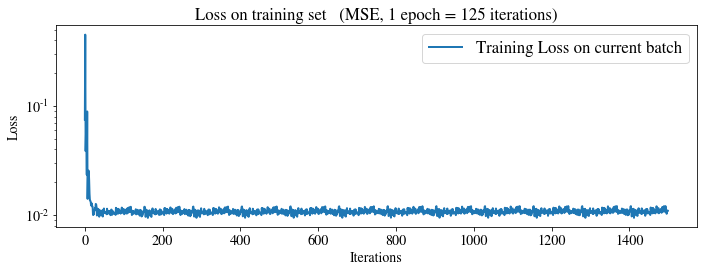

/var/folders/tn/nyh0947d6sngjfvtp7hbb0jr0000gn/T/ipykernel_5515/863207960.py:19: UserWarning: Glyph 9 (	) missing from current font.
  a=plt.savefig(path + '/valid_losses.png', dpi=150)
/Users/canrager/.pyenv/versions/3.9.11/envs/thenv/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


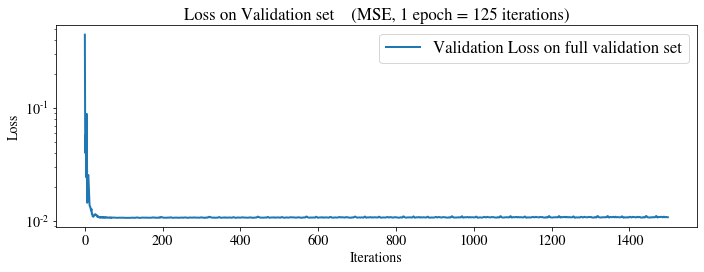

0.01091018548856179
./data/tomo0607_2qubit_random_uniform_vector/states10000_obs100/run_20220609_120804/ AE2Q_kleiner 10000.0 100 25 0.05 12
AutoencoderNet(
  (encoder): Sequential(
    (0): Linear(in_features=100, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=25, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=25, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=100, bias=True)
  )
)


100%|██████████| 12/12 [02:16<00:00, 11.34s/it]
/var/folders/tn/nyh0947d6sngjfvtp7hbb0jr0000gn/T/ipykernel_5515/863207960.py:9: UserWarning: Glyph 9 (	) missing from current font.
  a=plt.savefig(path + '/train_losses.png', dpi=150)


[0.08239716 0.03816155 0.01803767 ... 0.01090946 0.01093152 0.01102008]


/Users/canrager/.pyenv/versions/3.9.11/envs/thenv/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


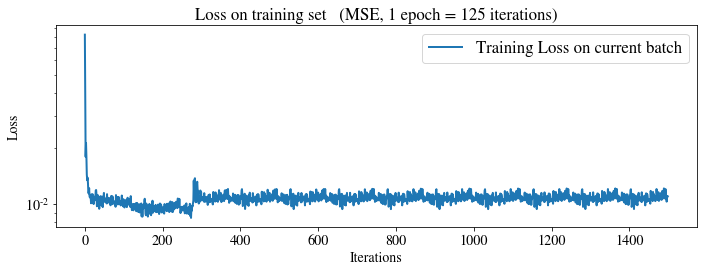

/var/folders/tn/nyh0947d6sngjfvtp7hbb0jr0000gn/T/ipykernel_5515/863207960.py:19: UserWarning: Glyph 9 (	) missing from current font.
  a=plt.savefig(path + '/valid_losses.png', dpi=150)
/Users/canrager/.pyenv/versions/3.9.11/envs/thenv/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


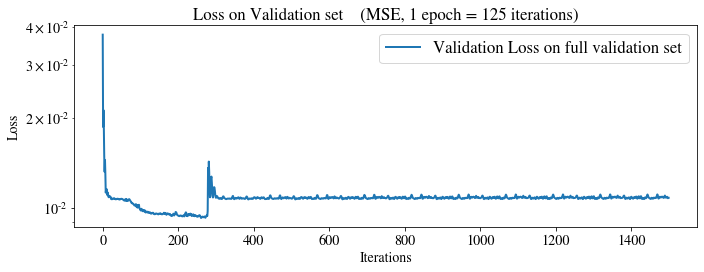

0.010920937110980352
./data/tomo0607_2qubit_random_uniform_vector/states10000_obs100/run_20220609_120804/ AE2Q_kleiner 10000.0 100 30 0.05 12
AutoencoderNet(
  (encoder): Sequential(
    (0): Linear(in_features=100, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=30, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=30, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=100, bias=True)
  )
)


100%|██████████| 12/12 [02:16<00:00, 11.39s/it]
/var/folders/tn/nyh0947d6sngjfvtp7hbb0jr0000gn/T/ipykernel_5515/863207960.py:9: UserWarning: Glyph 9 (	) missing from current font.
  a=plt.savefig(path + '/train_losses.png', dpi=150)


[0.08263965 0.02338779 0.0188808  ... 0.01091938 0.01092569 0.01101818]


/Users/canrager/.pyenv/versions/3.9.11/envs/thenv/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


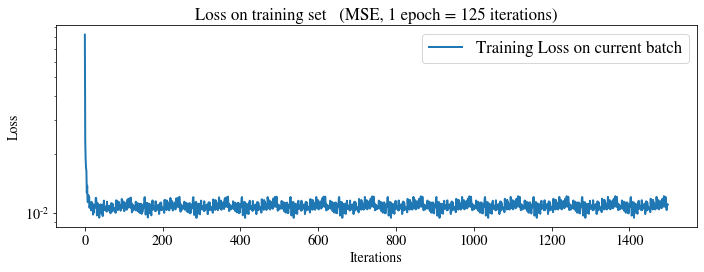

/var/folders/tn/nyh0947d6sngjfvtp7hbb0jr0000gn/T/ipykernel_5515/863207960.py:19: UserWarning: Glyph 9 (	) missing from current font.
  a=plt.savefig(path + '/valid_losses.png', dpi=150)
/Users/canrager/.pyenv/versions/3.9.11/envs/thenv/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


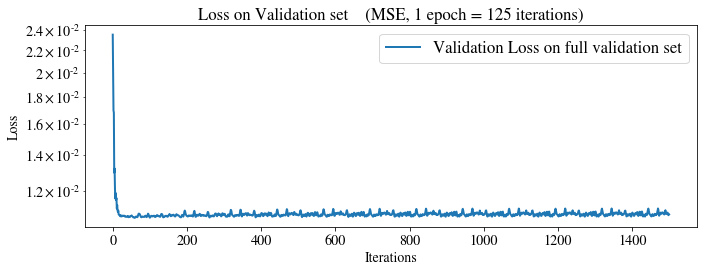

0.010924951297541459
./data/tomo0607_2qubit_random_uniform_vector/states10000_obs100/run_20220609_120749/ AE2Q_kleiner 10000.0 100 1 0.05 12
AutoencoderNet(
  (encoder): Sequential(
    (0): Linear(in_features=100, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=1, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=1, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=100, bias=True)
  )
)


100%|██████████| 12/12 [02:18<00:00, 11.55s/it]
/var/folders/tn/nyh0947d6sngjfvtp7hbb0jr0000gn/T/ipykernel_5515/863207960.py:9: UserWarning: Glyph 9 (	) missing from current font.
  a=plt.savefig(path + '/train_losses.png', dpi=150)


[0.08792625 0.90230107 0.02760189 ... 0.00935643 0.00915842 0.00907257]


/Users/canrager/.pyenv/versions/3.9.11/envs/thenv/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


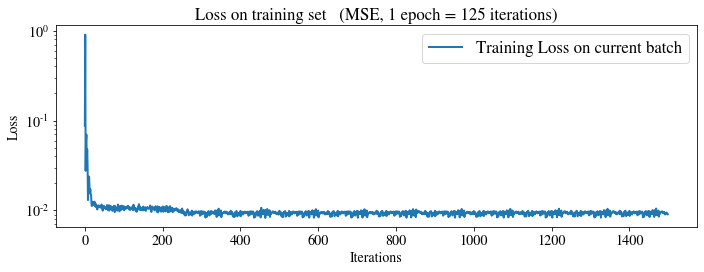

/var/folders/tn/nyh0947d6sngjfvtp7hbb0jr0000gn/T/ipykernel_5515/863207960.py:19: UserWarning: Glyph 9 (	) missing from current font.
  a=plt.savefig(path + '/valid_losses.png', dpi=150)
/Users/canrager/.pyenv/versions/3.9.11/envs/thenv/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


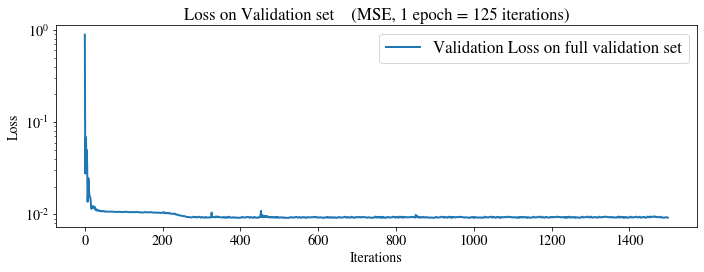

0.00937807522714138
./data/tomo0607_2qubit_random_uniform_vector/states10000_obs100/run_20220609_120749/ AE2Q_kleiner 10000.0 100 5 0.05 12
AutoencoderNet(
  (encoder): Sequential(
    (0): Linear(in_features=100, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=5, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=5, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=100, bias=True)
  )
)


100%|██████████| 12/12 [02:15<00:00, 11.32s/it]
/var/folders/tn/nyh0947d6sngjfvtp7hbb0jr0000gn/T/ipykernel_5515/863207960.py:9: UserWarning: Glyph 9 (	) missing from current font.
  a=plt.savefig(path + '/train_losses.png', dpi=150)


[0.08743171 0.05313346 0.02164907 ... 0.01113451 0.01045957 0.01025071]


/Users/canrager/.pyenv/versions/3.9.11/envs/thenv/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


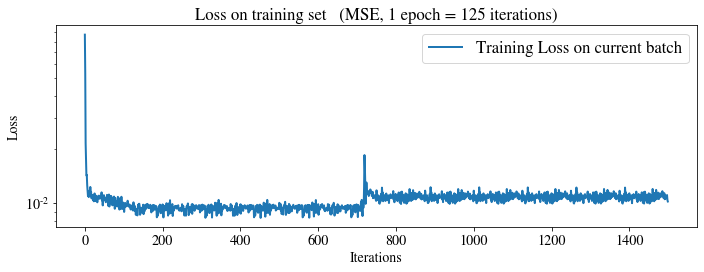

/var/folders/tn/nyh0947d6sngjfvtp7hbb0jr0000gn/T/ipykernel_5515/863207960.py:19: UserWarning: Glyph 9 (	) missing from current font.
  a=plt.savefig(path + '/valid_losses.png', dpi=150)
/Users/canrager/.pyenv/versions/3.9.11/envs/thenv/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


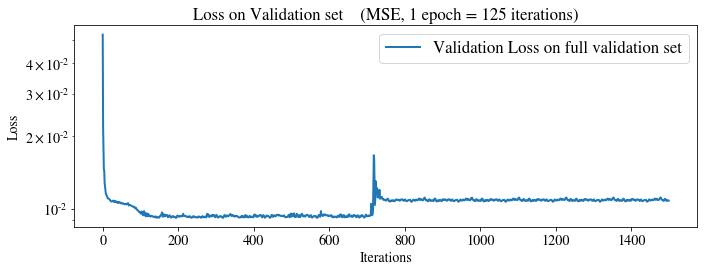

0.011014147413273652
./data/tomo0607_2qubit_random_uniform_vector/states10000_obs100/run_20220609_120749/ AE2Q_kleiner 10000.0 100 10 0.05 12
AutoencoderNet(
  (encoder): Sequential(
    (0): Linear(in_features=100, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=10, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=10, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=100, bias=True)
  )
)


100%|██████████| 12/12 [02:15<00:00, 11.30s/it]
/var/folders/tn/nyh0947d6sngjfvtp7hbb0jr0000gn/T/ipykernel_5515/863207960.py:9: UserWarning: Glyph 9 (	) missing from current font.
  a=plt.savefig(path + '/train_losses.png', dpi=150)


[0.0823913  0.29055238 0.04450867 ... 0.01112622 0.01043695 0.01027935]


/Users/canrager/.pyenv/versions/3.9.11/envs/thenv/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


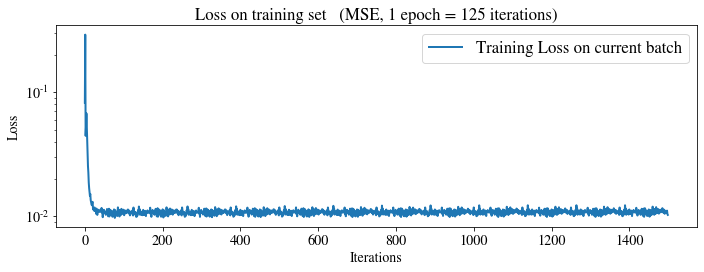

/var/folders/tn/nyh0947d6sngjfvtp7hbb0jr0000gn/T/ipykernel_5515/863207960.py:19: UserWarning: Glyph 9 (	) missing from current font.
  a=plt.savefig(path + '/valid_losses.png', dpi=150)
/Users/canrager/.pyenv/versions/3.9.11/envs/thenv/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


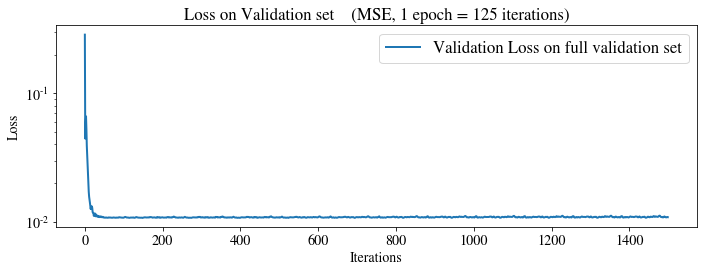

0.011029187900324663
./data/tomo0607_2qubit_random_uniform_vector/states10000_obs100/run_20220609_120749/ AE2Q_kleiner 10000.0 100 12 0.05 12
AutoencoderNet(
  (encoder): Sequential(
    (0): Linear(in_features=100, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=12, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=12, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=100, bias=True)
  )
)


100%|██████████| 12/12 [02:16<00:00, 11.35s/it]
/var/folders/tn/nyh0947d6sngjfvtp7hbb0jr0000gn/T/ipykernel_5515/863207960.py:9: UserWarning: Glyph 9 (	) missing from current font.
  a=plt.savefig(path + '/train_losses.png', dpi=150)


[0.08071658 0.16737965 0.04013771 ... 0.01125144 0.01026505 0.01020629]


/Users/canrager/.pyenv/versions/3.9.11/envs/thenv/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


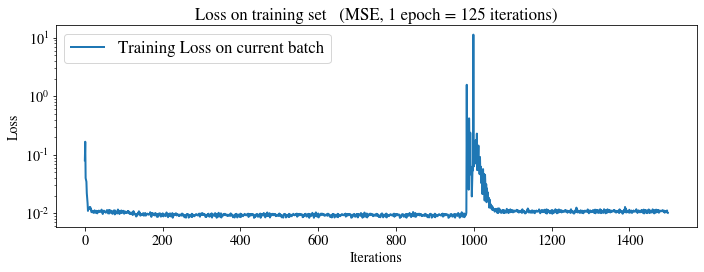

/var/folders/tn/nyh0947d6sngjfvtp7hbb0jr0000gn/T/ipykernel_5515/863207960.py:19: UserWarning: Glyph 9 (	) missing from current font.
  a=plt.savefig(path + '/valid_losses.png', dpi=150)
/Users/canrager/.pyenv/versions/3.9.11/envs/thenv/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


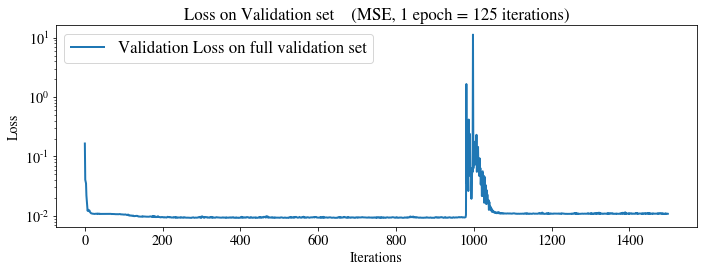

0.010938187626500924
./data/tomo0607_2qubit_random_uniform_vector/states10000_obs100/run_20220609_120749/ AE2Q_kleiner 10000.0 100 14 0.05 12
AutoencoderNet(
  (encoder): Sequential(
    (0): Linear(in_features=100, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=14, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=14, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=100, bias=True)
  )
)


100%|██████████| 12/12 [02:16<00:00, 11.35s/it]
/var/folders/tn/nyh0947d6sngjfvtp7hbb0jr0000gn/T/ipykernel_5515/863207960.py:9: UserWarning: Glyph 9 (	) missing from current font.
  a=plt.savefig(path + '/train_losses.png', dpi=150)


[0.07983173 0.18710206 0.03638703 ... 0.01113517 0.01046194 0.01026484]


/Users/canrager/.pyenv/versions/3.9.11/envs/thenv/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


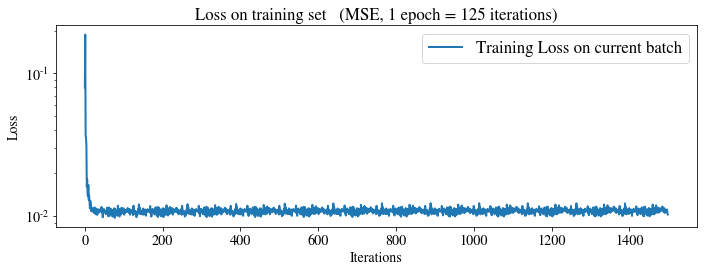

/var/folders/tn/nyh0947d6sngjfvtp7hbb0jr0000gn/T/ipykernel_5515/863207960.py:19: UserWarning: Glyph 9 (	) missing from current font.
  a=plt.savefig(path + '/valid_losses.png', dpi=150)
/Users/canrager/.pyenv/versions/3.9.11/envs/thenv/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


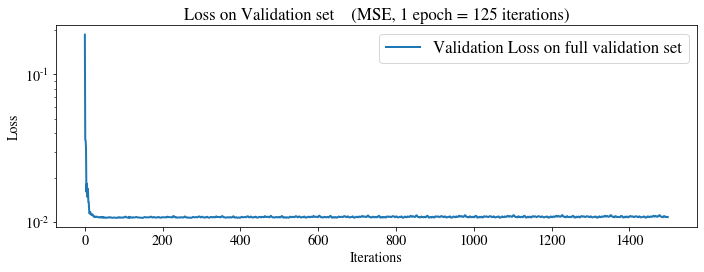

0.01102724534769853
./data/tomo0607_2qubit_random_uniform_vector/states10000_obs100/run_20220609_120749/ AE2Q_kleiner 10000.0 100 15 0.05 12
AutoencoderNet(
  (encoder): Sequential(
    (0): Linear(in_features=100, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=15, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=15, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=100, bias=True)
  )
)


100%|██████████| 12/12 [02:16<00:00, 11.36s/it]
/var/folders/tn/nyh0947d6sngjfvtp7hbb0jr0000gn/T/ipykernel_5515/863207960.py:9: UserWarning: Glyph 9 (	) missing from current font.
  a=plt.savefig(path + '/train_losses.png', dpi=150)


[0.0718886  0.2131279  0.02748338 ... 0.01112973 0.01045865 0.01026449]


/Users/canrager/.pyenv/versions/3.9.11/envs/thenv/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


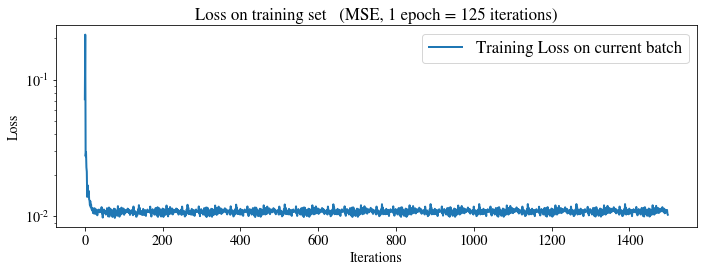

/var/folders/tn/nyh0947d6sngjfvtp7hbb0jr0000gn/T/ipykernel_5515/863207960.py:19: UserWarning: Glyph 9 (	) missing from current font.
  a=plt.savefig(path + '/valid_losses.png', dpi=150)
/Users/canrager/.pyenv/versions/3.9.11/envs/thenv/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


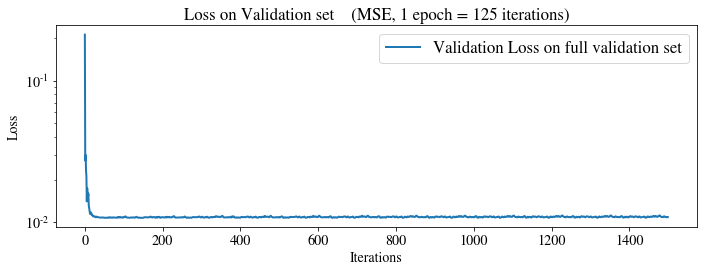

0.011030301700035732
./data/tomo0607_2qubit_random_uniform_vector/states10000_obs100/run_20220609_120749/ AE2Q_kleiner 10000.0 100 16 0.05 12
AutoencoderNet(
  (encoder): Sequential(
    (0): Linear(in_features=100, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=16, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=16, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=100, bias=True)
  )
)


100%|██████████| 12/12 [02:16<00:00, 11.36s/it]
/var/folders/tn/nyh0947d6sngjfvtp7hbb0jr0000gn/T/ipykernel_5515/863207960.py:9: UserWarning: Glyph 9 (	) missing from current font.
  a=plt.savefig(path + '/train_losses.png', dpi=150)


[0.07532817 0.04654469 0.0283312  ... 0.01114124 0.01045513 0.01025805]


/Users/canrager/.pyenv/versions/3.9.11/envs/thenv/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


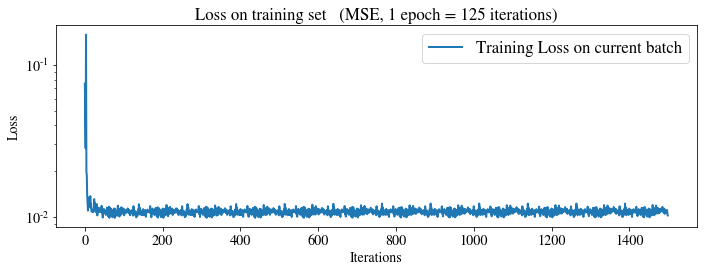

/var/folders/tn/nyh0947d6sngjfvtp7hbb0jr0000gn/T/ipykernel_5515/863207960.py:19: UserWarning: Glyph 9 (	) missing from current font.
  a=plt.savefig(path + '/valid_losses.png', dpi=150)
/Users/canrager/.pyenv/versions/3.9.11/envs/thenv/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


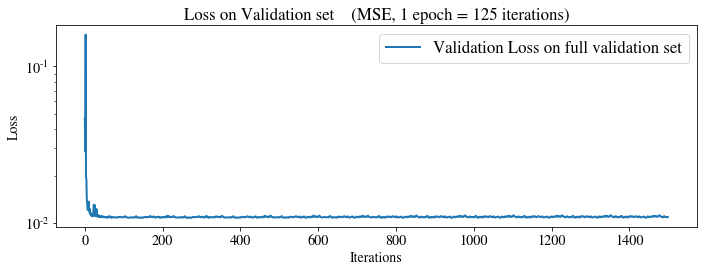

0.011026670349140962
./data/tomo0607_2qubit_random_uniform_vector/states10000_obs100/run_20220609_120749/ AE2Q_kleiner 10000.0 100 18 0.05 12
AutoencoderNet(
  (encoder): Sequential(
    (0): Linear(in_features=100, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=18, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=18, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=100, bias=True)
  )
)


100%|██████████| 12/12 [02:15<00:00, 11.33s/it]
/var/folders/tn/nyh0947d6sngjfvtp7hbb0jr0000gn/T/ipykernel_5515/863207960.py:9: UserWarning: Glyph 9 (	) missing from current font.
  a=plt.savefig(path + '/train_losses.png', dpi=150)


[0.07721332 0.7065177  0.04798349 ... 0.01110757 0.01039592 0.01031935]


/Users/canrager/.pyenv/versions/3.9.11/envs/thenv/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


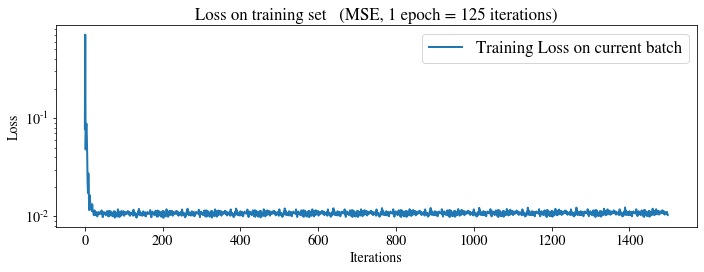

/var/folders/tn/nyh0947d6sngjfvtp7hbb0jr0000gn/T/ipykernel_5515/863207960.py:19: UserWarning: Glyph 9 (	) missing from current font.
  a=plt.savefig(path + '/valid_losses.png', dpi=150)
/Users/canrager/.pyenv/versions/3.9.11/envs/thenv/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


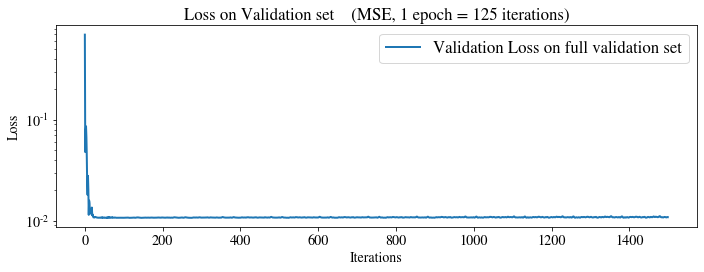

0.011060867458581924
./data/tomo0607_2qubit_random_uniform_vector/states10000_obs100/run_20220609_120749/ AE2Q_kleiner 10000.0 100 20 0.05 12
AutoencoderNet(
  (encoder): Sequential(
    (0): Linear(in_features=100, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=20, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=20, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=100, bias=True)
  )
)


100%|██████████| 12/12 [02:17<00:00, 11.42s/it]
/var/folders/tn/nyh0947d6sngjfvtp7hbb0jr0000gn/T/ipykernel_5515/863207960.py:9: UserWarning: Glyph 9 (	) missing from current font.
  a=plt.savefig(path + '/train_losses.png', dpi=150)


[0.08460263 0.12981743 0.02952377 ... 0.01113637 0.01045809 0.01025497]


/Users/canrager/.pyenv/versions/3.9.11/envs/thenv/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


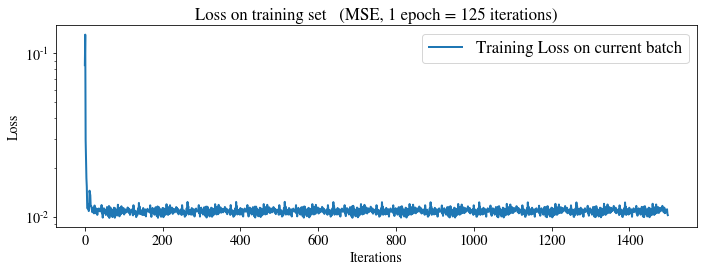

/var/folders/tn/nyh0947d6sngjfvtp7hbb0jr0000gn/T/ipykernel_5515/863207960.py:19: UserWarning: Glyph 9 (	) missing from current font.
  a=plt.savefig(path + '/valid_losses.png', dpi=150)
/Users/canrager/.pyenv/versions/3.9.11/envs/thenv/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


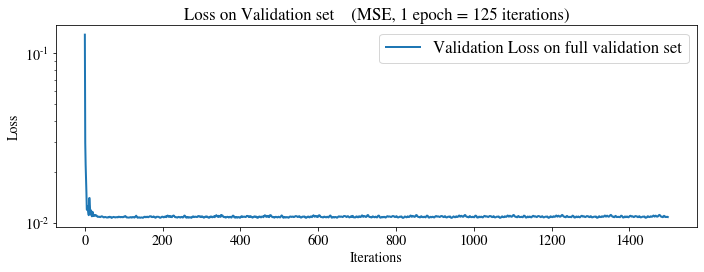

0.011016761201123397
./data/tomo0607_2qubit_random_uniform_vector/states10000_obs100/run_20220609_120749/ AE2Q_kleiner 10000.0 100 25 0.05 12
AutoencoderNet(
  (encoder): Sequential(
    (0): Linear(in_features=100, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=25, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=25, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=100, bias=True)
  )
)


100%|██████████| 12/12 [02:16<00:00, 11.38s/it]


[0.07927564 0.23250197 0.03902166 ... 0.01113675 0.01045754 0.01026212]


/var/folders/tn/nyh0947d6sngjfvtp7hbb0jr0000gn/T/ipykernel_5515/863207960.py:9: UserWarning: Glyph 9 (	) missing from current font.
  a=plt.savefig(path + '/train_losses.png', dpi=150)
/Users/canrager/.pyenv/versions/3.9.11/envs/thenv/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


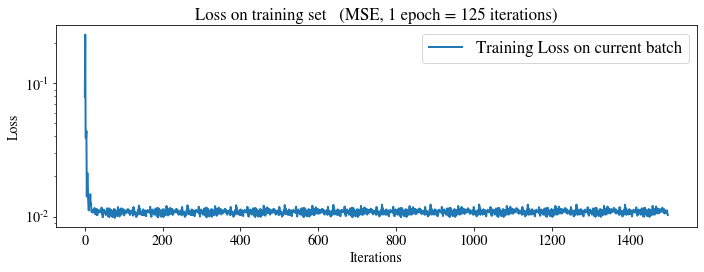

/var/folders/tn/nyh0947d6sngjfvtp7hbb0jr0000gn/T/ipykernel_5515/863207960.py:19: UserWarning: Glyph 9 (	) missing from current font.
  a=plt.savefig(path + '/valid_losses.png', dpi=150)
/Users/canrager/.pyenv/versions/3.9.11/envs/thenv/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


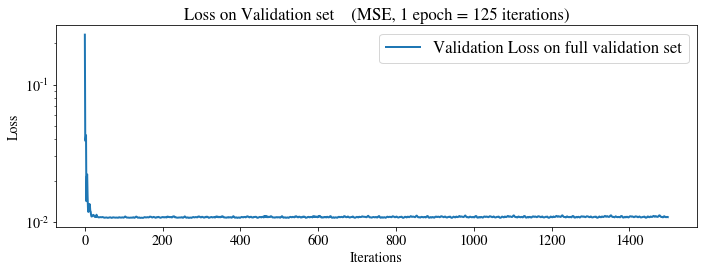

0.011034116645654042
./data/tomo0607_2qubit_random_uniform_vector/states10000_obs100/run_20220609_120749/ AE2Q_kleiner 10000.0 100 30 0.05 12
AutoencoderNet(
  (encoder): Sequential(
    (0): Linear(in_features=100, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=30, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=30, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=100, bias=True)
  )
)


100%|██████████| 12/12 [02:15<00:00, 11.28s/it]
/var/folders/tn/nyh0947d6sngjfvtp7hbb0jr0000gn/T/ipykernel_5515/863207960.py:9: UserWarning: Glyph 9 (	) missing from current font.
  a=plt.savefig(path + '/train_losses.png', dpi=150)


[0.0764123  0.06379779 0.03267178 ... 0.01113313 0.01045711 0.01024885]


/Users/canrager/.pyenv/versions/3.9.11/envs/thenv/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


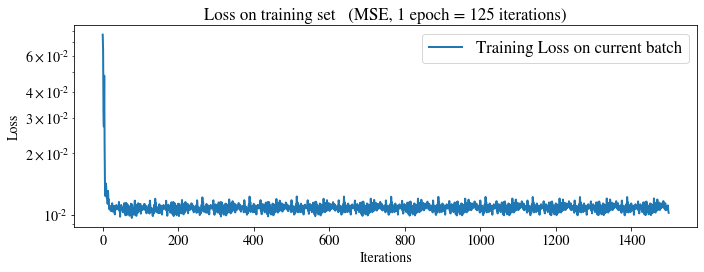

/var/folders/tn/nyh0947d6sngjfvtp7hbb0jr0000gn/T/ipykernel_5515/863207960.py:19: UserWarning: Glyph 9 (	) missing from current font.
  a=plt.savefig(path + '/valid_losses.png', dpi=150)
/Users/canrager/.pyenv/versions/3.9.11/envs/thenv/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


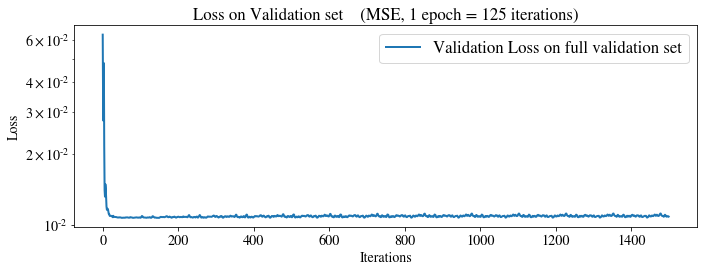

0.011007701729734738
./data/tomo0607_2qubit_random_uniform_vector/states10000_obs100/run_20220609_120759/ AE2Q_kleiner 10000.0 100 1 0.05 12
AutoencoderNet(
  (encoder): Sequential(
    (0): Linear(in_features=100, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=1, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=1, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=100, bias=True)
  )
)


100%|██████████| 12/12 [02:15<00:00, 11.33s/it]
/var/folders/tn/nyh0947d6sngjfvtp7hbb0jr0000gn/T/ipykernel_5515/863207960.py:9: UserWarning: Glyph 9 (	) missing from current font.
  a=plt.savefig(path + '/train_losses.png', dpi=150)


[0.08242223 0.17377992 0.02354679 ... 0.01132321 0.01077177 0.01097086]


/Users/canrager/.pyenv/versions/3.9.11/envs/thenv/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


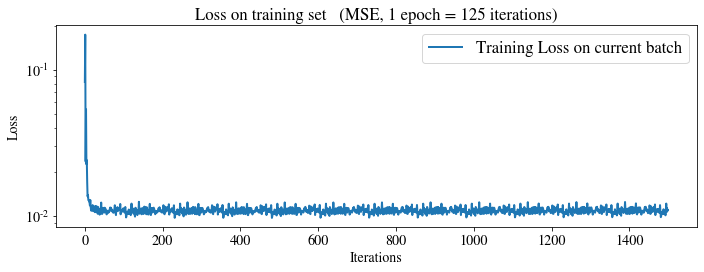

/var/folders/tn/nyh0947d6sngjfvtp7hbb0jr0000gn/T/ipykernel_5515/863207960.py:19: UserWarning: Glyph 9 (	) missing from current font.
  a=plt.savefig(path + '/valid_losses.png', dpi=150)
/Users/canrager/.pyenv/versions/3.9.11/envs/thenv/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


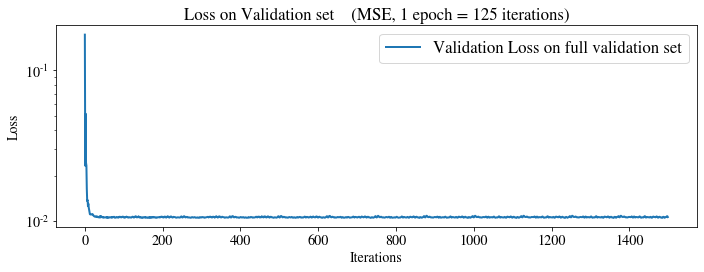

0.01067494967331489
./data/tomo0607_2qubit_random_uniform_vector/states10000_obs100/run_20220609_120759/ AE2Q_kleiner 10000.0 100 5 0.05 12
AutoencoderNet(
  (encoder): Sequential(
    (0): Linear(in_features=100, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=5, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=5, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=100, bias=True)
  )
)


100%|██████████| 12/12 [02:16<00:00, 11.40s/it]
/var/folders/tn/nyh0947d6sngjfvtp7hbb0jr0000gn/T/ipykernel_5515/863207960.py:9: UserWarning: Glyph 9 (	) missing from current font.
  a=plt.savefig(path + '/train_losses.png', dpi=150)


[0.07708832 0.04247355 0.02340327 ... 0.01131496 0.01078931 0.0109706 ]


/Users/canrager/.pyenv/versions/3.9.11/envs/thenv/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


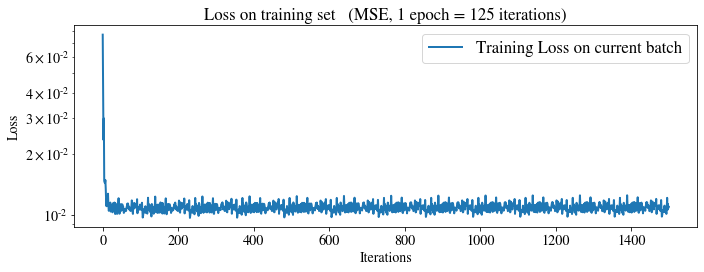

/var/folders/tn/nyh0947d6sngjfvtp7hbb0jr0000gn/T/ipykernel_5515/863207960.py:19: UserWarning: Glyph 9 (	) missing from current font.
  a=plt.savefig(path + '/valid_losses.png', dpi=150)
/Users/canrager/.pyenv/versions/3.9.11/envs/thenv/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


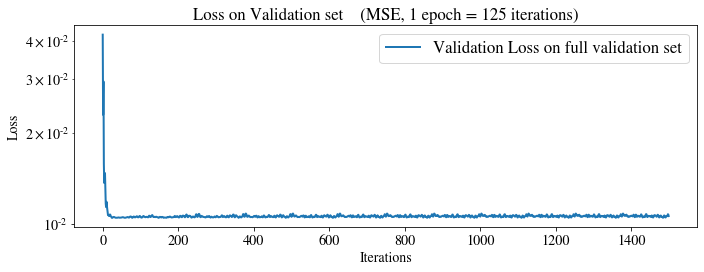

0.010674781041840713
./data/tomo0607_2qubit_random_uniform_vector/states10000_obs100/run_20220609_120759/ AE2Q_kleiner 10000.0 100 10 0.05 12
AutoencoderNet(
  (encoder): Sequential(
    (0): Linear(in_features=100, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=10, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=10, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=100, bias=True)
  )
)


100%|██████████| 12/12 [02:15<00:00, 11.32s/it]
/var/folders/tn/nyh0947d6sngjfvtp7hbb0jr0000gn/T/ipykernel_5515/863207960.py:9: UserWarning: Glyph 9 (	) missing from current font.
  a=plt.savefig(path + '/train_losses.png', dpi=150)


[0.08774092 0.02560121 0.01588589 ... 0.00927878 0.00932083 0.00955281]


/Users/canrager/.pyenv/versions/3.9.11/envs/thenv/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


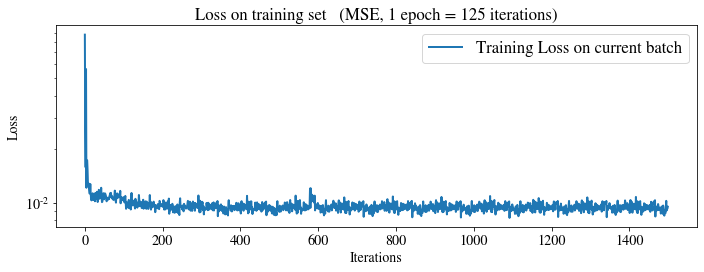

/var/folders/tn/nyh0947d6sngjfvtp7hbb0jr0000gn/T/ipykernel_5515/863207960.py:19: UserWarning: Glyph 9 (	) missing from current font.
  a=plt.savefig(path + '/valid_losses.png', dpi=150)
/Users/canrager/.pyenv/versions/3.9.11/envs/thenv/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


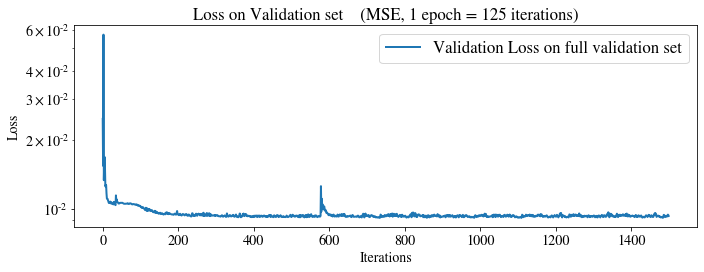

0.009247016968826453
./data/tomo0607_2qubit_random_uniform_vector/states10000_obs100/run_20220609_120759/ AE2Q_kleiner 10000.0 100 12 0.05 12
AutoencoderNet(
  (encoder): Sequential(
    (0): Linear(in_features=100, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=12, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=12, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=100, bias=True)
  )
)


100%|██████████| 12/12 [02:16<00:00, 11.35s/it]
/var/folders/tn/nyh0947d6sngjfvtp7hbb0jr0000gn/T/ipykernel_5515/863207960.py:9: UserWarning: Glyph 9 (	) missing from current font.
  a=plt.savefig(path + '/train_losses.png', dpi=150)


[0.07708599 0.44263211 0.02259358 ... 0.01135354 0.01073723 0.01100732]


/Users/canrager/.pyenv/versions/3.9.11/envs/thenv/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


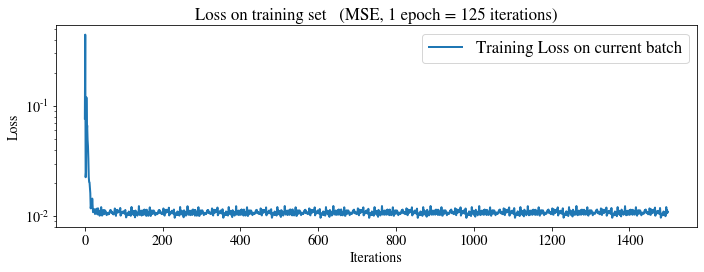

/var/folders/tn/nyh0947d6sngjfvtp7hbb0jr0000gn/T/ipykernel_5515/863207960.py:19: UserWarning: Glyph 9 (	) missing from current font.
  a=plt.savefig(path + '/valid_losses.png', dpi=150)
/Users/canrager/.pyenv/versions/3.9.11/envs/thenv/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


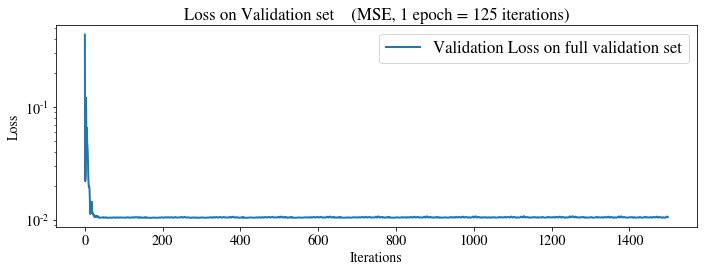

0.010700219807525476
./data/tomo0607_2qubit_random_uniform_vector/states10000_obs100/run_20220609_120759/ AE2Q_kleiner 10000.0 100 14 0.05 12
AutoencoderNet(
  (encoder): Sequential(
    (0): Linear(in_features=100, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=14, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=14, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=100, bias=True)
  )
)


100%|██████████| 12/12 [02:17<00:00, 11.46s/it]
/var/folders/tn/nyh0947d6sngjfvtp7hbb0jr0000gn/T/ipykernel_5515/863207960.py:9: UserWarning: Glyph 9 (	) missing from current font.
  a=plt.savefig(path + '/train_losses.png', dpi=150)


[0.07746304 0.30386141 0.04579747 ... 0.01133206 0.01074817 0.01098869]


/Users/canrager/.pyenv/versions/3.9.11/envs/thenv/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


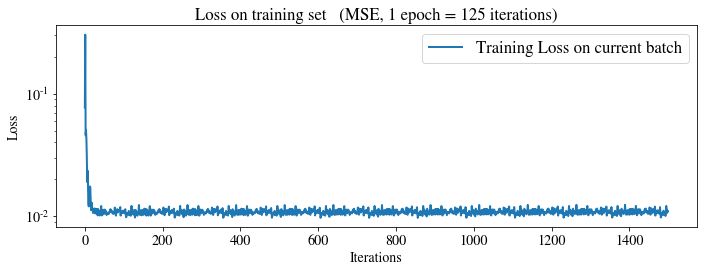

/var/folders/tn/nyh0947d6sngjfvtp7hbb0jr0000gn/T/ipykernel_5515/863207960.py:19: UserWarning: Glyph 9 (	) missing from current font.
  a=plt.savefig(path + '/valid_losses.png', dpi=150)
/Users/canrager/.pyenv/versions/3.9.11/envs/thenv/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


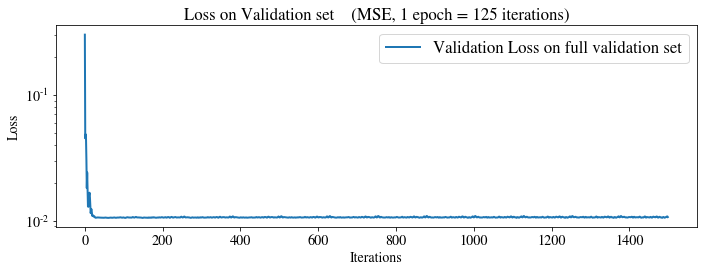

0.010687791742384434
./data/tomo0607_2qubit_random_uniform_vector/states10000_obs100/run_20220609_120759/ AE2Q_kleiner 10000.0 100 15 0.05 12
AutoencoderNet(
  (encoder): Sequential(
    (0): Linear(in_features=100, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=15, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=15, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=100, bias=True)
  )
)


100%|██████████| 12/12 [17:29<00:00, 87.46s/it] 
/var/folders/tn/nyh0947d6sngjfvtp7hbb0jr0000gn/T/ipykernel_5515/863207960.py:9: UserWarning: Glyph 9 (	) missing from current font.
  a=plt.savefig(path + '/train_losses.png', dpi=150)


[0.0910478  0.69206345 0.05949581 ... 0.00925841 0.00921658 0.00960753]


/Users/canrager/.pyenv/versions/3.9.11/envs/thenv/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


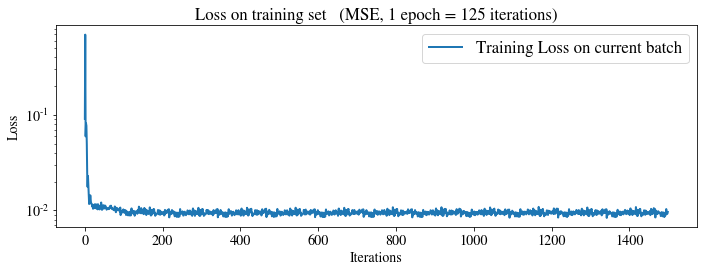

/var/folders/tn/nyh0947d6sngjfvtp7hbb0jr0000gn/T/ipykernel_5515/863207960.py:19: UserWarning: Glyph 9 (	) missing from current font.
  a=plt.savefig(path + '/valid_losses.png', dpi=150)
/Users/canrager/.pyenv/versions/3.9.11/envs/thenv/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


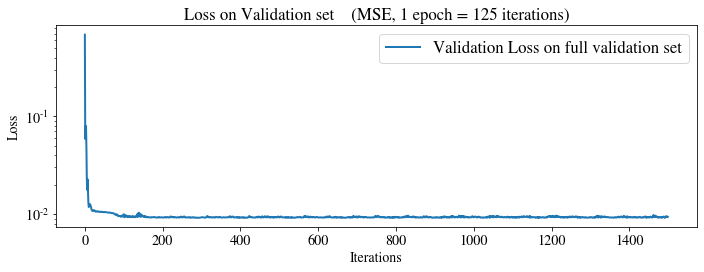

0.009316049640377362
./data/tomo0607_2qubit_random_uniform_vector/states10000_obs100/run_20220609_120759/ AE2Q_kleiner 10000.0 100 16 0.05 12
AutoencoderNet(
  (encoder): Sequential(
    (0): Linear(in_features=100, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=16, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=16, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=100, bias=True)
  )
)


100%|██████████| 12/12 [01:24<00:00,  7.05s/it]
/var/folders/tn/nyh0947d6sngjfvtp7hbb0jr0000gn/T/ipykernel_5515/863207960.py:9: UserWarning: Glyph 9 (	) missing from current font.
  a=plt.savefig(path + '/train_losses.png', dpi=150)


[0.08326162 0.05785713 0.03297177 ... 0.01131837 0.01078689 0.01096864]


/Users/canrager/.pyenv/versions/3.9.11/envs/thenv/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


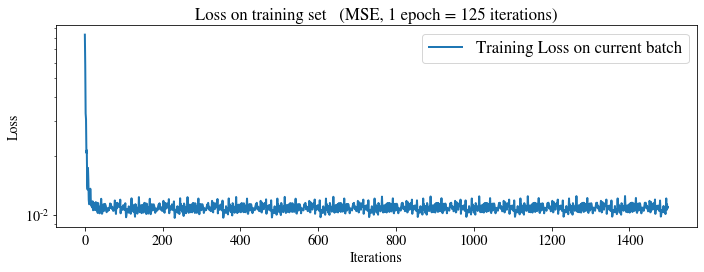

/var/folders/tn/nyh0947d6sngjfvtp7hbb0jr0000gn/T/ipykernel_5515/863207960.py:19: UserWarning: Glyph 9 (	) missing from current font.
  a=plt.savefig(path + '/valid_losses.png', dpi=150)
/Users/canrager/.pyenv/versions/3.9.11/envs/thenv/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


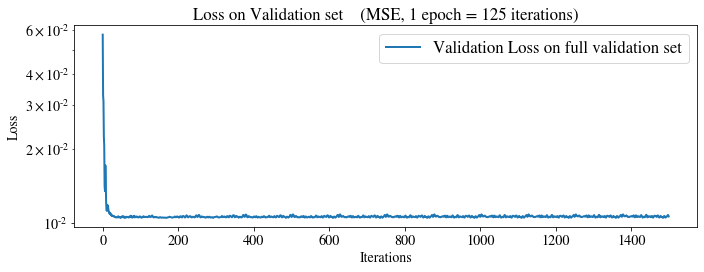

0.010674159352978071
./data/tomo0607_2qubit_random_uniform_vector/states10000_obs100/run_20220609_120759/ AE2Q_kleiner 10000.0 100 18 0.05 12
AutoencoderNet(
  (encoder): Sequential(
    (0): Linear(in_features=100, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=18, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=18, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=100, bias=True)
  )
)


100%|██████████| 12/12 [01:24<00:00,  7.03s/it]
/var/folders/tn/nyh0947d6sngjfvtp7hbb0jr0000gn/T/ipykernel_5515/863207960.py:9: UserWarning: Glyph 9 (	) missing from current font.
  a=plt.savefig(path + '/train_losses.png', dpi=150)


[0.07163791 0.18357114 0.02148907 ... 0.01132804 0.01076467 0.01096311]


/Users/canrager/.pyenv/versions/3.9.11/envs/thenv/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


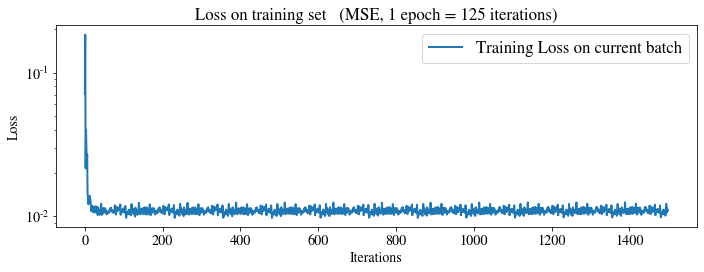

/var/folders/tn/nyh0947d6sngjfvtp7hbb0jr0000gn/T/ipykernel_5515/863207960.py:19: UserWarning: Glyph 9 (	) missing from current font.
  a=plt.savefig(path + '/valid_losses.png', dpi=150)
/Users/canrager/.pyenv/versions/3.9.11/envs/thenv/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


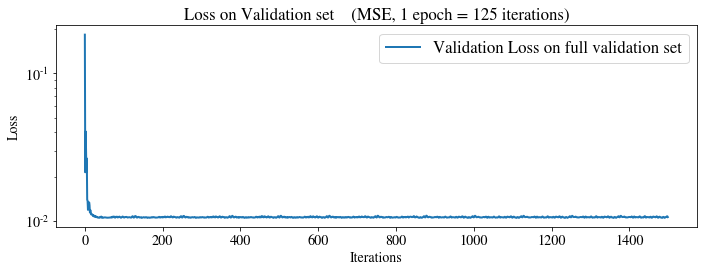

0.010672265912095706
./data/tomo0607_2qubit_random_uniform_vector/states10000_obs100/run_20220609_120759/ AE2Q_kleiner 10000.0 100 20 0.05 12
AutoencoderNet(
  (encoder): Sequential(
    (0): Linear(in_features=100, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=20, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=20, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=100, bias=True)
  )
)


100%|██████████| 12/12 [01:23<00:00,  6.98s/it]
/var/folders/tn/nyh0947d6sngjfvtp7hbb0jr0000gn/T/ipykernel_5515/863207960.py:9: UserWarning: Glyph 9 (	) missing from current font.
  a=plt.savefig(path + '/train_losses.png', dpi=150)


[0.07726106 3.55561209 0.04861581 ... 0.01137021 0.01067149 0.01096557]


/Users/canrager/.pyenv/versions/3.9.11/envs/thenv/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


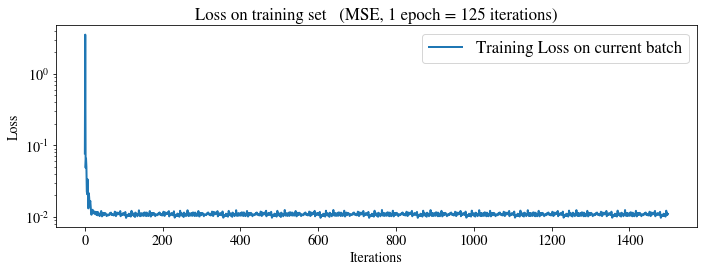

/var/folders/tn/nyh0947d6sngjfvtp7hbb0jr0000gn/T/ipykernel_5515/863207960.py:19: UserWarning: Glyph 9 (	) missing from current font.
  a=plt.savefig(path + '/valid_losses.png', dpi=150)
/Users/canrager/.pyenv/versions/3.9.11/envs/thenv/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


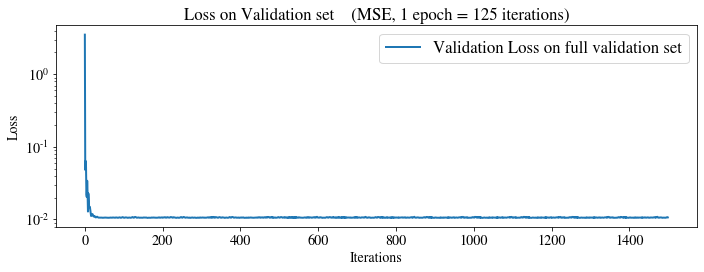

0.01072135300685962
./data/tomo0607_2qubit_random_uniform_vector/states10000_obs100/run_20220609_120759/ AE2Q_kleiner 10000.0 100 25 0.05 12
AutoencoderNet(
  (encoder): Sequential(
    (0): Linear(in_features=100, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=25, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=25, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=100, bias=True)
  )
)


100%|██████████| 12/12 [01:23<00:00,  6.98s/it]
/var/folders/tn/nyh0947d6sngjfvtp7hbb0jr0000gn/T/ipykernel_5515/863207960.py:9: UserWarning: Glyph 9 (	) missing from current font.
  a=plt.savefig(path + '/train_losses.png', dpi=150)


[0.07672949 0.16872127 0.02330288 ... 0.01132396 0.01077403 0.0109753 ]


/Users/canrager/.pyenv/versions/3.9.11/envs/thenv/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


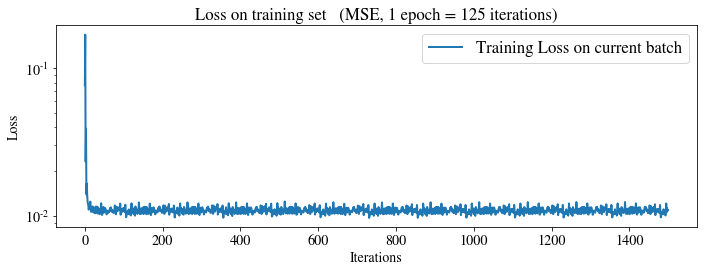

/var/folders/tn/nyh0947d6sngjfvtp7hbb0jr0000gn/T/ipykernel_5515/863207960.py:19: UserWarning: Glyph 9 (	) missing from current font.
  a=plt.savefig(path + '/valid_losses.png', dpi=150)
/Users/canrager/.pyenv/versions/3.9.11/envs/thenv/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


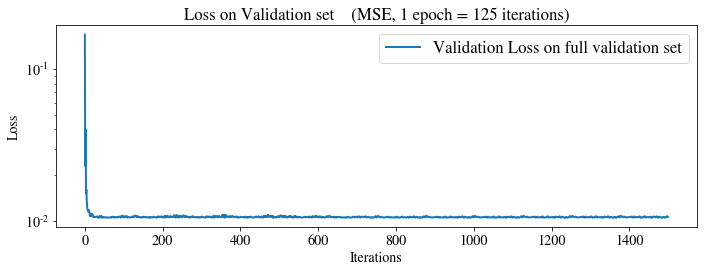

0.01068133239944776
./data/tomo0607_2qubit_random_uniform_vector/states10000_obs100/run_20220609_120759/ AE2Q_kleiner 10000.0 100 30 0.05 12
AutoencoderNet(
  (encoder): Sequential(
    (0): Linear(in_features=100, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=30, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=30, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=100, bias=True)
  )
)


100%|██████████| 12/12 [01:24<00:00,  7.06s/it]
/var/folders/tn/nyh0947d6sngjfvtp7hbb0jr0000gn/T/ipykernel_5515/863207960.py:9: UserWarning: Glyph 9 (	) missing from current font.
  a=plt.savefig(path + '/train_losses.png', dpi=150)


[0.08157168 0.08547516 0.02582383 ... 0.01131076 0.01042048 0.0106844 ]


/Users/canrager/.pyenv/versions/3.9.11/envs/thenv/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


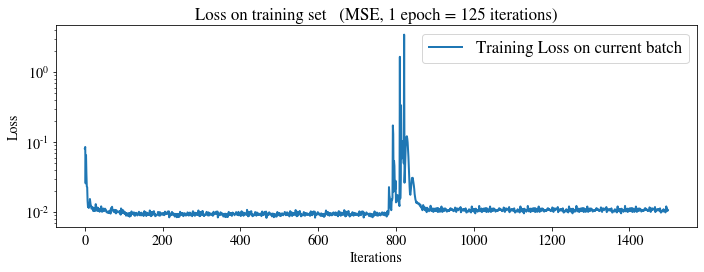

/var/folders/tn/nyh0947d6sngjfvtp7hbb0jr0000gn/T/ipykernel_5515/863207960.py:19: UserWarning: Glyph 9 (	) missing from current font.
  a=plt.savefig(path + '/valid_losses.png', dpi=150)
/Users/canrager/.pyenv/versions/3.9.11/envs/thenv/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


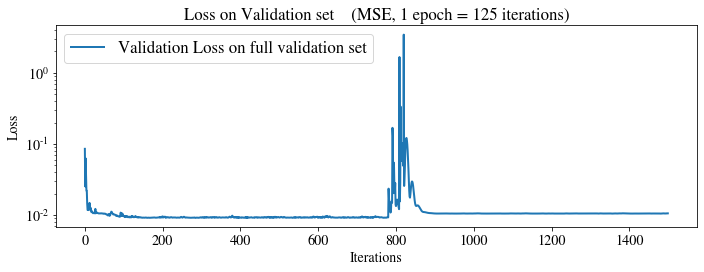

0.010619741057356198
./data/tomo0607_2qubit_random_uniform_vector/states10000_obs100/run_20220609_120814/ AE2Q_kleiner 10000.0 100 1 0.05 12
AutoencoderNet(
  (encoder): Sequential(
    (0): Linear(in_features=100, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=1, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=1, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=100, bias=True)
  )
)


100%|██████████| 12/12 [01:23<00:00,  7.00s/it]
/var/folders/tn/nyh0947d6sngjfvtp7hbb0jr0000gn/T/ipykernel_5515/863207960.py:9: UserWarning: Glyph 9 (	) missing from current font.
  a=plt.savefig(path + '/train_losses.png', dpi=150)


[0.08428832 0.21388127 0.02843301 ... 0.01147738 0.01071759 0.01112646]


/Users/canrager/.pyenv/versions/3.9.11/envs/thenv/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


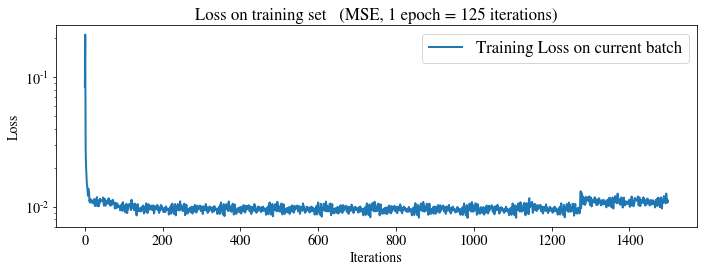

/var/folders/tn/nyh0947d6sngjfvtp7hbb0jr0000gn/T/ipykernel_5515/863207960.py:19: UserWarning: Glyph 9 (	) missing from current font.
  a=plt.savefig(path + '/valid_losses.png', dpi=150)
/Users/canrager/.pyenv/versions/3.9.11/envs/thenv/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


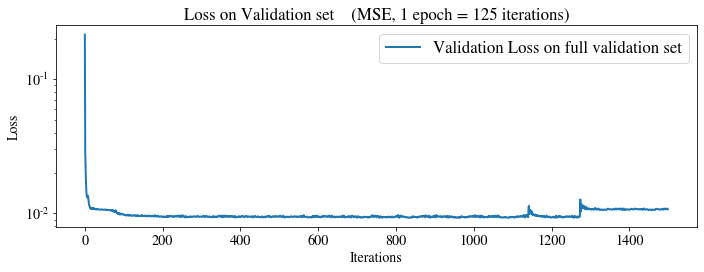

0.010803307654956977
./data/tomo0607_2qubit_random_uniform_vector/states10000_obs100/run_20220609_120814/ AE2Q_kleiner 10000.0 100 5 0.05 12
AutoencoderNet(
  (encoder): Sequential(
    (0): Linear(in_features=100, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=5, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=5, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=100, bias=True)
  )
)


100%|██████████| 12/12 [01:24<00:00,  7.08s/it]
/var/folders/tn/nyh0947d6sngjfvtp7hbb0jr0000gn/T/ipykernel_5515/863207960.py:9: UserWarning: Glyph 9 (	) missing from current font.
  a=plt.savefig(path + '/train_losses.png', dpi=150)


[0.0766954  0.49902183 0.02908218 ... 0.01146674 0.01070831 0.01111592]


/Users/canrager/.pyenv/versions/3.9.11/envs/thenv/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


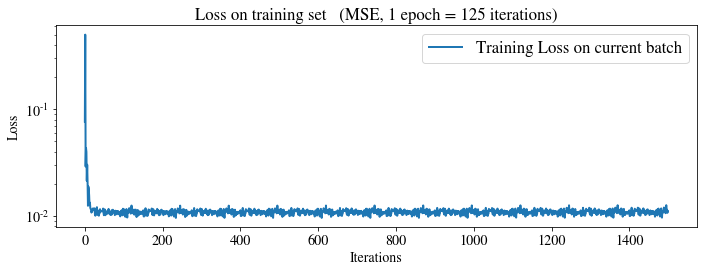

/var/folders/tn/nyh0947d6sngjfvtp7hbb0jr0000gn/T/ipykernel_5515/863207960.py:19: UserWarning: Glyph 9 (	) missing from current font.
  a=plt.savefig(path + '/valid_losses.png', dpi=150)
/Users/canrager/.pyenv/versions/3.9.11/envs/thenv/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


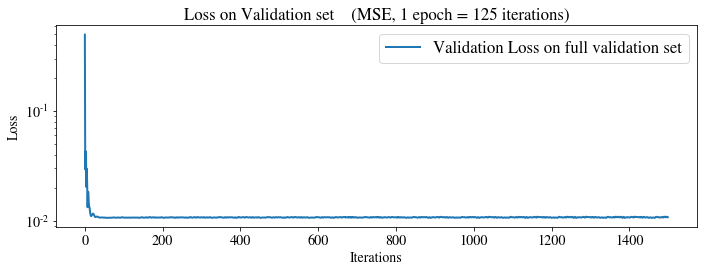

0.010813568035761516
./data/tomo0607_2qubit_random_uniform_vector/states10000_obs100/run_20220609_120814/ AE2Q_kleiner 10000.0 100 10 0.05 12
AutoencoderNet(
  (encoder): Sequential(
    (0): Linear(in_features=100, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=10, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=10, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=100, bias=True)
  )
)


100%|██████████| 12/12 [01:23<00:00,  6.97s/it]
/var/folders/tn/nyh0947d6sngjfvtp7hbb0jr0000gn/T/ipykernel_5515/863207960.py:9: UserWarning: Glyph 9 (	) missing from current font.
  a=plt.savefig(path + '/train_losses.png', dpi=150)


[0.08382555 0.66526133 0.04915524 ... 0.01145471 0.01069095 0.01109224]


/Users/canrager/.pyenv/versions/3.9.11/envs/thenv/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


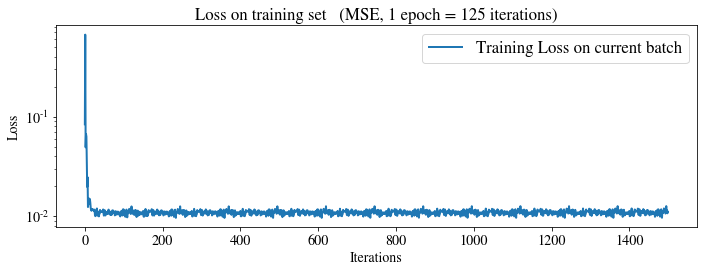

/var/folders/tn/nyh0947d6sngjfvtp7hbb0jr0000gn/T/ipykernel_5515/863207960.py:19: UserWarning: Glyph 9 (	) missing from current font.
  a=plt.savefig(path + '/valid_losses.png', dpi=150)
/Users/canrager/.pyenv/versions/3.9.11/envs/thenv/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


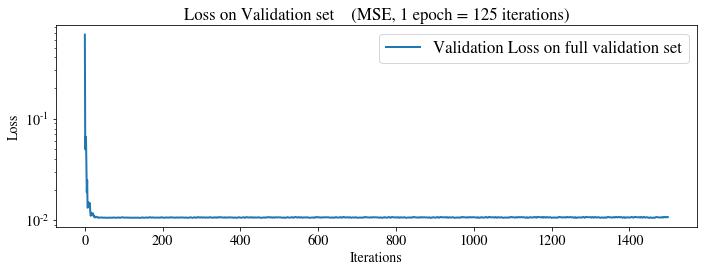

0.010819519683718682
./data/tomo0607_2qubit_random_uniform_vector/states10000_obs100/run_20220609_120814/ AE2Q_kleiner 10000.0 100 12 0.05 12
AutoencoderNet(
  (encoder): Sequential(
    (0): Linear(in_features=100, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=12, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=12, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=100, bias=True)
  )
)


100%|██████████| 12/12 [01:23<00:00,  6.99s/it]
/var/folders/tn/nyh0947d6sngjfvtp7hbb0jr0000gn/T/ipykernel_5515/863207960.py:9: UserWarning: Glyph 9 (	) missing from current font.
  a=plt.savefig(path + '/train_losses.png', dpi=150)


[0.08271487 0.21713331 0.03498454 ... 0.01149121 0.01072828 0.01113367]


/Users/canrager/.pyenv/versions/3.9.11/envs/thenv/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


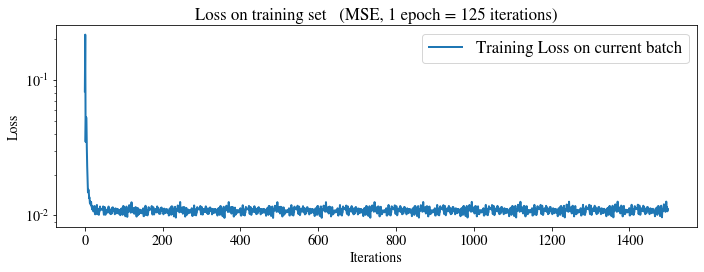

/var/folders/tn/nyh0947d6sngjfvtp7hbb0jr0000gn/T/ipykernel_5515/863207960.py:19: UserWarning: Glyph 9 (	) missing from current font.
  a=plt.savefig(path + '/valid_losses.png', dpi=150)
/Users/canrager/.pyenv/versions/3.9.11/envs/thenv/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


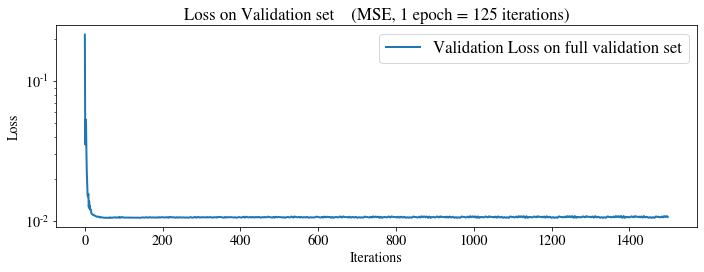

0.010813869473834833
./data/tomo0607_2qubit_random_uniform_vector/states10000_obs100/run_20220609_120814/ AE2Q_kleiner 10000.0 100 14 0.05 12
AutoencoderNet(
  (encoder): Sequential(
    (0): Linear(in_features=100, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=14, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=14, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=100, bias=True)
  )
)


100%|██████████| 12/12 [01:23<00:00,  6.93s/it]
/var/folders/tn/nyh0947d6sngjfvtp7hbb0jr0000gn/T/ipykernel_5515/863207960.py:9: UserWarning: Glyph 9 (	) missing from current font.
  a=plt.savefig(path + '/train_losses.png', dpi=150)


[0.08363094 0.38362399 0.03654993 ... 0.01146219 0.01071209 0.01111497]


/Users/canrager/.pyenv/versions/3.9.11/envs/thenv/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


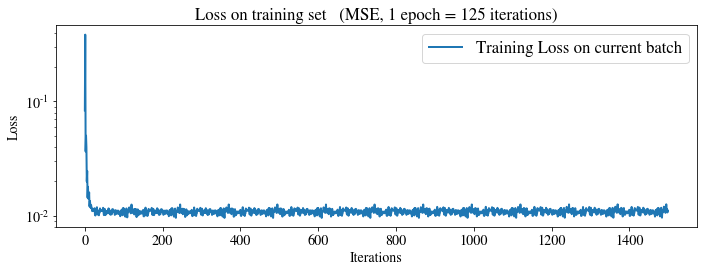

/var/folders/tn/nyh0947d6sngjfvtp7hbb0jr0000gn/T/ipykernel_5515/863207960.py:19: UserWarning: Glyph 9 (	) missing from current font.
  a=plt.savefig(path + '/valid_losses.png', dpi=150)
/Users/canrager/.pyenv/versions/3.9.11/envs/thenv/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


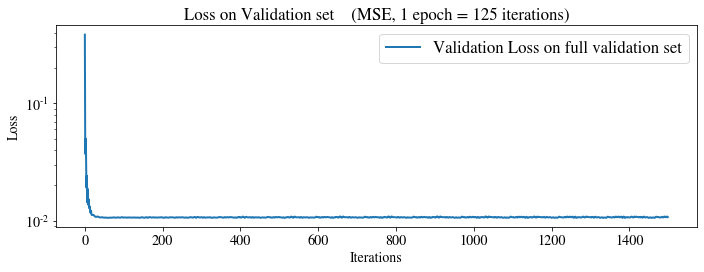

0.01081192127118508
./data/tomo0607_2qubit_random_uniform_vector/states10000_obs100/run_20220609_120814/ AE2Q_kleiner 10000.0 100 15 0.05 12
AutoencoderNet(
  (encoder): Sequential(
    (0): Linear(in_features=100, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=15, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=15, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=100, bias=True)
  )
)


100%|██████████| 12/12 [01:23<00:00,  6.94s/it]
/var/folders/tn/nyh0947d6sngjfvtp7hbb0jr0000gn/T/ipykernel_5515/863207960.py:9: UserWarning: Glyph 9 (	) missing from current font.
  a=plt.savefig(path + '/train_losses.png', dpi=150)


[0.08269805 0.04694288 0.02181348 ... 0.01149202 0.01073355 0.01113496]


/Users/canrager/.pyenv/versions/3.9.11/envs/thenv/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


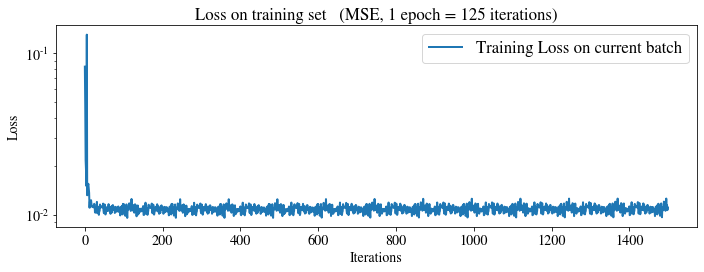

/var/folders/tn/nyh0947d6sngjfvtp7hbb0jr0000gn/T/ipykernel_5515/863207960.py:19: UserWarning: Glyph 9 (	) missing from current font.
  a=plt.savefig(path + '/valid_losses.png', dpi=150)
/Users/canrager/.pyenv/versions/3.9.11/envs/thenv/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


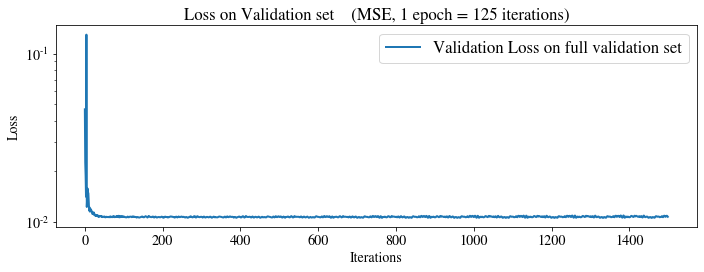

0.01081414936731259
./data/tomo0607_2qubit_random_uniform_vector/states10000_obs100/run_20220609_120814/ AE2Q_kleiner 10000.0 100 16 0.05 12
AutoencoderNet(
  (encoder): Sequential(
    (0): Linear(in_features=100, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=16, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=16, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=100, bias=True)
  )
)


100%|██████████| 12/12 [01:23<00:00,  6.95s/it]
/var/folders/tn/nyh0947d6sngjfvtp7hbb0jr0000gn/T/ipykernel_5515/863207960.py:9: UserWarning: Glyph 9 (	) missing from current font.
  a=plt.savefig(path + '/train_losses.png', dpi=150)


[0.08737051 0.1131505  0.03019671 ... 0.01149558 0.01072894 0.01113688]


/Users/canrager/.pyenv/versions/3.9.11/envs/thenv/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


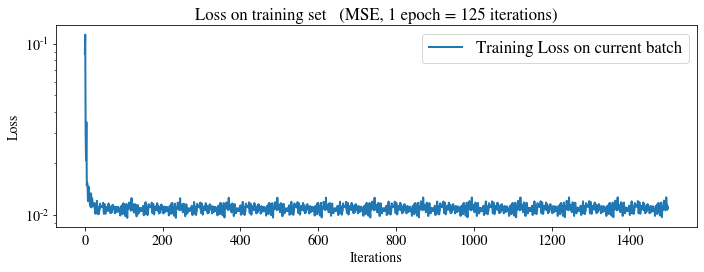

/var/folders/tn/nyh0947d6sngjfvtp7hbb0jr0000gn/T/ipykernel_5515/863207960.py:19: UserWarning: Glyph 9 (	) missing from current font.
  a=plt.savefig(path + '/valid_losses.png', dpi=150)
/Users/canrager/.pyenv/versions/3.9.11/envs/thenv/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


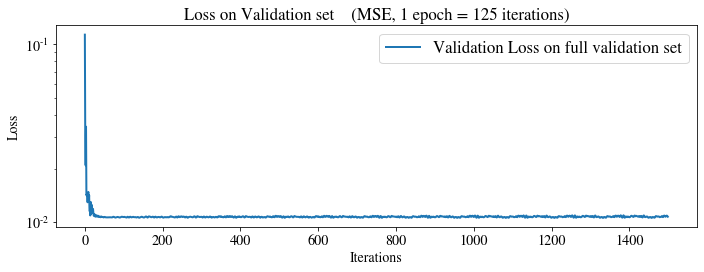

0.010814835006992022
./data/tomo0607_2qubit_random_uniform_vector/states10000_obs100/run_20220609_120814/ AE2Q_kleiner 10000.0 100 18 0.05 12
AutoencoderNet(
  (encoder): Sequential(
    (0): Linear(in_features=100, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=18, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=18, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=100, bias=True)
  )
)


100%|██████████| 12/12 [01:24<00:00,  7.00s/it]
/var/folders/tn/nyh0947d6sngjfvtp7hbb0jr0000gn/T/ipykernel_5515/863207960.py:9: UserWarning: Glyph 9 (	) missing from current font.
  a=plt.savefig(path + '/train_losses.png', dpi=150)


[0.07618763 0.26675814 0.02582586 ... 0.01147957 0.01072455 0.01113011]


/Users/canrager/.pyenv/versions/3.9.11/envs/thenv/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


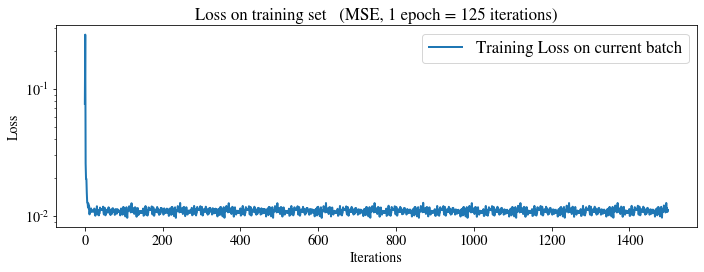

/var/folders/tn/nyh0947d6sngjfvtp7hbb0jr0000gn/T/ipykernel_5515/863207960.py:19: UserWarning: Glyph 9 (	) missing from current font.
  a=plt.savefig(path + '/valid_losses.png', dpi=150)
/Users/canrager/.pyenv/versions/3.9.11/envs/thenv/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


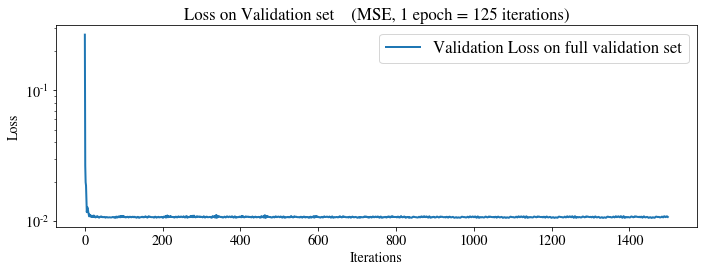

0.010817287117242813
./data/tomo0607_2qubit_random_uniform_vector/states10000_obs100/run_20220609_120814/ AE2Q_kleiner 10000.0 100 20 0.05 12
AutoencoderNet(
  (encoder): Sequential(
    (0): Linear(in_features=100, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=20, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=20, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=100, bias=True)
  )
)


100%|██████████| 12/12 [01:24<00:00,  7.04s/it]
/var/folders/tn/nyh0947d6sngjfvtp7hbb0jr0000gn/T/ipykernel_5515/863207960.py:9: UserWarning: Glyph 9 (	) missing from current font.
  a=plt.savefig(path + '/train_losses.png', dpi=150)


[0.0826349  0.7050209  0.04177862 ... 0.01039756 0.00913703 0.00949159]


/Users/canrager/.pyenv/versions/3.9.11/envs/thenv/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


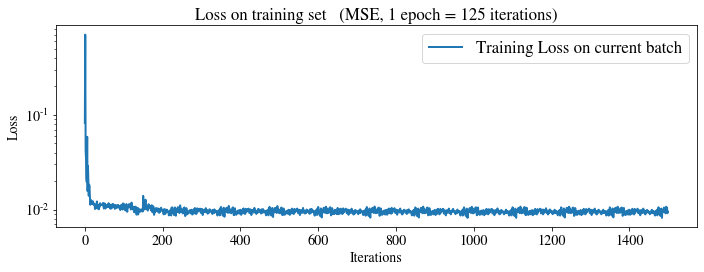

/var/folders/tn/nyh0947d6sngjfvtp7hbb0jr0000gn/T/ipykernel_5515/863207960.py:19: UserWarning: Glyph 9 (	) missing from current font.
  a=plt.savefig(path + '/valid_losses.png', dpi=150)
/Users/canrager/.pyenv/versions/3.9.11/envs/thenv/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


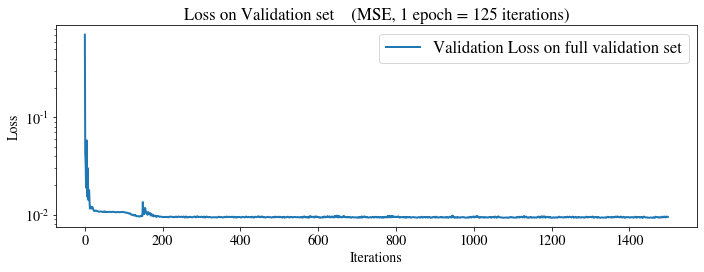

0.009596664272248746
./data/tomo0607_2qubit_random_uniform_vector/states10000_obs100/run_20220609_120814/ AE2Q_kleiner 10000.0 100 25 0.05 12
AutoencoderNet(
  (encoder): Sequential(
    (0): Linear(in_features=100, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=25, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=25, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=100, bias=True)
  )
)


100%|██████████| 12/12 [01:25<00:00,  7.16s/it]
/var/folders/tn/nyh0947d6sngjfvtp7hbb0jr0000gn/T/ipykernel_5515/863207960.py:9: UserWarning: Glyph 9 (	) missing from current font.
  a=plt.savefig(path + '/train_losses.png', dpi=150)


[0.08018051 0.2124508  0.03739545 ... 0.0114823  0.01072239 0.01112452]


/Users/canrager/.pyenv/versions/3.9.11/envs/thenv/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


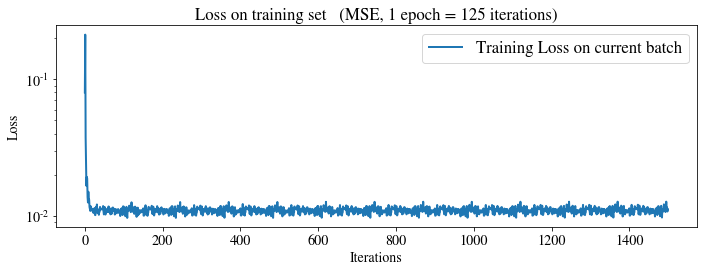

/var/folders/tn/nyh0947d6sngjfvtp7hbb0jr0000gn/T/ipykernel_5515/863207960.py:19: UserWarning: Glyph 9 (	) missing from current font.
  a=plt.savefig(path + '/valid_losses.png', dpi=150)
/Users/canrager/.pyenv/versions/3.9.11/envs/thenv/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


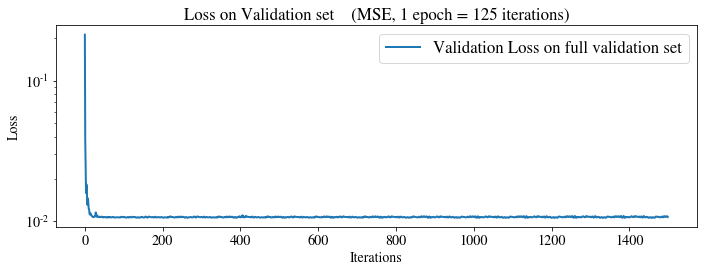

0.01082006823271513
./data/tomo0607_2qubit_random_uniform_vector/states10000_obs100/run_20220609_120814/ AE2Q_kleiner 10000.0 100 30 0.05 12
AutoencoderNet(
  (encoder): Sequential(
    (0): Linear(in_features=100, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=30, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=30, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=100, bias=True)
  )
)


100%|██████████| 12/12 [01:24<00:00,  7.01s/it]
/var/folders/tn/nyh0947d6sngjfvtp7hbb0jr0000gn/T/ipykernel_5515/863207960.py:9: UserWarning: Glyph 9 (	) missing from current font.
  a=plt.savefig(path + '/train_losses.png', dpi=150)


[0.08520344 0.06790484 0.02743273 ... 0.01150071 0.01072903 0.01114129]


/Users/canrager/.pyenv/versions/3.9.11/envs/thenv/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


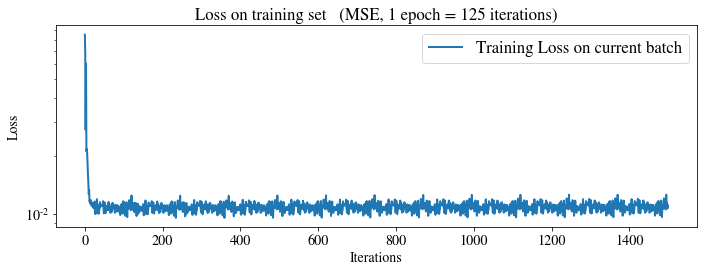

/var/folders/tn/nyh0947d6sngjfvtp7hbb0jr0000gn/T/ipykernel_5515/863207960.py:19: UserWarning: Glyph 9 (	) missing from current font.
  a=plt.savefig(path + '/valid_losses.png', dpi=150)
/Users/canrager/.pyenv/versions/3.9.11/envs/thenv/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


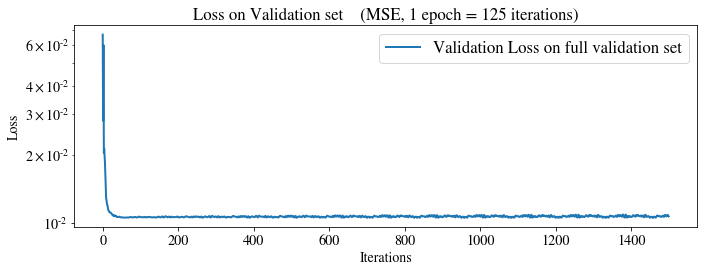

0.010813918523490429
./data/tomo0607_2qubit_random_uniform_vector/states10000_obs100/run_20220609_120824/ AE2Q_kleiner 10000.0 100 1 0.05 12
AutoencoderNet(
  (encoder): Sequential(
    (0): Linear(in_features=100, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=1, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=1, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=100, bias=True)
  )
)


100%|██████████| 12/12 [01:23<00:00,  6.98s/it]
/var/folders/tn/nyh0947d6sngjfvtp7hbb0jr0000gn/T/ipykernel_5515/863207960.py:9: UserWarning: Glyph 9 (	) missing from current font.
  a=plt.savefig(path + '/train_losses.png', dpi=150)


[0.08140571 0.52089489 0.02776344 ... 0.01051967 0.01185516 0.01126151]


/Users/canrager/.pyenv/versions/3.9.11/envs/thenv/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


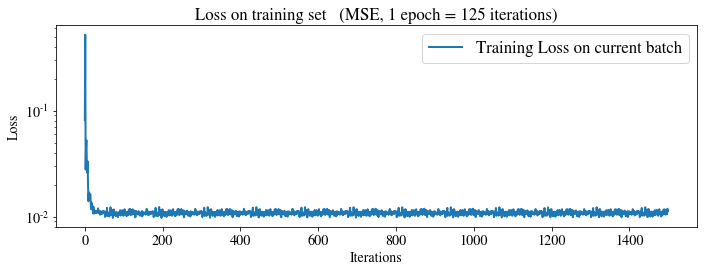

/var/folders/tn/nyh0947d6sngjfvtp7hbb0jr0000gn/T/ipykernel_5515/863207960.py:19: UserWarning: Glyph 9 (	) missing from current font.
  a=plt.savefig(path + '/valid_losses.png', dpi=150)
/Users/canrager/.pyenv/versions/3.9.11/envs/thenv/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


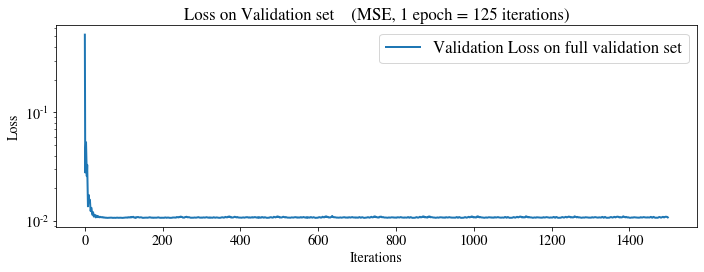

0.01080056584129731
./data/tomo0607_2qubit_random_uniform_vector/states10000_obs100/run_20220609_120824/ AE2Q_kleiner 10000.0 100 5 0.05 12
AutoencoderNet(
  (encoder): Sequential(
    (0): Linear(in_features=100, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=5, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=5, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=100, bias=True)
  )
)


100%|██████████| 12/12 [01:23<00:00,  6.98s/it]
/var/folders/tn/nyh0947d6sngjfvtp7hbb0jr0000gn/T/ipykernel_5515/863207960.py:9: UserWarning: Glyph 9 (	) missing from current font.
  a=plt.savefig(path + '/train_losses.png', dpi=150)


[0.09003042 0.06845387 0.03752027 ... 0.01059404 0.01193469 0.01121109]


/Users/canrager/.pyenv/versions/3.9.11/envs/thenv/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


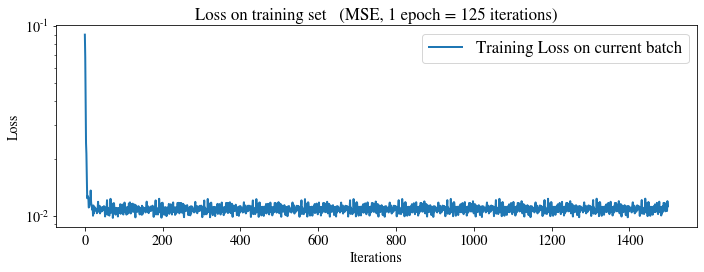

/var/folders/tn/nyh0947d6sngjfvtp7hbb0jr0000gn/T/ipykernel_5515/863207960.py:19: UserWarning: Glyph 9 (	) missing from current font.
  a=plt.savefig(path + '/valid_losses.png', dpi=150)
/Users/canrager/.pyenv/versions/3.9.11/envs/thenv/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


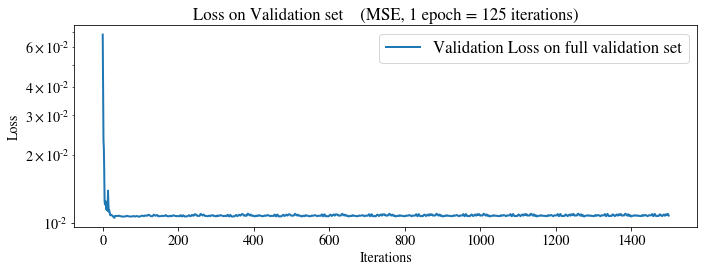

0.010789562823871772
./data/tomo0607_2qubit_random_uniform_vector/states10000_obs100/run_20220609_120824/ AE2Q_kleiner 10000.0 100 10 0.05 12
AutoencoderNet(
  (encoder): Sequential(
    (0): Linear(in_features=100, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=10, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=10, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=100, bias=True)
  )
)


100%|██████████| 12/12 [01:23<00:00,  6.97s/it]
/var/folders/tn/nyh0947d6sngjfvtp7hbb0jr0000gn/T/ipykernel_5515/863207960.py:9: UserWarning: Glyph 9 (	) missing from current font.
  a=plt.savefig(path + '/train_losses.png', dpi=150)


[0.08600715 0.17284039 0.04007791 ... 0.01055885 0.01191454 0.01122245]


/Users/canrager/.pyenv/versions/3.9.11/envs/thenv/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


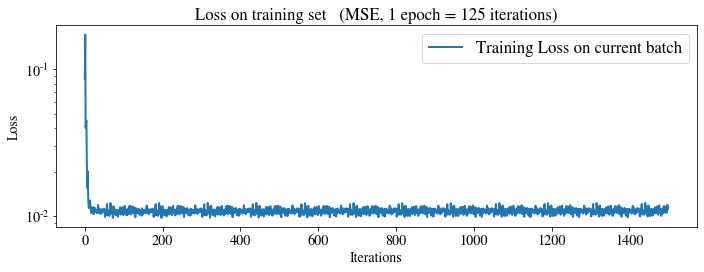

/var/folders/tn/nyh0947d6sngjfvtp7hbb0jr0000gn/T/ipykernel_5515/863207960.py:19: UserWarning: Glyph 9 (	) missing from current font.
  a=plt.savefig(path + '/valid_losses.png', dpi=150)
/Users/canrager/.pyenv/versions/3.9.11/envs/thenv/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


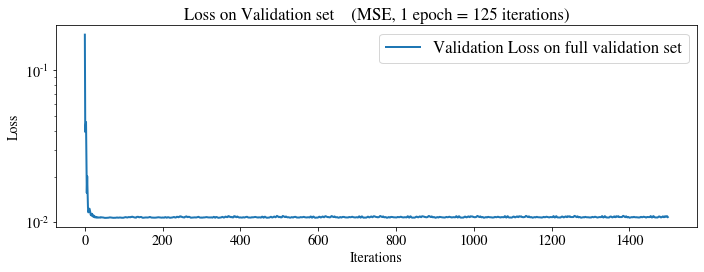

0.010798249393701553
./data/tomo0607_2qubit_random_uniform_vector/states10000_obs100/run_20220609_120824/ AE2Q_kleiner 10000.0 100 12 0.05 12
AutoencoderNet(
  (encoder): Sequential(
    (0): Linear(in_features=100, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=12, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=12, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=100, bias=True)
  )
)


100%|██████████| 12/12 [01:23<00:00,  6.99s/it]
/var/folders/tn/nyh0947d6sngjfvtp7hbb0jr0000gn/T/ipykernel_5515/863207960.py:9: UserWarning: Glyph 9 (	) missing from current font.
  a=plt.savefig(path + '/train_losses.png', dpi=150)


[0.08015712 1.67155397 0.05565272 ... 0.01052028 0.01171766 0.01126179]


/Users/canrager/.pyenv/versions/3.9.11/envs/thenv/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


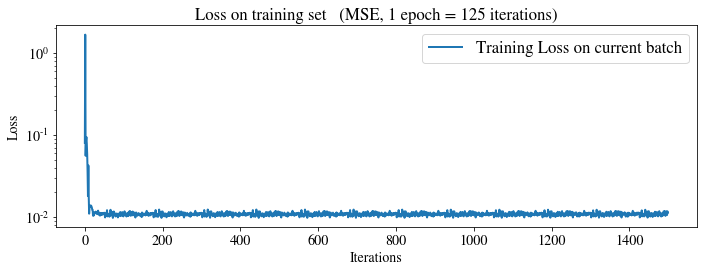

/var/folders/tn/nyh0947d6sngjfvtp7hbb0jr0000gn/T/ipykernel_5515/863207960.py:19: UserWarning: Glyph 9 (	) missing from current font.
  a=plt.savefig(path + '/valid_losses.png', dpi=150)
/Users/canrager/.pyenv/versions/3.9.11/envs/thenv/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


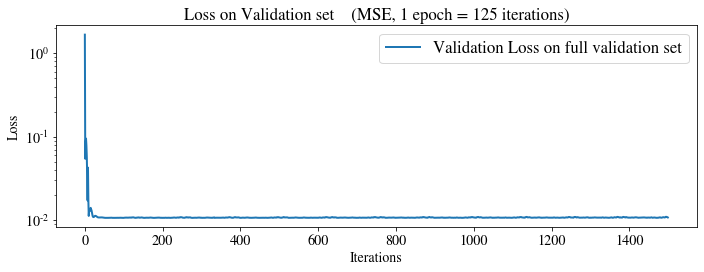

0.010814649115006129
./data/tomo0607_2qubit_random_uniform_vector/states10000_obs100/run_20220609_120824/ AE2Q_kleiner 10000.0 100 14 0.05 12
AutoencoderNet(
  (encoder): Sequential(
    (0): Linear(in_features=100, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=14, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=14, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=100, bias=True)
  )
)


100%|██████████| 12/12 [01:23<00:00,  6.99s/it]
/var/folders/tn/nyh0947d6sngjfvtp7hbb0jr0000gn/T/ipykernel_5515/863207960.py:9: UserWarning: Glyph 9 (	) missing from current font.
  a=plt.savefig(path + '/train_losses.png', dpi=150)


[0.08010206 0.62745976 0.04097535 ... 0.00943908 0.0100024  0.01015119]


/Users/canrager/.pyenv/versions/3.9.11/envs/thenv/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


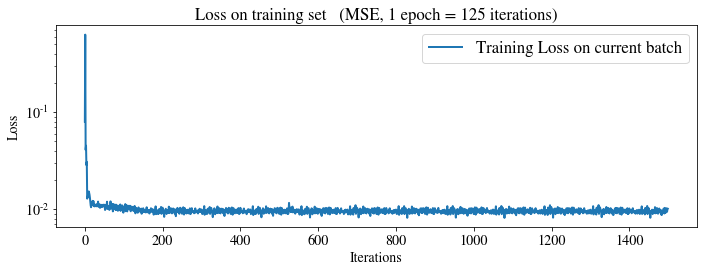

/var/folders/tn/nyh0947d6sngjfvtp7hbb0jr0000gn/T/ipykernel_5515/863207960.py:19: UserWarning: Glyph 9 (	) missing from current font.
  a=plt.savefig(path + '/valid_losses.png', dpi=150)
/Users/canrager/.pyenv/versions/3.9.11/envs/thenv/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


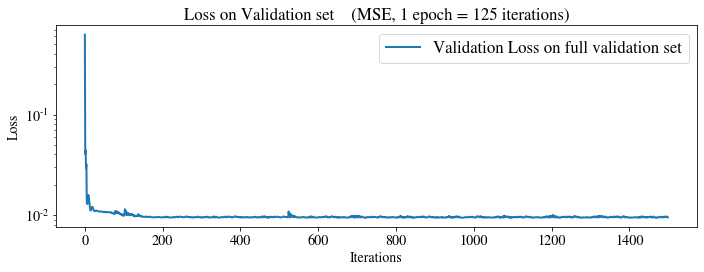

0.009547535454233487
./data/tomo0607_2qubit_random_uniform_vector/states10000_obs100/run_20220609_120824/ AE2Q_kleiner 10000.0 100 15 0.05 12
AutoencoderNet(
  (encoder): Sequential(
    (0): Linear(in_features=100, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=15, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=15, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=100, bias=True)
  )
)


100%|██████████| 12/12 [01:23<00:00,  6.99s/it]
/var/folders/tn/nyh0947d6sngjfvtp7hbb0jr0000gn/T/ipykernel_5515/863207960.py:9: UserWarning: Glyph 9 (	) missing from current font.
  a=plt.savefig(path + '/train_losses.png', dpi=150)


[0.07911496 0.06309412 0.02033194 ... 0.01059492 0.01193102 0.01120621]


/Users/canrager/.pyenv/versions/3.9.11/envs/thenv/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


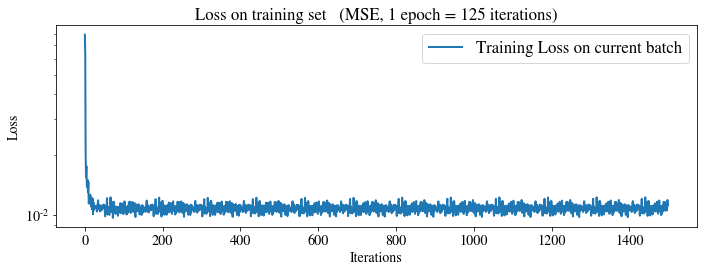

/var/folders/tn/nyh0947d6sngjfvtp7hbb0jr0000gn/T/ipykernel_5515/863207960.py:19: UserWarning: Glyph 9 (	) missing from current font.
  a=plt.savefig(path + '/valid_losses.png', dpi=150)
/Users/canrager/.pyenv/versions/3.9.11/envs/thenv/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


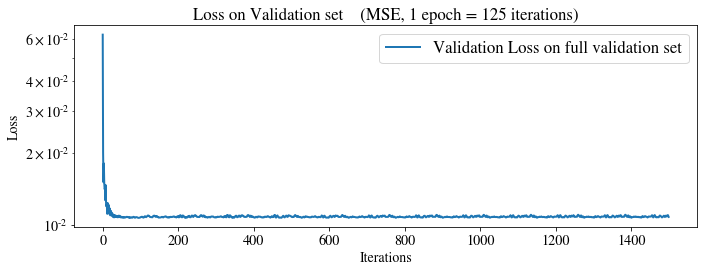

0.010789326205849648
./data/tomo0607_2qubit_random_uniform_vector/states10000_obs100/run_20220609_120824/ AE2Q_kleiner 10000.0 100 16 0.05 12
AutoencoderNet(
  (encoder): Sequential(
    (0): Linear(in_features=100, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=16, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=16, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=100, bias=True)
  )
)


100%|██████████| 12/12 [01:23<00:00,  6.97s/it]
/var/folders/tn/nyh0947d6sngjfvtp7hbb0jr0000gn/T/ipykernel_5515/863207960.py:9: UserWarning: Glyph 9 (	) missing from current font.
  a=plt.savefig(path + '/train_losses.png', dpi=150)


[0.0808882  0.09146509 0.04219041 ... 0.01058027 0.01193244 0.01121788]


/Users/canrager/.pyenv/versions/3.9.11/envs/thenv/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


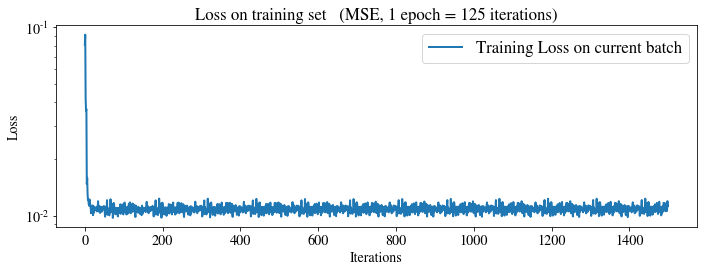

/var/folders/tn/nyh0947d6sngjfvtp7hbb0jr0000gn/T/ipykernel_5515/863207960.py:19: UserWarning: Glyph 9 (	) missing from current font.
  a=plt.savefig(path + '/valid_losses.png', dpi=150)
/Users/canrager/.pyenv/versions/3.9.11/envs/thenv/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


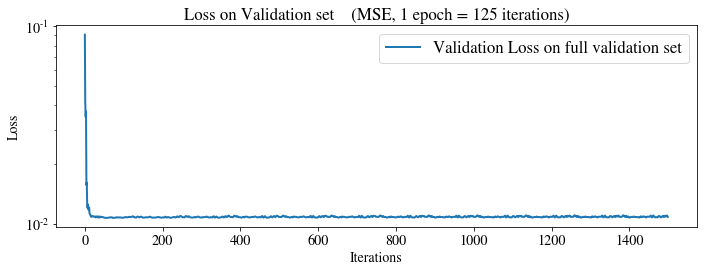

0.010794006598492464
./data/tomo0607_2qubit_random_uniform_vector/states10000_obs100/run_20220609_120824/ AE2Q_kleiner 10000.0 100 18 0.05 12
AutoencoderNet(
  (encoder): Sequential(
    (0): Linear(in_features=100, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=18, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=18, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=100, bias=True)
  )
)


100%|██████████| 12/12 [01:23<00:00,  6.97s/it]
/var/folders/tn/nyh0947d6sngjfvtp7hbb0jr0000gn/T/ipykernel_5515/863207960.py:9: UserWarning: Glyph 9 (	) missing from current font.
  a=plt.savefig(path + '/train_losses.png', dpi=150)


[0.08180086 0.14940563 0.02527741 ... 0.01056161 0.01192414 0.01121378]


/Users/canrager/.pyenv/versions/3.9.11/envs/thenv/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


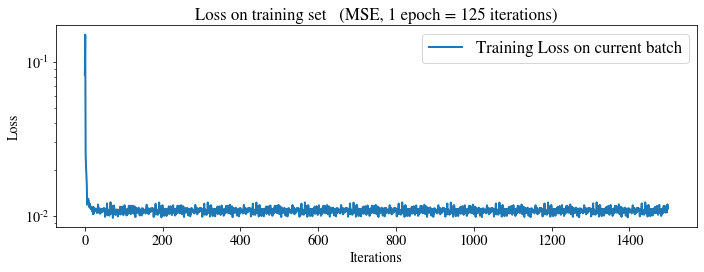

/var/folders/tn/nyh0947d6sngjfvtp7hbb0jr0000gn/T/ipykernel_5515/863207960.py:19: UserWarning: Glyph 9 (	) missing from current font.
  a=plt.savefig(path + '/valid_losses.png', dpi=150)
/Users/canrager/.pyenv/versions/3.9.11/envs/thenv/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


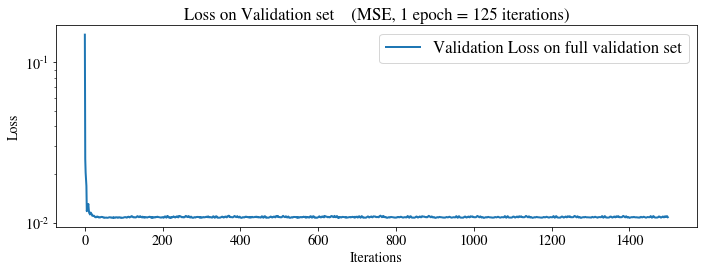

0.010794584639370441
./data/tomo0607_2qubit_random_uniform_vector/states10000_obs100/run_20220609_120824/ AE2Q_kleiner 10000.0 100 20 0.05 12
AutoencoderNet(
  (encoder): Sequential(
    (0): Linear(in_features=100, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=20, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=20, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=100, bias=True)
  )
)


100%|██████████| 12/12 [01:23<00:00,  6.99s/it]
/var/folders/tn/nyh0947d6sngjfvtp7hbb0jr0000gn/T/ipykernel_5515/863207960.py:9: UserWarning: Glyph 9 (	) missing from current font.
  a=plt.savefig(path + '/train_losses.png', dpi=150)


[0.08210799 0.04482397 0.01603213 ... 0.01060693 0.01193143 0.01120571]


/Users/canrager/.pyenv/versions/3.9.11/envs/thenv/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


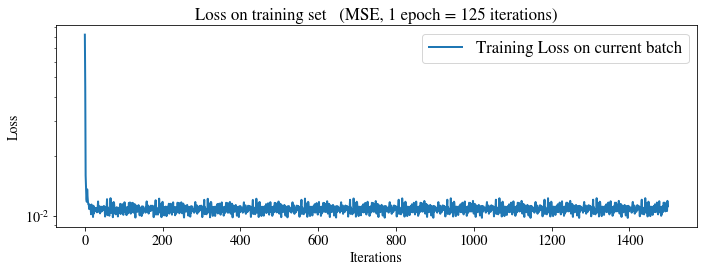

/var/folders/tn/nyh0947d6sngjfvtp7hbb0jr0000gn/T/ipykernel_5515/863207960.py:19: UserWarning: Glyph 9 (	) missing from current font.
  a=plt.savefig(path + '/valid_losses.png', dpi=150)
/Users/canrager/.pyenv/versions/3.9.11/envs/thenv/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


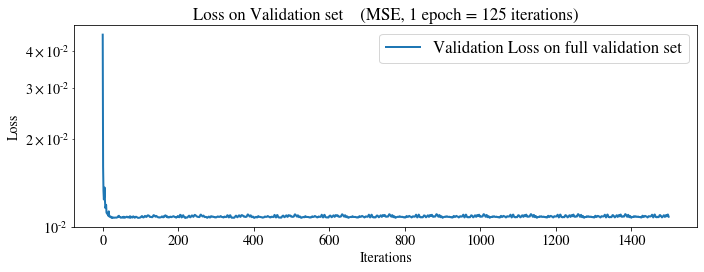

0.010791589505970478
./data/tomo0607_2qubit_random_uniform_vector/states10000_obs100/run_20220609_120824/ AE2Q_kleiner 10000.0 100 25 0.05 12
AutoencoderNet(
  (encoder): Sequential(
    (0): Linear(in_features=100, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=25, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=25, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=100, bias=True)
  )
)


100%|██████████| 12/12 [01:23<00:00,  6.98s/it]


[0.08113997 0.19319241 0.03242897 ... 0.01039619 0.01155627 0.01114084]


/var/folders/tn/nyh0947d6sngjfvtp7hbb0jr0000gn/T/ipykernel_5515/863207960.py:9: UserWarning: Glyph 9 (	) missing from current font.
  a=plt.savefig(path + '/train_losses.png', dpi=150)
/Users/canrager/.pyenv/versions/3.9.11/envs/thenv/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


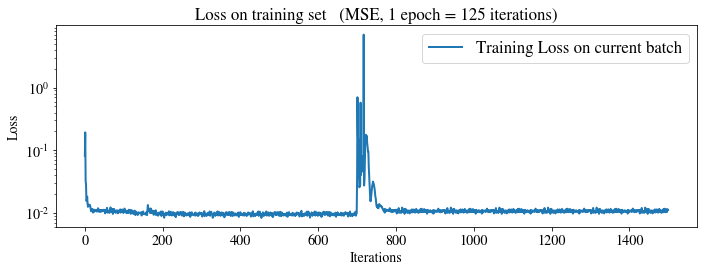

/var/folders/tn/nyh0947d6sngjfvtp7hbb0jr0000gn/T/ipykernel_5515/863207960.py:19: UserWarning: Glyph 9 (	) missing from current font.
  a=plt.savefig(path + '/valid_losses.png', dpi=150)
/Users/canrager/.pyenv/versions/3.9.11/envs/thenv/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


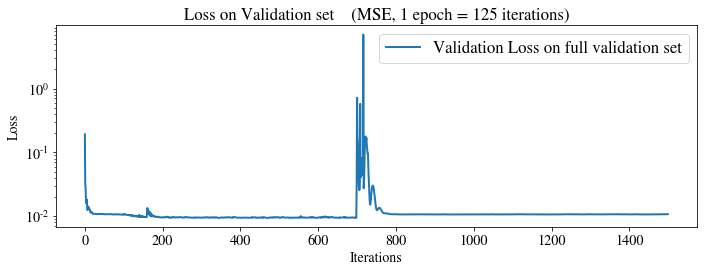

0.01080659106373787
./data/tomo0607_2qubit_random_uniform_vector/states10000_obs100/run_20220609_120824/ AE2Q_kleiner 10000.0 100 30 0.05 12
AutoencoderNet(
  (encoder): Sequential(
    (0): Linear(in_features=100, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=30, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=30, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=100, bias=True)
  )
)


100%|██████████| 12/12 [01:23<00:00,  6.93s/it]
/var/folders/tn/nyh0947d6sngjfvtp7hbb0jr0000gn/T/ipykernel_5515/863207960.py:9: UserWarning: Glyph 9 (	) missing from current font.
  a=plt.savefig(path + '/train_losses.png', dpi=150)


[0.08788124 0.05624053 0.02512502 ... 0.01059501 0.01192831 0.01120722]


/Users/canrager/.pyenv/versions/3.9.11/envs/thenv/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


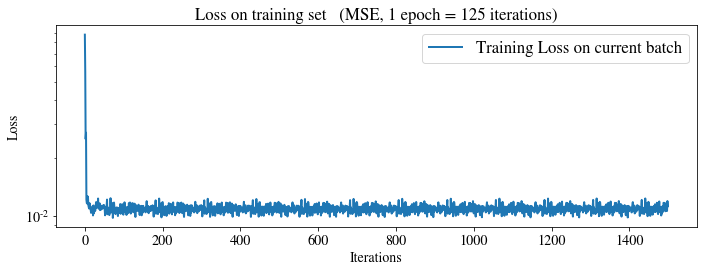

/var/folders/tn/nyh0947d6sngjfvtp7hbb0jr0000gn/T/ipykernel_5515/863207960.py:19: UserWarning: Glyph 9 (	) missing from current font.
  a=plt.savefig(path + '/valid_losses.png', dpi=150)
/Users/canrager/.pyenv/versions/3.9.11/envs/thenv/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


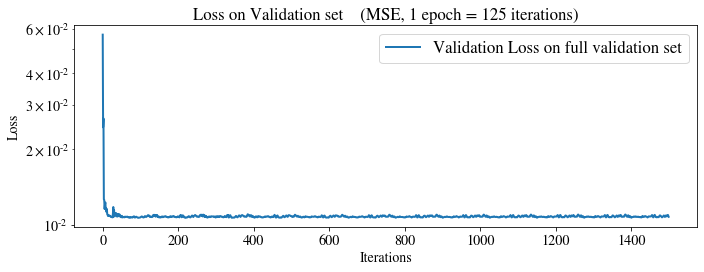

0.010790236170093219
./data/tomo0607_2qubit_random_uniform_vector/states10000_obs100/run_20220609_120809/ AE2Q_kleiner 10000.0 100 1 0.05 12
AutoencoderNet(
  (encoder): Sequential(
    (0): Linear(in_features=100, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=1, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=1, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=100, bias=True)
  )
)


100%|██████████| 12/12 [01:23<00:00,  6.95s/it]
/var/folders/tn/nyh0947d6sngjfvtp7hbb0jr0000gn/T/ipykernel_5515/863207960.py:9: UserWarning: Glyph 9 (	) missing from current font.
  a=plt.savefig(path + '/train_losses.png', dpi=150)


[0.08030777 0.3045451  0.0249789  ... 0.00907832 0.0092132  0.00973907]


/Users/canrager/.pyenv/versions/3.9.11/envs/thenv/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


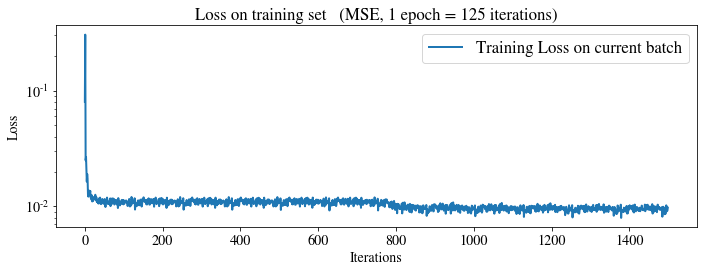

/var/folders/tn/nyh0947d6sngjfvtp7hbb0jr0000gn/T/ipykernel_5515/863207960.py:19: UserWarning: Glyph 9 (	) missing from current font.
  a=plt.savefig(path + '/valid_losses.png', dpi=150)
/Users/canrager/.pyenv/versions/3.9.11/envs/thenv/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


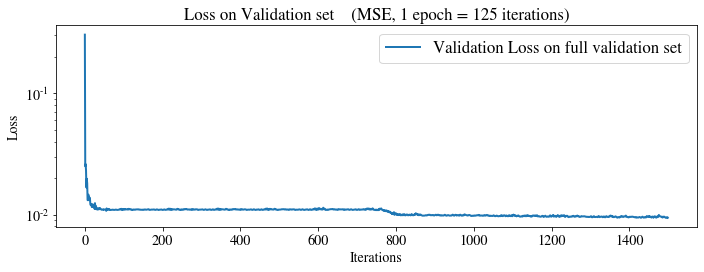

0.00913939525683721
./data/tomo0607_2qubit_random_uniform_vector/states10000_obs100/run_20220609_120809/ AE2Q_kleiner 10000.0 100 5 0.05 12
AutoencoderNet(
  (encoder): Sequential(
    (0): Linear(in_features=100, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=5, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=5, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=100, bias=True)
  )
)


100%|██████████| 12/12 [01:23<00:00,  6.98s/it]
/var/folders/tn/nyh0947d6sngjfvtp7hbb0jr0000gn/T/ipykernel_5515/863207960.py:9: UserWarning: Glyph 9 (	) missing from current font.
  a=plt.savefig(path + '/train_losses.png', dpi=150)


[0.07733198 0.15501781 0.0323078  ... 0.00922108 0.00928716 0.00978057]


/Users/canrager/.pyenv/versions/3.9.11/envs/thenv/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


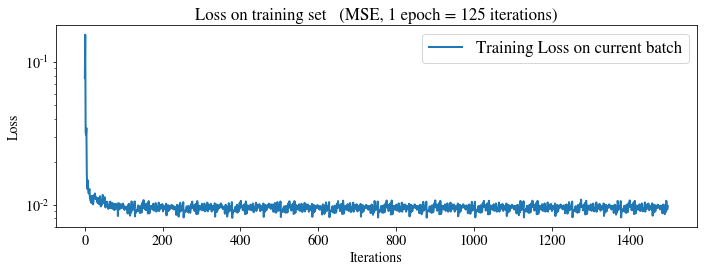

/var/folders/tn/nyh0947d6sngjfvtp7hbb0jr0000gn/T/ipykernel_5515/863207960.py:19: UserWarning: Glyph 9 (	) missing from current font.
  a=plt.savefig(path + '/valid_losses.png', dpi=150)
/Users/canrager/.pyenv/versions/3.9.11/envs/thenv/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


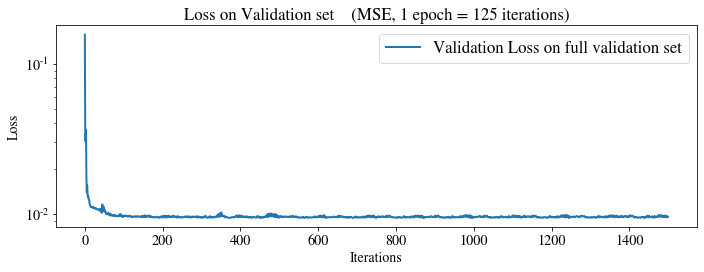

0.009253936757644018
./data/tomo0607_2qubit_random_uniform_vector/states10000_obs100/run_20220609_120809/ AE2Q_kleiner 10000.0 100 10 0.05 12
AutoencoderNet(
  (encoder): Sequential(
    (0): Linear(in_features=100, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=10, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=10, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=100, bias=True)
  )
)


100%|██████████| 12/12 [01:23<00:00,  6.98s/it]
/var/folders/tn/nyh0947d6sngjfvtp7hbb0jr0000gn/T/ipykernel_5515/863207960.py:9: UserWarning: Glyph 9 (	) missing from current font.
  a=plt.savefig(path + '/train_losses.png', dpi=150)


[0.08402362 0.04987857 0.0276301  ... 0.01072901 0.01079153 0.01105193]


/Users/canrager/.pyenv/versions/3.9.11/envs/thenv/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


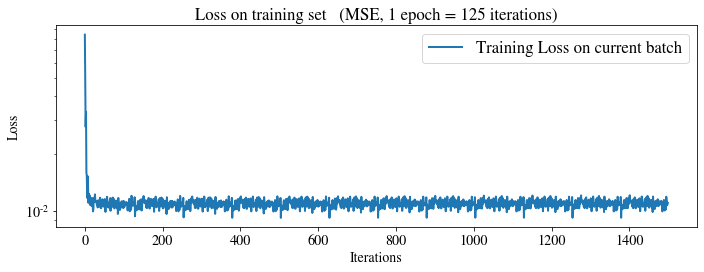

/var/folders/tn/nyh0947d6sngjfvtp7hbb0jr0000gn/T/ipykernel_5515/863207960.py:19: UserWarning: Glyph 9 (	) missing from current font.
  a=plt.savefig(path + '/valid_losses.png', dpi=150)
/Users/canrager/.pyenv/versions/3.9.11/envs/thenv/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


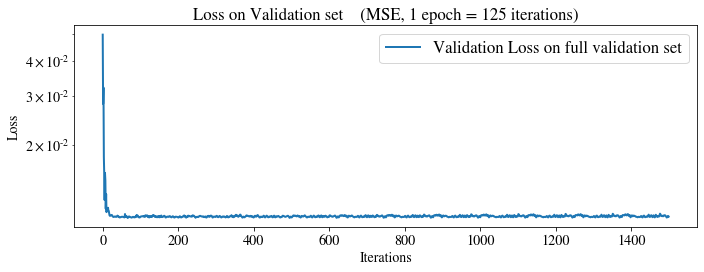

0.010520269038776557
./data/tomo0607_2qubit_random_uniform_vector/states10000_obs100/run_20220609_120809/ AE2Q_kleiner 10000.0 100 12 0.05 12
AutoencoderNet(
  (encoder): Sequential(
    (0): Linear(in_features=100, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=12, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=12, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=100, bias=True)
  )
)


100%|██████████| 12/12 [01:23<00:00,  6.97s/it]
/var/folders/tn/nyh0947d6sngjfvtp7hbb0jr0000gn/T/ipykernel_5515/863207960.py:9: UserWarning: Glyph 9 (	) missing from current font.
  a=plt.savefig(path + '/train_losses.png', dpi=150)


[0.07941445 0.047854   0.02088445 ... 0.01071888 0.01078598 0.01103884]


/Users/canrager/.pyenv/versions/3.9.11/envs/thenv/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


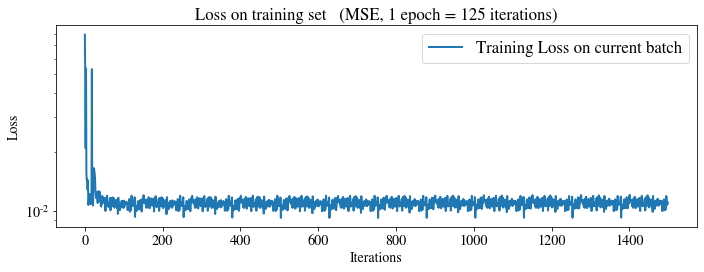

/var/folders/tn/nyh0947d6sngjfvtp7hbb0jr0000gn/T/ipykernel_5515/863207960.py:19: UserWarning: Glyph 9 (	) missing from current font.
  a=plt.savefig(path + '/valid_losses.png', dpi=150)
/Users/canrager/.pyenv/versions/3.9.11/envs/thenv/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


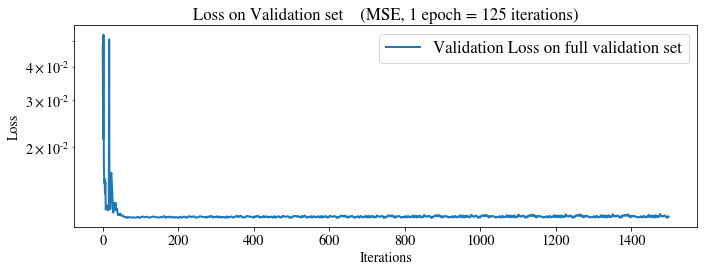

0.010515643159548442
./data/tomo0607_2qubit_random_uniform_vector/states10000_obs100/run_20220609_120809/ AE2Q_kleiner 10000.0 100 14 0.05 12
AutoencoderNet(
  (encoder): Sequential(
    (0): Linear(in_features=100, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=14, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=14, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=100, bias=True)
  )
)


100%|██████████| 12/12 [01:23<00:00,  6.97s/it]
/var/folders/tn/nyh0947d6sngjfvtp7hbb0jr0000gn/T/ipykernel_5515/863207960.py:9: UserWarning: Glyph 9 (	) missing from current font.
  a=plt.savefig(path + '/train_losses.png', dpi=150)


[0.08208641 0.02178607 0.02061714 ... 0.01060091 0.01072543 0.01094762]


/Users/canrager/.pyenv/versions/3.9.11/envs/thenv/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


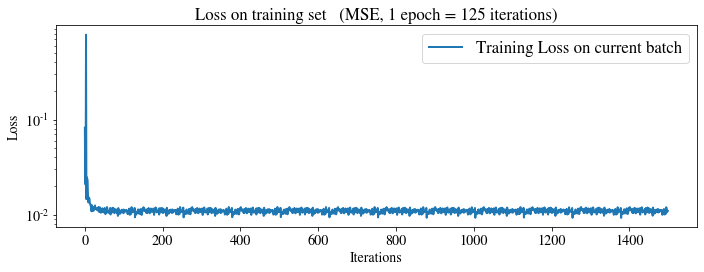

/var/folders/tn/nyh0947d6sngjfvtp7hbb0jr0000gn/T/ipykernel_5515/863207960.py:19: UserWarning: Glyph 9 (	) missing from current font.
  a=plt.savefig(path + '/valid_losses.png', dpi=150)
/Users/canrager/.pyenv/versions/3.9.11/envs/thenv/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


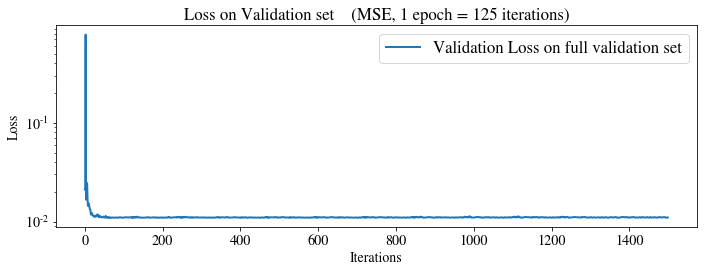

0.010508956139286358
./data/tomo0607_2qubit_random_uniform_vector/states10000_obs100/run_20220609_120809/ AE2Q_kleiner 10000.0 100 15 0.05 12
AutoencoderNet(
  (encoder): Sequential(
    (0): Linear(in_features=100, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=15, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=15, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=100, bias=True)
  )
)


100%|██████████| 12/12 [01:24<00:00,  7.03s/it]
/var/folders/tn/nyh0947d6sngjfvtp7hbb0jr0000gn/T/ipykernel_5515/863207960.py:9: UserWarning: Glyph 9 (	) missing from current font.
  a=plt.savefig(path + '/train_losses.png', dpi=150)


[0.07262054 0.05177487 0.029712   ... 0.0107313  0.01079602 0.01105665]


/Users/canrager/.pyenv/versions/3.9.11/envs/thenv/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


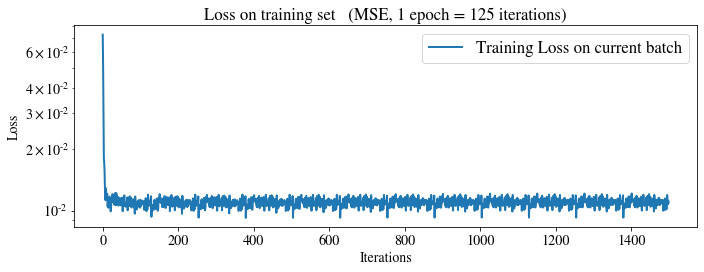

/var/folders/tn/nyh0947d6sngjfvtp7hbb0jr0000gn/T/ipykernel_5515/863207960.py:19: UserWarning: Glyph 9 (	) missing from current font.
  a=plt.savefig(path + '/valid_losses.png', dpi=150)
/Users/canrager/.pyenv/versions/3.9.11/envs/thenv/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


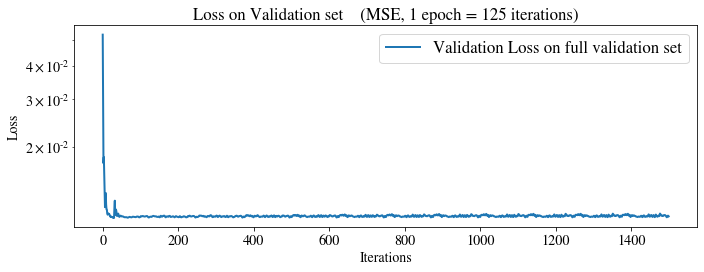

0.010522457336386045
./data/tomo0607_2qubit_random_uniform_vector/states10000_obs100/run_20220609_120809/ AE2Q_kleiner 10000.0 100 16 0.05 12
AutoencoderNet(
  (encoder): Sequential(
    (0): Linear(in_features=100, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=16, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=16, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=100, bias=True)
  )
)


100%|██████████| 12/12 [01:23<00:00,  6.99s/it]
/var/folders/tn/nyh0947d6sngjfvtp7hbb0jr0000gn/T/ipykernel_5515/863207960.py:9: UserWarning: Glyph 9 (	) missing from current font.
  a=plt.savefig(path + '/train_losses.png', dpi=150)


[0.07895762 1.00235915 0.05616741 ... 0.01059316 0.01069158 0.01090909]


/Users/canrager/.pyenv/versions/3.9.11/envs/thenv/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


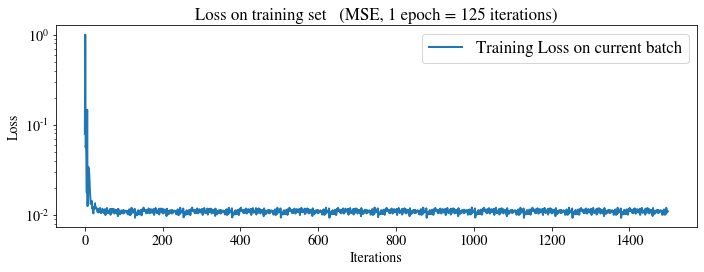

/var/folders/tn/nyh0947d6sngjfvtp7hbb0jr0000gn/T/ipykernel_5515/863207960.py:19: UserWarning: Glyph 9 (	) missing from current font.
  a=plt.savefig(path + '/valid_losses.png', dpi=150)
/Users/canrager/.pyenv/versions/3.9.11/envs/thenv/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


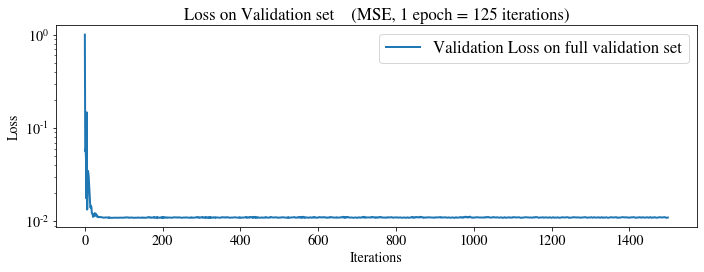

0.01049056202173233
./data/tomo0607_2qubit_random_uniform_vector/states10000_obs100/run_20220609_120809/ AE2Q_kleiner 10000.0 100 18 0.05 12
AutoencoderNet(
  (encoder): Sequential(
    (0): Linear(in_features=100, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=18, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=18, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=100, bias=True)
  )
)


100%|██████████| 12/12 [01:23<00:00,  6.98s/it]
/var/folders/tn/nyh0947d6sngjfvtp7hbb0jr0000gn/T/ipykernel_5515/863207960.py:9: UserWarning: Glyph 9 (	) missing from current font.
  a=plt.savefig(path + '/train_losses.png', dpi=150)


[0.08041669 0.5471974  0.05491836 ... 0.01063001 0.01072353 0.01096046]


/Users/canrager/.pyenv/versions/3.9.11/envs/thenv/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


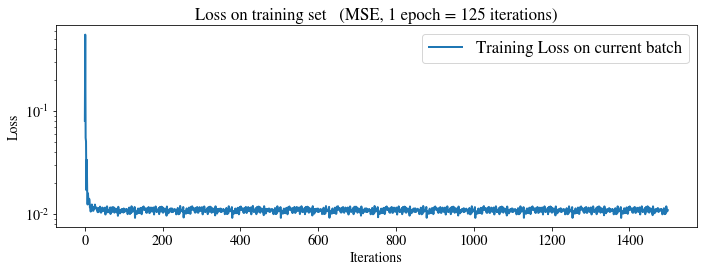

/var/folders/tn/nyh0947d6sngjfvtp7hbb0jr0000gn/T/ipykernel_5515/863207960.py:19: UserWarning: Glyph 9 (	) missing from current font.
  a=plt.savefig(path + '/valid_losses.png', dpi=150)
/Users/canrager/.pyenv/versions/3.9.11/envs/thenv/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


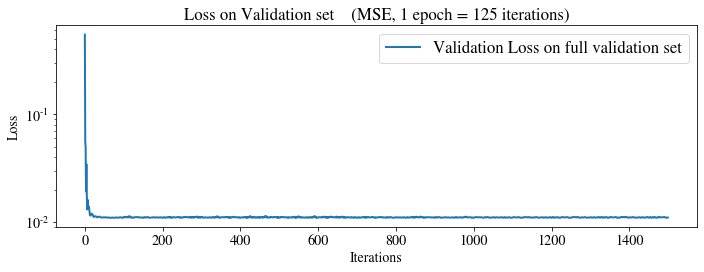

0.010511367085079352
./data/tomo0607_2qubit_random_uniform_vector/states10000_obs100/run_20220609_120809/ AE2Q_kleiner 10000.0 100 20 0.05 12
AutoencoderNet(
  (encoder): Sequential(
    (0): Linear(in_features=100, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=20, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=20, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=100, bias=True)
  )
)


100%|██████████| 12/12 [01:24<00:00,  7.01s/it]
/var/folders/tn/nyh0947d6sngjfvtp7hbb0jr0000gn/T/ipykernel_5515/863207960.py:9: UserWarning: Glyph 9 (	) missing from current font.
  a=plt.savefig(path + '/train_losses.png', dpi=150)


[0.08585149 0.92124748 0.04274445 ... 0.01071923 0.01080723 0.01095055]


/Users/canrager/.pyenv/versions/3.9.11/envs/thenv/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


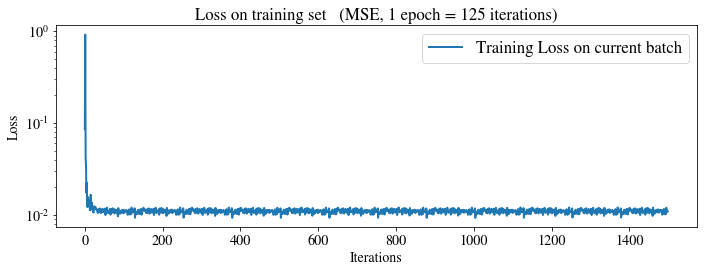

/var/folders/tn/nyh0947d6sngjfvtp7hbb0jr0000gn/T/ipykernel_5515/863207960.py:19: UserWarning: Glyph 9 (	) missing from current font.
  a=plt.savefig(path + '/valid_losses.png', dpi=150)
/Users/canrager/.pyenv/versions/3.9.11/envs/thenv/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


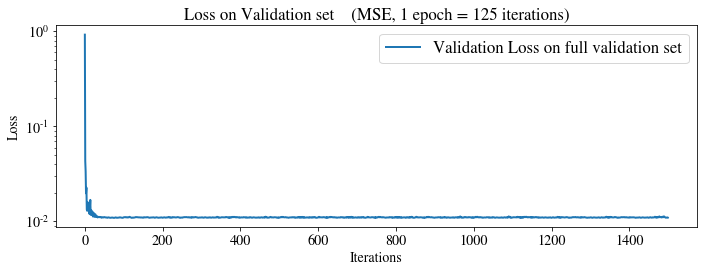

0.010484329300622146
./data/tomo0607_2qubit_random_uniform_vector/states10000_obs100/run_20220609_120809/ AE2Q_kleiner 10000.0 100 25 0.05 12
AutoencoderNet(
  (encoder): Sequential(
    (0): Linear(in_features=100, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=25, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=25, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=100, bias=True)
  )
)


100%|██████████| 12/12 [01:24<00:00,  7.08s/it]
/var/folders/tn/nyh0947d6sngjfvtp7hbb0jr0000gn/T/ipykernel_5515/863207960.py:9: UserWarning: Glyph 9 (	) missing from current font.
  a=plt.savefig(path + '/train_losses.png', dpi=150)


[0.0840242  0.08921231 0.03592478 ... 0.01071849 0.0107869  0.01104681]


/Users/canrager/.pyenv/versions/3.9.11/envs/thenv/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


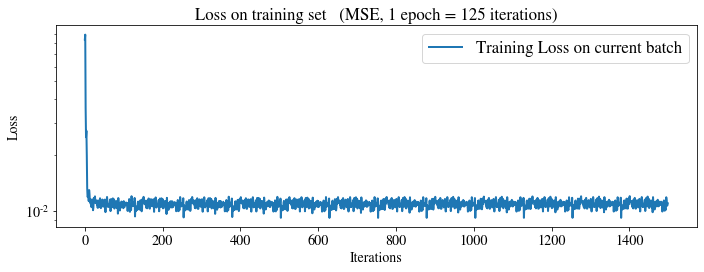

/var/folders/tn/nyh0947d6sngjfvtp7hbb0jr0000gn/T/ipykernel_5515/863207960.py:19: UserWarning: Glyph 9 (	) missing from current font.
  a=plt.savefig(path + '/valid_losses.png', dpi=150)
/Users/canrager/.pyenv/versions/3.9.11/envs/thenv/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


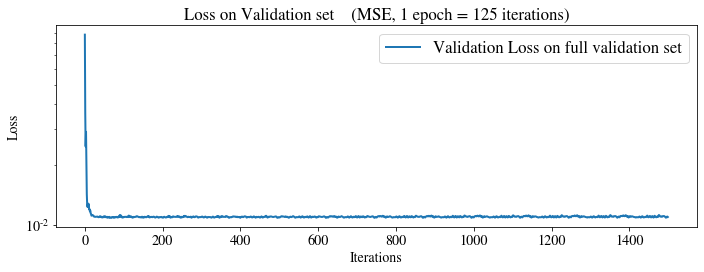

0.010522361844778061
./data/tomo0607_2qubit_random_uniform_vector/states10000_obs100/run_20220609_120809/ AE2Q_kleiner 10000.0 100 30 0.05 12
AutoencoderNet(
  (encoder): Sequential(
    (0): Linear(in_features=100, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=30, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=30, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=100, bias=True)
  )
)


100%|██████████| 12/12 [01:23<00:00,  6.96s/it]
/var/folders/tn/nyh0947d6sngjfvtp7hbb0jr0000gn/T/ipykernel_5515/863207960.py:9: UserWarning: Glyph 9 (	) missing from current font.
  a=plt.savefig(path + '/train_losses.png', dpi=150)


[0.07692873 0.03658312 0.02516794 ... 0.01066643 0.01075961 0.01101436]


/Users/canrager/.pyenv/versions/3.9.11/envs/thenv/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


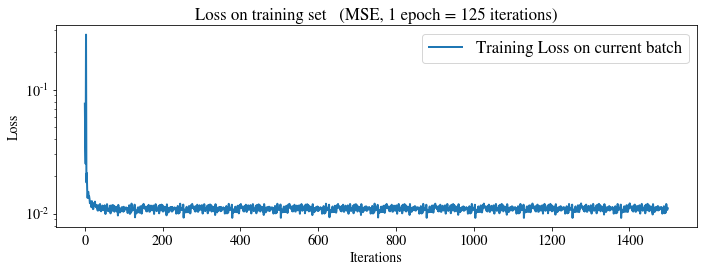

/var/folders/tn/nyh0947d6sngjfvtp7hbb0jr0000gn/T/ipykernel_5515/863207960.py:19: UserWarning: Glyph 9 (	) missing from current font.
  a=plt.savefig(path + '/valid_losses.png', dpi=150)
/Users/canrager/.pyenv/versions/3.9.11/envs/thenv/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


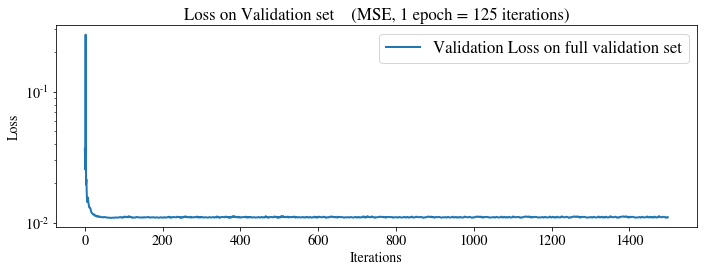

0.010518571672340235
./data/tomo0607_2qubit_random_uniform_vector/states10000_obs100/run_20220609_120744/ AE2Q_kleiner 10000.0 100 1 0.05 12
AutoencoderNet(
  (encoder): Sequential(
    (0): Linear(in_features=100, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=1, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=1, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=100, bias=True)
  )
)


100%|██████████| 12/12 [01:23<00:00,  6.98s/it]
/var/folders/tn/nyh0947d6sngjfvtp7hbb0jr0000gn/T/ipykernel_5515/863207960.py:9: UserWarning: Glyph 9 (	) missing from current font.
  a=plt.savefig(path + '/train_losses.png', dpi=150)


[0.0875661  0.39779782 0.03507731 ... 0.01087128 0.01119276 0.01072128]


/Users/canrager/.pyenv/versions/3.9.11/envs/thenv/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


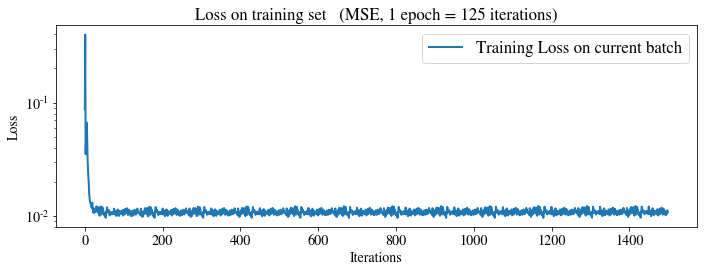

/var/folders/tn/nyh0947d6sngjfvtp7hbb0jr0000gn/T/ipykernel_5515/863207960.py:19: UserWarning: Glyph 9 (	) missing from current font.
  a=plt.savefig(path + '/valid_losses.png', dpi=150)
/Users/canrager/.pyenv/versions/3.9.11/envs/thenv/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


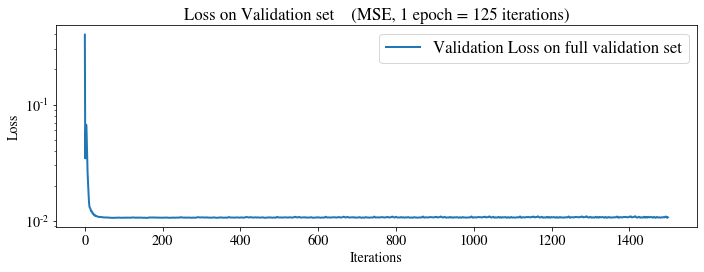

0.01063966453075409
./data/tomo0607_2qubit_random_uniform_vector/states10000_obs100/run_20220609_120744/ AE2Q_kleiner 10000.0 100 5 0.05 12
AutoencoderNet(
  (encoder): Sequential(
    (0): Linear(in_features=100, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=5, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=5, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=100, bias=True)
  )
)


100%|██████████| 12/12 [01:23<00:00,  6.99s/it]
/var/folders/tn/nyh0947d6sngjfvtp7hbb0jr0000gn/T/ipykernel_5515/863207960.py:9: UserWarning: Glyph 9 (	) missing from current font.
  a=plt.savefig(path + '/train_losses.png', dpi=150)


[0.08523887 0.03876038 0.01686012 ... 0.00922296 0.00954336 0.00965082]


/Users/canrager/.pyenv/versions/3.9.11/envs/thenv/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


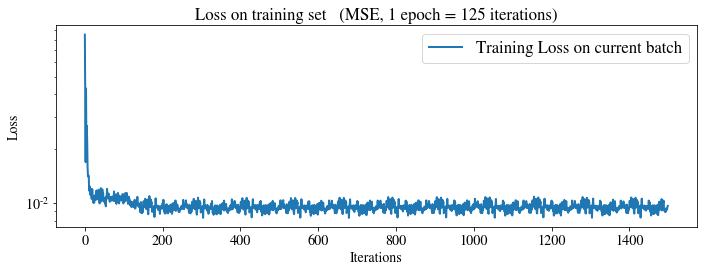

/var/folders/tn/nyh0947d6sngjfvtp7hbb0jr0000gn/T/ipykernel_5515/863207960.py:19: UserWarning: Glyph 9 (	) missing from current font.
  a=plt.savefig(path + '/valid_losses.png', dpi=150)
/Users/canrager/.pyenv/versions/3.9.11/envs/thenv/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


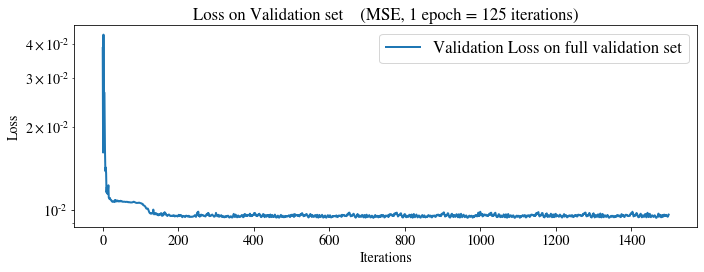

0.009469167205194633
./data/tomo0607_2qubit_random_uniform_vector/states10000_obs100/run_20220609_120744/ AE2Q_kleiner 10000.0 100 10 0.05 12
AutoencoderNet(
  (encoder): Sequential(
    (0): Linear(in_features=100, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=10, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=10, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=100, bias=True)
  )
)


100%|██████████| 12/12 [01:23<00:00,  6.96s/it]
/var/folders/tn/nyh0947d6sngjfvtp7hbb0jr0000gn/T/ipykernel_5515/863207960.py:9: UserWarning: Glyph 9 (	) missing from current font.
  a=plt.savefig(path + '/train_losses.png', dpi=150)


[0.07692613 0.03890068 0.03115209 ... 0.01092738 0.01120884 0.01073813]


/Users/canrager/.pyenv/versions/3.9.11/envs/thenv/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


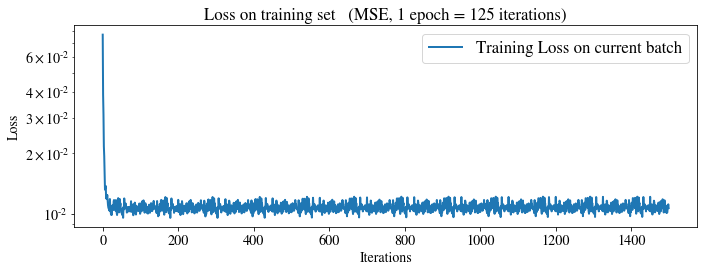

/var/folders/tn/nyh0947d6sngjfvtp7hbb0jr0000gn/T/ipykernel_5515/863207960.py:19: UserWarning: Glyph 9 (	) missing from current font.
  a=plt.savefig(path + '/valid_losses.png', dpi=150)
/Users/canrager/.pyenv/versions/3.9.11/envs/thenv/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


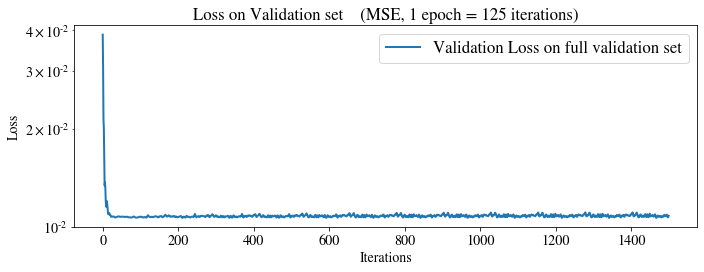

0.010678628956278165
./data/tomo0607_2qubit_random_uniform_vector/states10000_obs100/run_20220609_120744/ AE2Q_kleiner 10000.0 100 12 0.05 12
AutoencoderNet(
  (encoder): Sequential(
    (0): Linear(in_features=100, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=12, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=12, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=100, bias=True)
  )
)


100%|██████████| 12/12 [01:24<00:00,  7.04s/it]
/var/folders/tn/nyh0947d6sngjfvtp7hbb0jr0000gn/T/ipykernel_5515/863207960.py:9: UserWarning: Glyph 9 (	) missing from current font.
  a=plt.savefig(path + '/train_losses.png', dpi=150)


[0.07819069 0.09621882 0.02025175 ... 0.01092785 0.01120839 0.01072795]


/Users/canrager/.pyenv/versions/3.9.11/envs/thenv/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


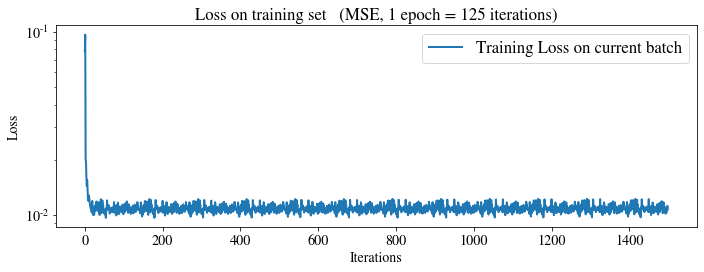

/var/folders/tn/nyh0947d6sngjfvtp7hbb0jr0000gn/T/ipykernel_5515/863207960.py:19: UserWarning: Glyph 9 (	) missing from current font.
  a=plt.savefig(path + '/valid_losses.png', dpi=150)
/Users/canrager/.pyenv/versions/3.9.11/envs/thenv/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


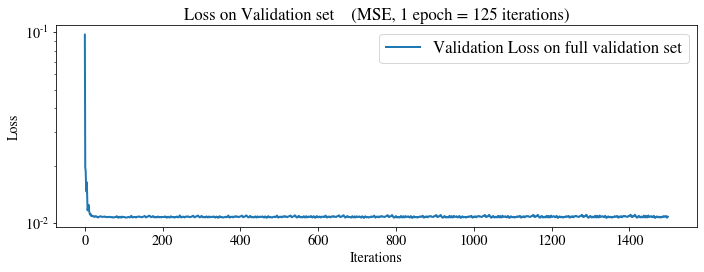

0.010675697649518649
./data/tomo0607_2qubit_random_uniform_vector/states10000_obs100/run_20220609_120744/ AE2Q_kleiner 10000.0 100 14 0.05 12
AutoencoderNet(
  (encoder): Sequential(
    (0): Linear(in_features=100, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=14, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=14, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=100, bias=True)
  )
)


100%|██████████| 12/12 [01:23<00:00,  6.98s/it]
/var/folders/tn/nyh0947d6sngjfvtp7hbb0jr0000gn/T/ipykernel_5515/863207960.py:9: UserWarning: Glyph 9 (	) missing from current font.
  a=plt.savefig(path + '/train_losses.png', dpi=150)


[0.07810342 0.04379877 0.02968411 ... 0.01092559 0.01120682 0.01073298]


/Users/canrager/.pyenv/versions/3.9.11/envs/thenv/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


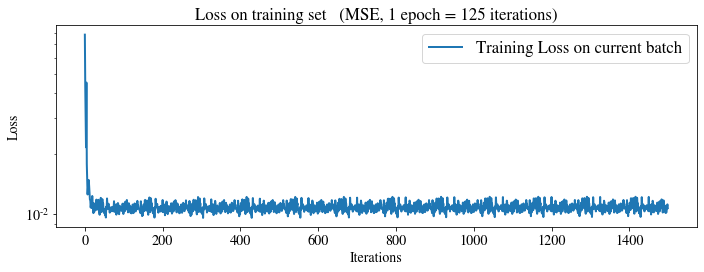

/var/folders/tn/nyh0947d6sngjfvtp7hbb0jr0000gn/T/ipykernel_5515/863207960.py:19: UserWarning: Glyph 9 (	) missing from current font.
  a=plt.savefig(path + '/valid_losses.png', dpi=150)
/Users/canrager/.pyenv/versions/3.9.11/envs/thenv/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


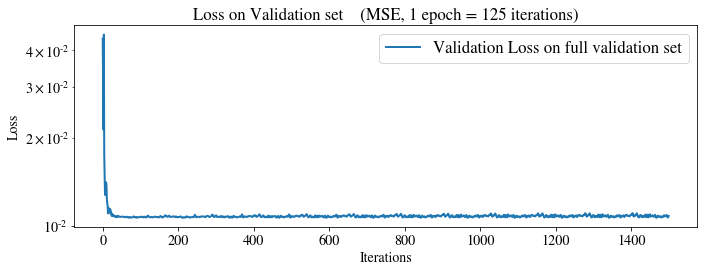

0.010678322551151117
./data/tomo0607_2qubit_random_uniform_vector/states10000_obs100/run_20220609_120744/ AE2Q_kleiner 10000.0 100 15 0.05 12
AutoencoderNet(
  (encoder): Sequential(
    (0): Linear(in_features=100, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=15, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=15, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=100, bias=True)
  )
)


 17%|█▋        | 2/12 [00:14<01:11,  7.12s/it]

In [155]:
ae_perf = ae_train_multiple_runs(data_path='./data/tomo0607_2qubit_random_uniform_vector/states10000_obs100',
                                    model_title='AE2Q_kleiner', 
                                    latent_dims=[1,5,10,12,14,15,16,18,20,25,30], 
                                    nstat=1e4, 
                                    nobs=100, 
                                    lr=5e-2, 
                                    nepochs=12)

In [ ]:
ae_perf

## Evaluation

In [61]:
def ae_eval_multiple_runs(dataexp_path, model_title, latent_dims, nstat, nobs, nruns):
    performances = np.empty((0, nruns))

    all_model_paths = [f for f in os.listdir('./models') if model_title in f]
    for ldim in latent_dims:
        ldim_perf = np.array([])
        ldim_model_paths = [f for f in all_model_paths if f'latentdim{ldim}_' in f][:nruns]
        print(f'{len(ldim_model_paths)} trained {model_title} models found with latent dim = {ldim}.')
        for run in ldim_model_paths:
            model_path = './models/' + run
            run_name = re.search('([^(run)]+$)', model_path).group(0)
            data_run_path = dataexp_path + f'/states{int(nstat)}_obs{nobs}/run{run_name}/'
            _, _, treasure_dataloader = load_dataset(data_run_path, nstat)

            loaded_model = AutoencoderNet(measurement_dim=nobs, latent_dim=ldim).to(device)
            loaded_model.load_state_dict(torch.load(model_path+'/model.model'))
            treasure_mse = evaluate_mse_ae(loaded_model, treasure_dataloader, nn.MSELoss(), device)
            ldim_perf = np.append(ldim_perf, treasure_mse)
        performances = np.vstack((performances, ldim_perf))

    ldim_means = np.mean(performances, axis=1)
    ldim_merrs = np.std(performances, axis=1) / np.sqrt(nruns)
    plt.figure(dpi=150)
    plt.errorbar(latent_dims, ldim_means, yerr=ldim_merrs, fmt='o', markersize = 2, capsize = 4)
    plt.xlabel('Dimension des latenten Vekors')
    plt.ylabel('Mittlerer quadratischer Fehler')
    plt.yscale('log')
    plt.grid()
    return performances

## Latent Representation Bloch?

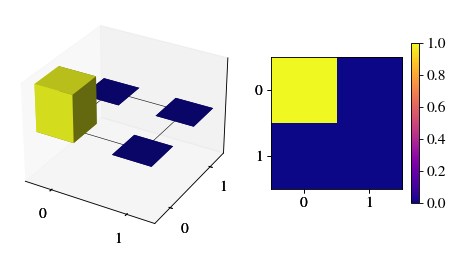

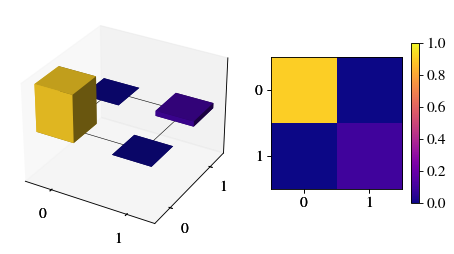

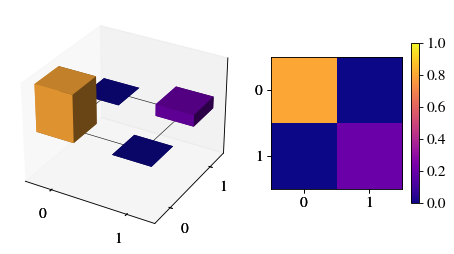

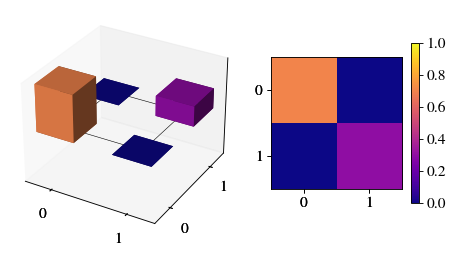

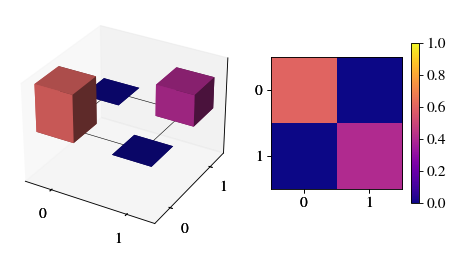

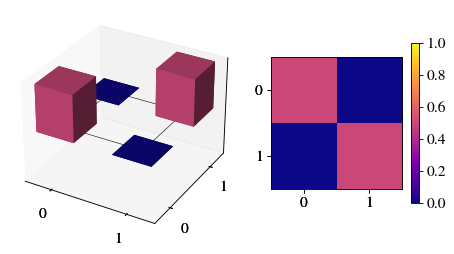

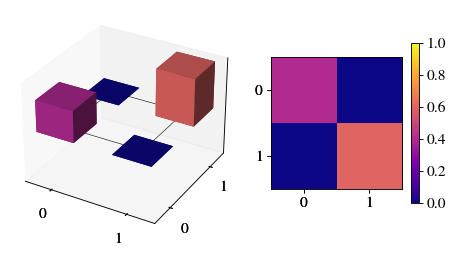

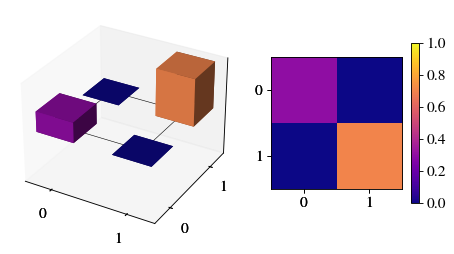

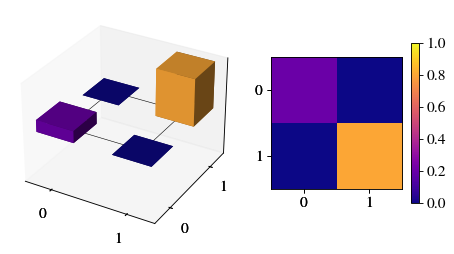

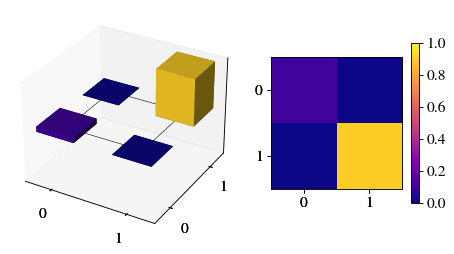

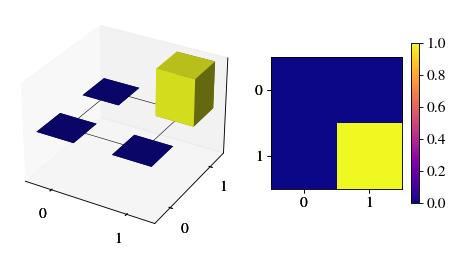

In [63]:
tspace = np.arange(11)/10
P_plus = np.array([[1,0], [0,0]])
P_minus = np.array([[0,0], [0,1]])
P_tseries = [(1-t) * P_plus + t * P_minus for t in tspace]

for Pt in P_tseries: 
    plot_dm(np.real(Pt), fixed_scale=(0,1))

In [67]:
def ae_encode_inference(rho, model_path, data_path, nobs, convert2rho=True):
    # Load observables
    dim = 2**NQ
    data_obs = np.zeros((0,dim,dim))
    with open(data_path+'/observables.csv', 'r') as f:
        reader = csv.reader(f)
        for line in tqdm(reader):
            data_obs = np.vstack((data_obs, np.array([np.array(line).reshape(dim,dim).astype('complex128')])))

    # Make measurements on state
    m_infer = torch.Tensor(perform_measurements(rho, data_obs))

    # Load Model
    load_net = AutoencoderNet(measurement_dim=nobs, latent_dim=3).to(device)
    load_net.load_state_dict(torch.load(model_path+'/model.model'))

    bloch_rep = load_net.encode(m_infer).detach().cpu().numpy()

    # Encode measurements with ae
    if convert2rho:
        return torch2rho(bloch_rep)

    return bloch_rep

100it [00:00, 25932.39it/s]
100it [00:00, 48567.67it/s]
100it [00:00, 33931.75it/s]
100it [00:00, 50889.40it/s]
100it [00:00, 39016.78it/s]
100it [00:00, 52998.53it/s]
100it [00:00, 57236.68it/s]
100it [00:00, 39980.02it/s]
100it [00:00, 55931.51it/s]
100it [00:00, 31898.27it/s]
100it [00:00, 58892.22it/s]


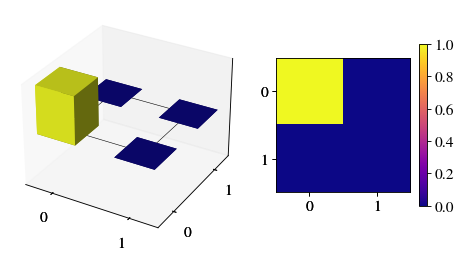

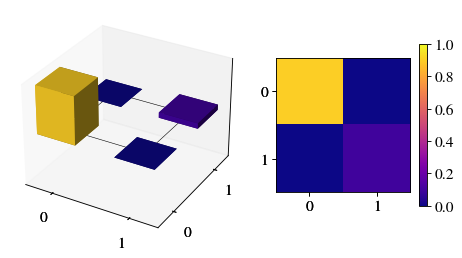

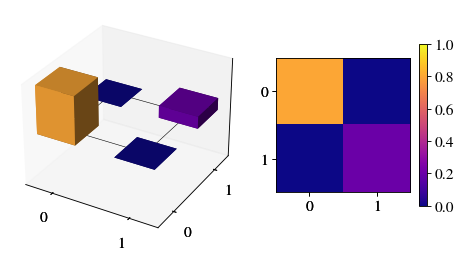

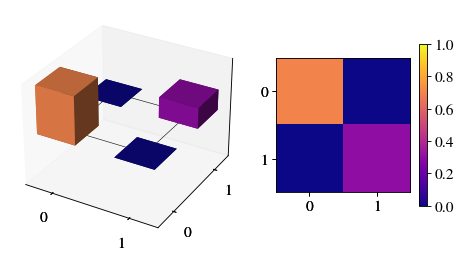

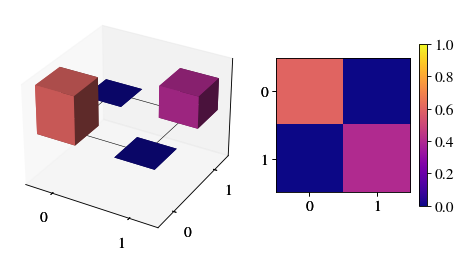

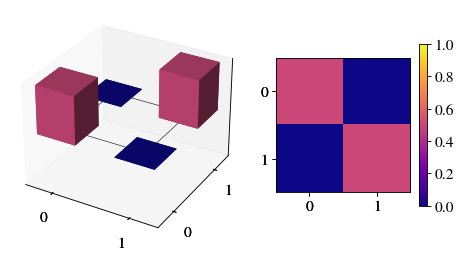

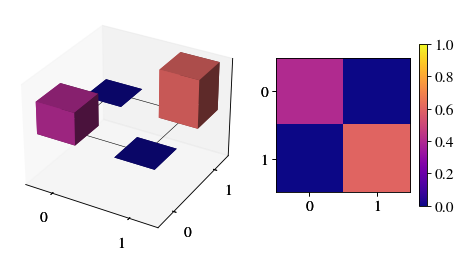

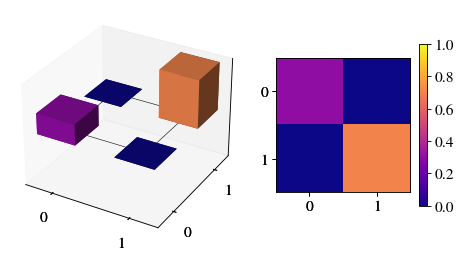

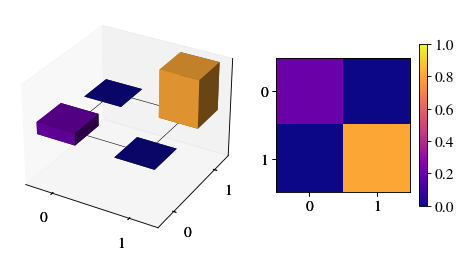

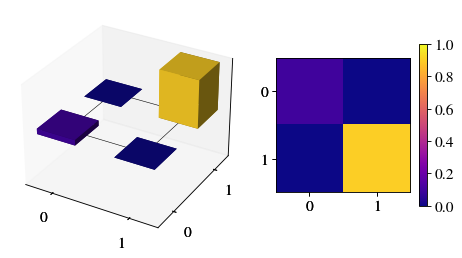

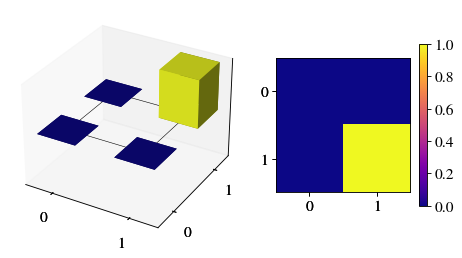

In [65]:
# ae_test_model_path = './models/AE_states10000_obs100_latentdim3_epochs20_lr0.001_FindMinDim_run_20220604_092852'
# ae_test_data_path = './data/tomo0604_1qubit_random_uniform_vector/states10000_obs100/run_20220604_092852'

# ae_test_model_path = './models/AE_states10000_obs100_latentdim3_epochs20_lr0.001_FindMinDim_run_20220604_092841'
# ae_test_data_path = './data/tomo0604_1qubit_random_uniform_vector/states10000_obs100/run_20220604_092841'

ae_test_model_path = './models/AE_states10000_obs100_latentdim3_epochs20_lr0.001_FindMinDim_run_20220604_092837'
ae_test_data_path = './data/tomo0604_1qubit_random_uniform_vector/states10000_obs100/run_20220604_092837'

Encoded_tseries = [ae_encode_inference(rho_infer, ae_test_model_path, ae_test_data_path, nobs=100) for rho_infer in P_tseries]
Encoded_tseries = np.real(Encoded_tseries)


for i, (rho_infer, rho_encoded) in enumerate(zip(P_tseries, Encoded_tseries)):
    plot_dm(np.real(rho_infer),
            save_path = f'./results/rep_series/Ptseries/{i}.png', fixed_scale=(np.min(P_tseries), np.max(P_tseries)))
    # plot_dm(np.real(rho_encoded), title='', save_path=f'./results/rep_series/enc37series/{i}.png', fixed_scale=(np.min(Encoded_tseries), np.max(Encoded_tseries)))


## Untersuche latente repräsentation

In [112]:
tseries = np.arange(0,11)/10
xyz_series = np.array([np.eye(3) * t for t in tseries])
xt = xyz_series[:,0]
yt = xyz_series[:,1]
zt = xyz_series[:,2]
onet = np.array([np.array([1,1,1]) *t for t in tseries])

ae_test_model_path = './models/AE_states10000_obs100_latentdim3_epochs20_lr0.001_FindMinDim_run_20220604_092837'
ae_test_data_path = './data/tomo0604_1qubit_random_uniform_vector/states10000_obs100/run_20220604_092837'

def encode_series(series, model_path, data_path, nobs):
    rho_series = np.array([torch2rho(vec) for vec in series])
    return np.array([ae_encode_inference(rho_infer, model_path, data_path, nobs, convert2rho=False) for rho_infer in rho_series])

xenc = encode_series(xt, ae_test_model_path, ae_test_data_path, nobs=100)
yenc = encode_series(yt, ae_test_model_path, ae_test_data_path, nobs=100)
zenc = encode_series(zt, ae_test_model_path, ae_test_data_path, nobs=100)
oneenc = encode_series(onet, ae_test_model_path, ae_test_data_path, nobs=100)

100it [00:00, 42107.26it/s]
100it [00:00, 72944.42it/s]
100it [00:00, 65017.89it/s]
100it [00:00, 76385.07it/s]
100it [00:00, 32852.70it/s]
100it [00:00, 70623.07it/s]
100it [00:00, 65917.08it/s]
100it [00:00, 63986.33it/s]
100it [00:00, 64398.96it/s]
100it [00:00, 74791.44it/s]
100it [00:00, 67858.02it/s]
100it [00:00, 77715.47it/s]
100it [00:00, 68078.30it/s]
100it [00:00, 45392.90it/s]
100it [00:00, 38886.56it/s]
100it [00:00, 87399.54it/s]
100it [00:00, 84956.53it/s]
100it [00:00, 67345.92it/s]
100it [00:00, 57669.52it/s]
100it [00:00, 58238.04it/s]
100it [00:00, 82354.29it/s]
100it [00:00, 61771.78it/s]
100it [00:00, 86587.61it/s]
100it [00:00, 70921.61it/s]
100it [00:00, 18056.33it/s]
100it [00:00, 79876.29it/s]
100it [00:00, 51312.75it/s]
100it [00:00, 40002.90it/s]
100it [00:00, 21150.24it/s]
100it [00:00, 48033.72it/s]
100it [00:00, 91419.01it/s]
100it [00:00, 67108.86it/s]
100it [00:00, 63617.53it/s]
100it [00:00, 28104.42it/s]
100it [00:00, 66355.07it/s]
100it [00:00, 76917.

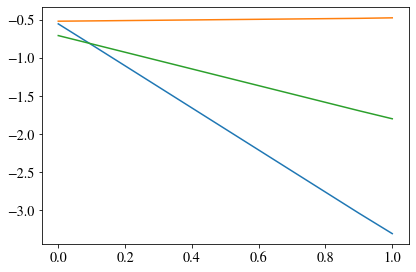

In [89]:
plt.plot(tseries, xenc[:,0])
plt.plot(tseries, xenc[:,1])
plt.plot(tseries, xenc[:,2])


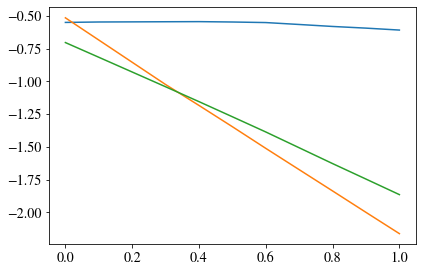

In [90]:
plt.plot(tseries, yenc[:,0])
plt.plot(tseries, yenc[:,1])
plt.plot(tseries, yenc[:,2])

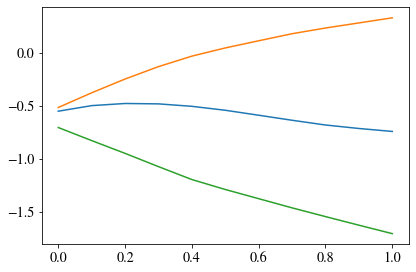

In [91]:
plt.plot(tseries, zenc[:,0])
plt.plot(tseries, zenc[:,1])
plt.plot(tseries, zenc[:,2])

In [92]:
def quad(x, a,b,c):
    return a*x**2 + b*x + c

popt, pcov = curve_fit(quad, tseries, zenc[:,1], p0=[-.5, -3, 5])
popt
np.sqrt(np.diag(pcov))

array([-0.56326337,  1.38687689, -0.50758248])

array([0.03298439, 0.03424663, 0.00736077])

Text(0.5, 0, 't')

-2.1633348

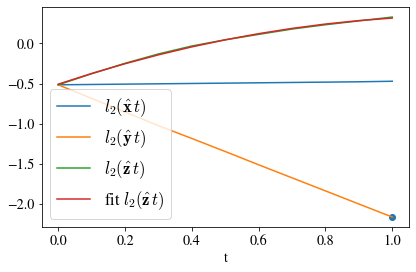

In [108]:
plt.plot(tseries, xenc[:,1], label='$l_2(\mathbf{\hat{x}}\,t)$')
plt.plot(tseries, yenc[:,1], label='$l_2(\mathbf{\hat{y}}\,t)$')
plt.plot(tseries, zenc[:,1], label='$l_2(\mathbf{\hat{z}}\,t)$')
plt.xlabel('t')

plt.plot(tseries, quad(tseries, *popt), label='fit $l_2(\mathbf{\hat{z}}\,t)$')
plt.legend()

yenc[-1,1]
plt.scatter(1,-2.163)

Text(0.5, 0, 't')

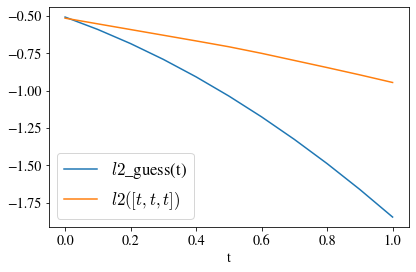

In [102]:
def l2_guess(t):
    return -0.563* t**2 + (-2.163+1.387)* t -0.508

plt.plot(tseries, l2_guess(tseries), label='$l2$_guess(t)')
plt.plot(tseries, oneenc[:,1], label='$l2([t,t,t])$')
plt.xlabel('t')
plt.legend()

Text(0, 0.5, '$l_1$')

Text(0, 0.5, '$l_2$')

Text(0.5, 0, 't')

Text(0, 0.5, '$l_3$')

Text(0.5, 0, 't')

Text(0.5, 0, 't')

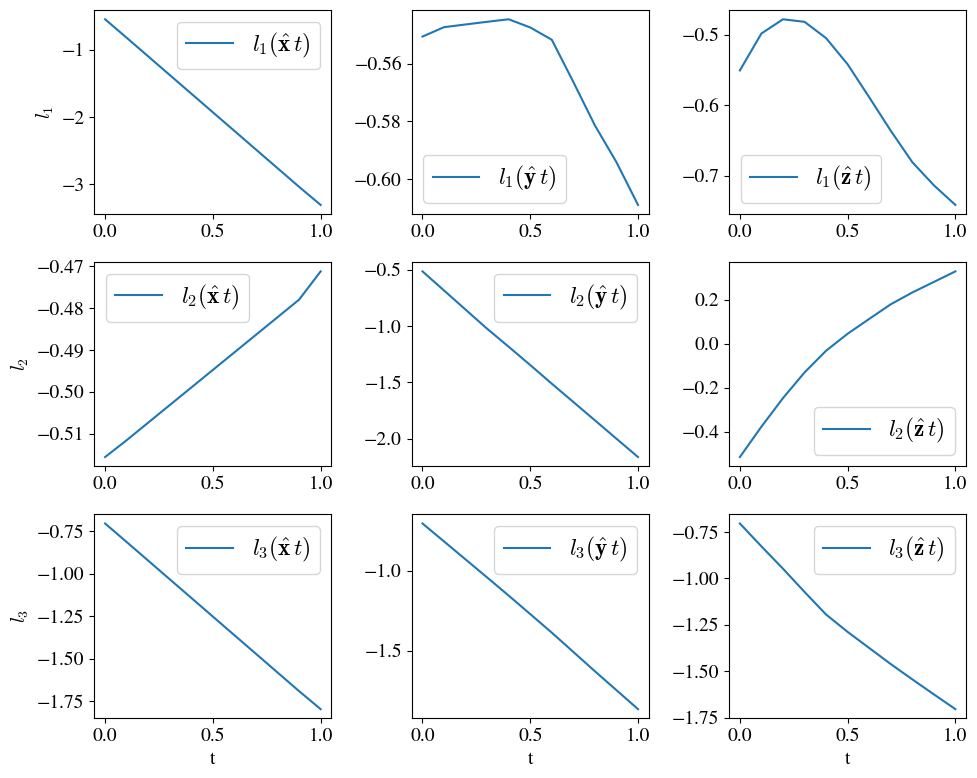

In [136]:
fig, ax = plt.subplots(3,3, dpi=100, figsize=(10,8))
xlabels = ['$\mathbf{\hat{x}}$', '$\mathbf{\hat{y}}$', '$\mathbf{\hat{z}}$']
ylabels = ['$l_1$', '$l_2$', '$l_3$']

for col, encoded_series in enumerate([xenc, yenc, zenc]):
    for row in range(3):
        ax[row,col].plot(tseries, encoded_series[:,row], label=f'{ylabels[row]}$(${xlabels[col]}$\,t)$') # , row {row}, col {col}
        ax[row,col].legend()

        if row == 2:
            ax[row,col].set_xlabel('t')
        if col == 0:
            ax[row,col].set_ylabel(ylabels[row])

# Labelling incorrect
